# Sales Data Analysis and Forecasting Using Ensemble Methods

Sales forecasting is a common task performed by organizations to estimate expected revenue based on historical data. This is a challenging and interesting problem because there are many factors that can influence sales. For example, the weather, the season, and the day of the week can all impact sales. In this notebook, we will use historical sales data from a large retailer to predict future sales using ensemble methods.

We will also perform Data Analysis and Statistical Analysis to understand the data and its features and how they can influence the sales.

The data is available on Kaggle: https://www.kaggle.com/competitions/rossmann-store-sales/overview

We will go through the following steps:
* 1. [Data Collection and Cleaning](#1-data-collection-and-cleaning)
* 2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
* 3. [Data Analysis and Data Visualization](#3-data-analysis-and-data-visualization)
* 4. [Sales Forecasting](#4-sales-forecasting)

## 1. Data Collection and Exploration

In [91]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set style and color palette
sns.set(style='darkgrid', palette='mako')
# Change the setting and put it in a dictionary
plot_settings = {
    'font.family': 'calibri',
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'figure.dpi': 140,
    'axes.titlepad': 15,
    'axes.labelpad': 15,
    'figure.titlesize': 24,
    'figure.titleweight': 'bold',
}
# Use the dictionary variable to update the settings using matplotlib
plt.rcParams.update(plot_settings)

In [2]:
# Download the data from kaggle
#! kaggle competitions download -c rossmann-store-sales

In [3]:
'''# Unzip the data
with zipfile.ZipFile('rossmann-store-sales.zip', 'r') as zip_ref:
    zip_ref.extractall('rossmann-store-sales')
# Delete the zip file
os.remove('rossmann-store-sales.zip')'''

"# Unzip the data\nwith zipfile.ZipFile('rossmann-store-sales.zip', 'r') as zip_ref:\n    zip_ref.extractall('rossmann-store-sales')\n# Delete the zip file\nos.remove('rossmann-store-sales.zip')"

In [146]:
# Read the data
train = pd.read_csv('rossmann-store-sales/train.csv')
store = pd.read_csv('rossmann-store-sales/store.csv')
test = pd.read_csv('rossmann-store-sales/test.csv')

In [5]:
# Inspect the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
# Check the head of the data
train.head()

Store  DayOfWeek        Date  Sales  ...  Open  Promo  StateHoliday SchoolHoliday
0      1          5  2015-07-31   5263  ...     1      1             0             1
1      2          5  2015-07-31   6064  ...     1      1             0             1
2      3          5  2015-07-31   8314  ...     1      1             0             1
3      4          5  2015-07-31  13995  ...     1      1             0             1
4      5          5  2015-07-31   4822  ...     1      1             0             1

[5 rows x 9 columns]

StateHoliday's data type is object, why is that the case? Let's check the unique values in that column.

In [7]:
# Check the value counts of StateHoliday
train.StateHoliday.value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

As we can see, the StateHoliday has 4 different values: 0, a, b, c. With a being public holiday, b being Easter holiday, and c being Christmas.

We will replace the values a, b, c with 1, 2, 3 respectively. This will make the data much more consistent and ready for regression.


The 0 value is found 2 different times, so we can assume that the second 0 is a string '0' and not a number 0.

In [8]:
# Convert the StateHoliday column to int64
train['StateHoliday'] = train['StateHoliday'].replace(['a', 'b', 'c'], [1, 2, 3]).astype('int64')

In [9]:
# Check the value counts again
train.StateHoliday.value_counts()

StateHoliday
0    986159
1     20260
2      6690
3      4100
Name: count, dtype: int64

This went well, with the two 0 values merging into one.

In [10]:
# Convert the Date column to datetime
train['Date'] = pd.to_datetime(train['Date'])

In [11]:
# Inspect the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  int64         
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 69.8 MB


In [12]:
# Check the head of the data
train.head()

Store  DayOfWeek       Date  Sales  ...  Open  Promo  StateHoliday  SchoolHoliday
0      1          5 2015-07-31   5263  ...     1      1             0              1
1      2          5 2015-07-31   6064  ...     1      1             0              1
2      3          5 2015-07-31   8314  ...     1      1             0              1
3      4          5 2015-07-31  13995  ...     1      1             0              1
4      5          5 2015-07-31   4822  ...     1      1             0              1

[5 rows x 9 columns]

In [13]:
# Check the value counts of each column to check for inconsistencies
for col in train.columns:
    print('Column: ', col, '\n', train[col].value_counts(), '\n')

Column:  Store 
 Store
1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: count, Length: 1115, dtype: int64 

Column:  DayOfWeek 
 DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64 

Column:  Date 
 Date
2015-07-31    1115
2013-11-06    1115
2013-11-18    1115
2013-11-17    1115
2013-11-16    1115
              ... 
2014-10-28     935
2014-10-27     935
2014-10-26     935
2014-10-25     935
2014-12-08     935
Name: count, Length: 942, dtype: int64 

Column:  Sales 
 Sales
0        172871
5674        215
5558        197
5483        196
6214        195
          ...  
23806         1
24183         1
20651         1
25083         1
23303         1
Name: count, Length: 21734, dtype: int64 

Column:  Customers 
 Customers
0       172869
560       2414
576       2363
603       2337
571       2330
         ...  
4815         1
3998         1
4210   

## 2. Exploratory Data Analysis

In [14]:
# Display the summary statistics of the data
train.describe().T.style.format('{:.2f}')

In [15]:
# Extract the year, month, week, and day from the date column
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
# Isocalendar returns a tuple of (year, week, weekday) for each date
train['Week'] = train['Date'].apply(lambda x: x.isocalendar()[1])
train['Day'] = train['Date'].dt.day

In [16]:
# Add a new feature for sales per customer
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

In [17]:
# Display the summary statistics of the SalesPerCustomer column
train['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

Customers spend an average of 9.49 euros per day in a store, with a maximum of 64.9 euros. The standard deviation is 2.19 euros.

We can see that there is a lot of missing data, which can mean that some sales values we divided by 0, which means that some days had no customers.

Empirical Cumulative Distribution Function (ECDF) is a great way to visualize the distribution of a variable. It shows the probability that the variable will take a value less than or equal to a given value.

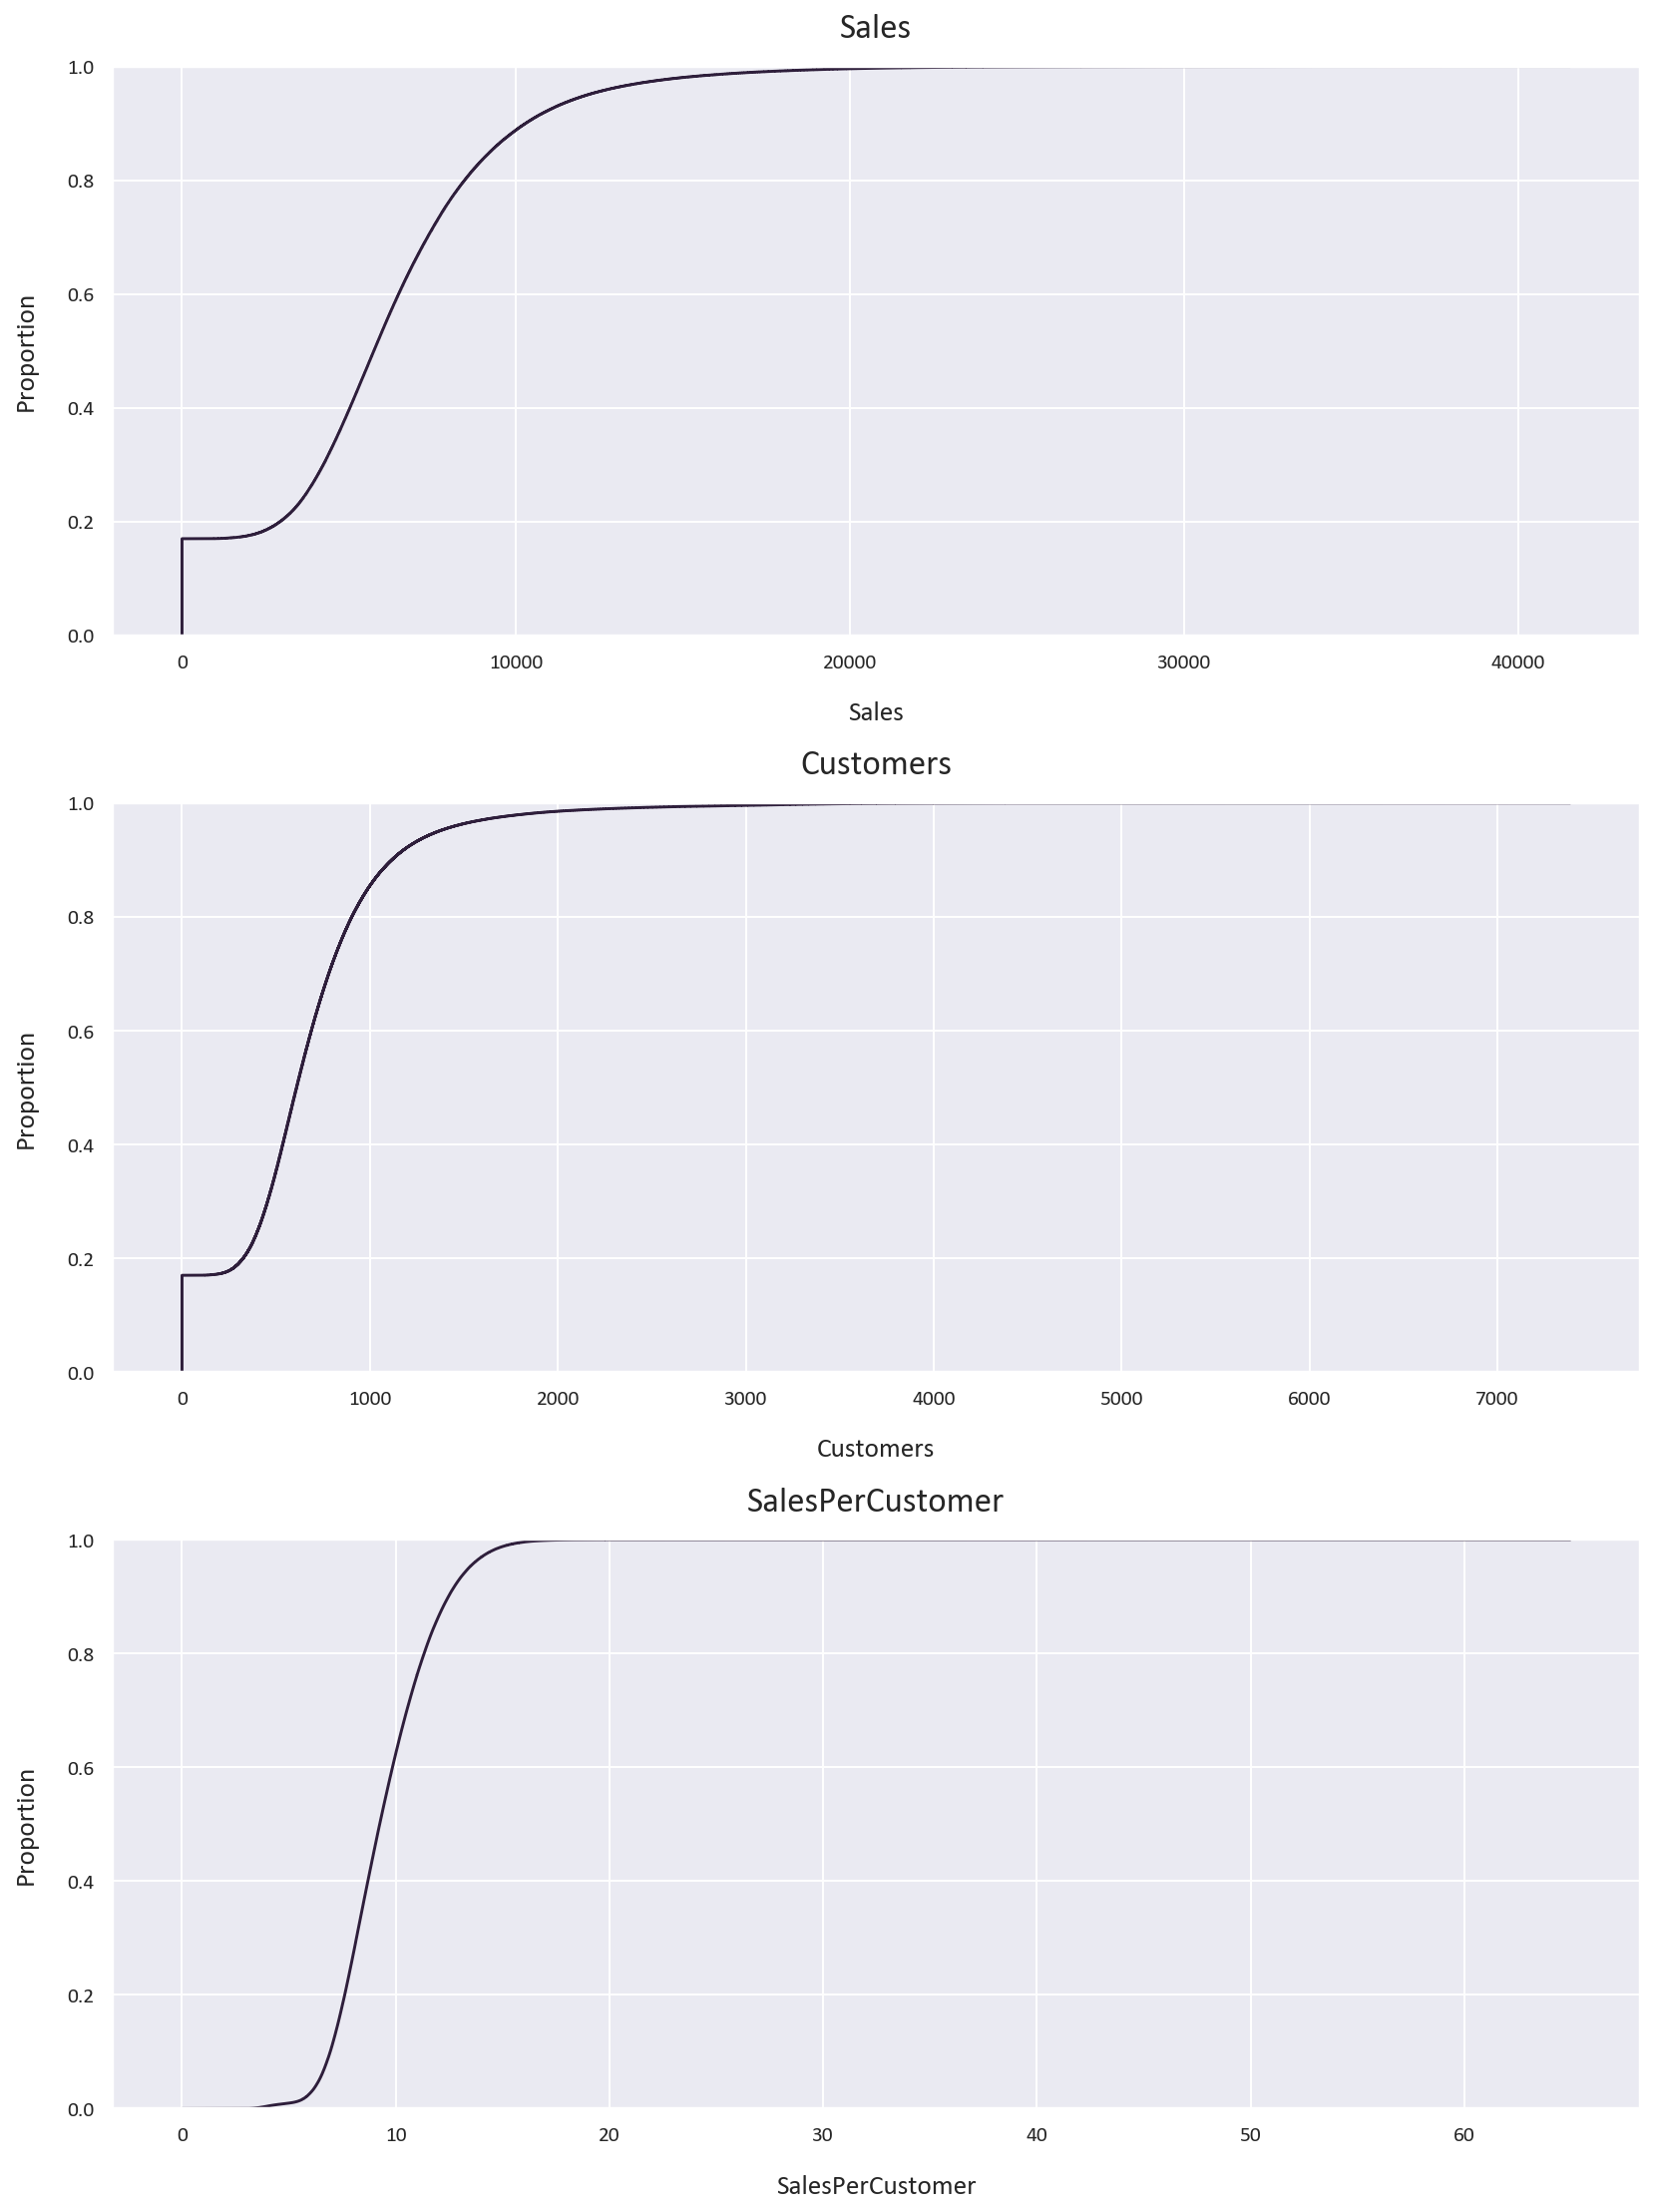

In [18]:
# Perform Empirical Cumulative Distribution Function (ECDF) analysis on the data
plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)
sns.ecdfplot(data=train, x='Sales')
plt.title('Sales')
plt.subplot(3, 1, 2)
sns.ecdfplot(data=train, x='Customers')
plt.title('Customers')
plt.subplot(3, 1, 3)
sns.ecdfplot(data=train, x='SalesPerCustomer')
plt.title('SalesPerCustomer')
plt.tight_layout()

We can see that the sales data is skewed to the right, with about 90% of the sales being less than 10,000 euros.

The customers data is also skewed to the right, with over 80% of the customers being less than 1,000.

As for the sales per customer, we can see that about 60% of the sales per customer are less than 10 euros. This is closer to the normal distribution than the sales and customers data.

We can also see that under 20% of the data has 0 sales or 0 customers, let's explore this further. Is it because the store is closed or is it because there are no customers?

In [19]:
# Check for missing values in the data
train.isnull().sum()

Store                    0
DayOfWeek                0
Date                     0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Week                     0
Day                      0
SalesPerCustomer    172869
dtype: int64

As we can see, there is 172869 missing values in the SalesPerCustomer column. We can assume that this is because some days had no customers. Let's check if this is true.

In [20]:
# Check for days that the stores were closed
train[train['Open'] == 0].shape

(172817, 14)

In [21]:
# Check for days that the stores were open and had no customers
train[(train['Open'] == 1) & (train['Customers'] == 0)].shape

(52, 14)

In [22]:
# Add the two conditions together to get the total number
# of days that the stores were closed or had no customers
train[(train['Open'] == 0) | ((train['Open'] == 1) & (train['Customers'] == 0))].shape

(172869, 14)

As we expected, the missing values came from days that the stores were closed or had no customers. We can simply drop these values, as they may impact our model negatively.

In [23]:
# Drop the rows where the stores were closed or had no customers
train = train[(train['Open'] == 1) & (train['Customers'] != 0)]

In [24]:
# Check for missing values again
train.isnull().sum()

Store               0
DayOfWeek           0
Date                0
Sales               0
Customers           0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
Year                0
Month               0
Week                0
Day                 0
SalesPerCustomer    0
dtype: int64

In [25]:
# Check the shape of the data
train.shape

(844340, 14)

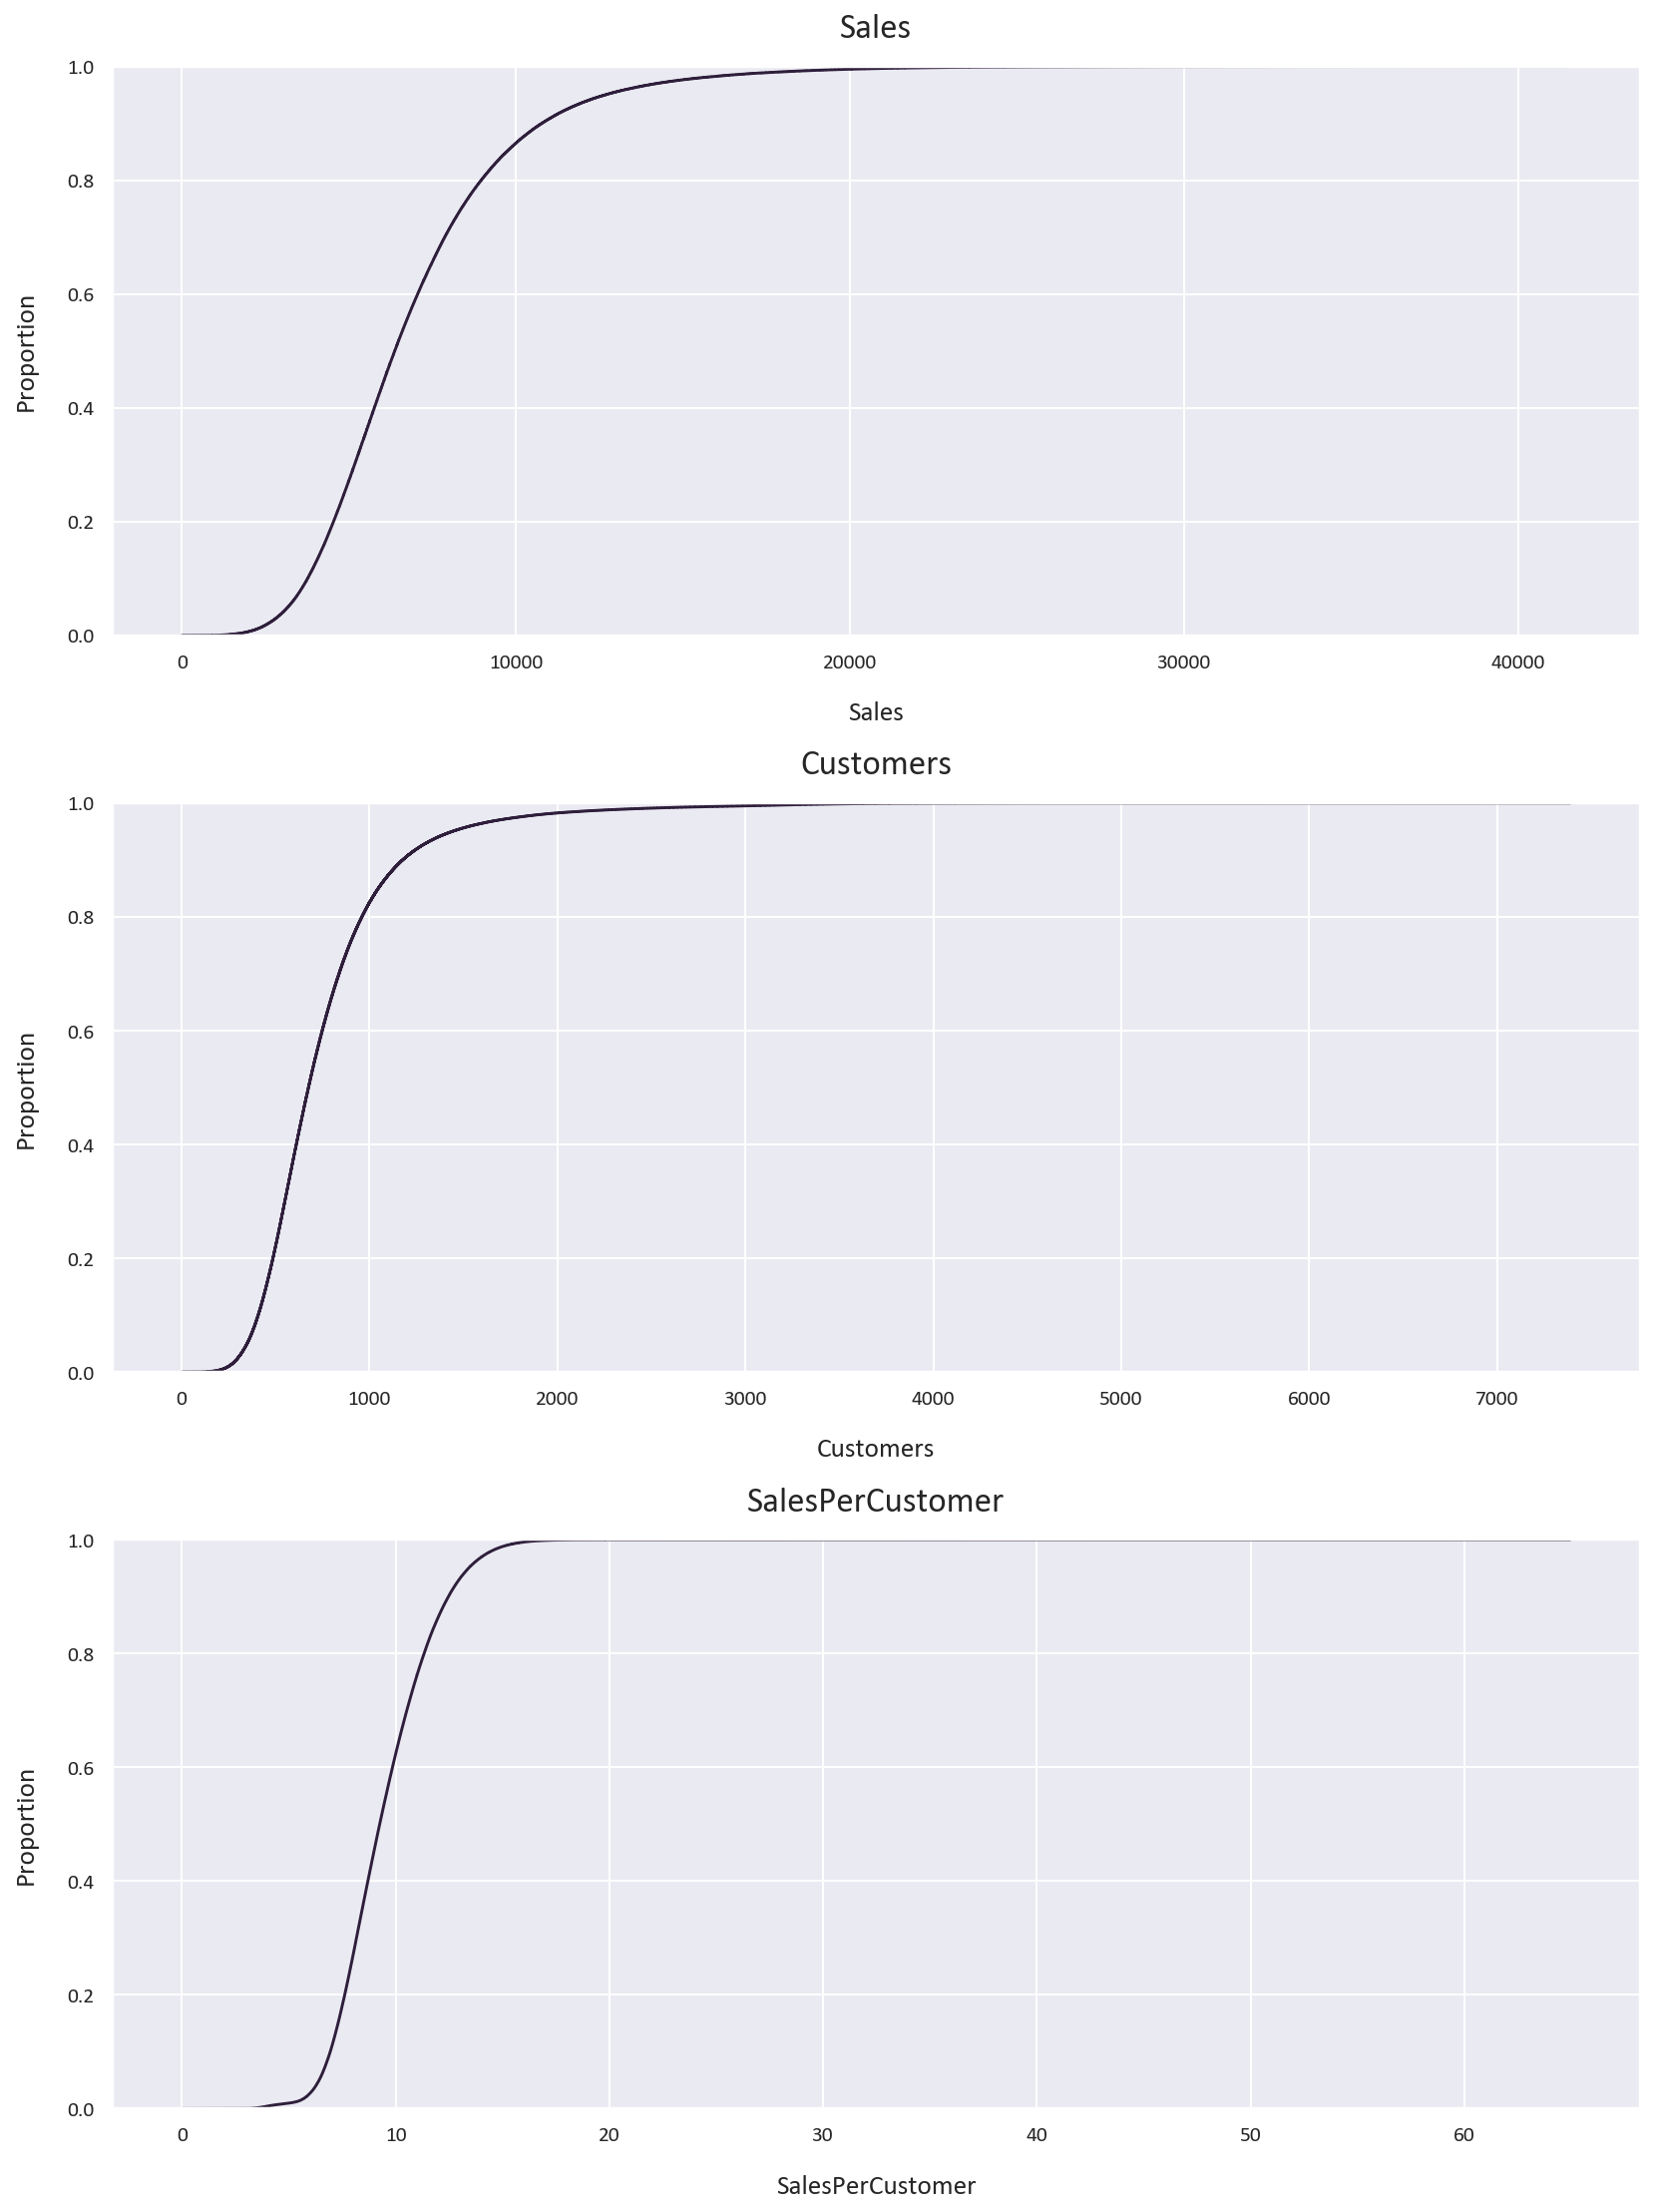

In [26]:
# Perform ECDF analysis on the data again
plt.figure(figsize=(12, 16))
plt.subplot(3, 1, 1)
sns.ecdfplot(data=train, x='Sales')
plt.title('Sales')
plt.subplot(3, 1, 2)
sns.ecdfplot(data=train, x='Customers')
plt.title('Customers')
plt.subplot(3, 1, 3)
sns.ecdfplot(data=train, x='SalesPerCustomer')
plt.title('SalesPerCustomer')
plt.tight_layout()

As the open column has only 1 values, we can drop it as it will not be useful for our model.

In [27]:
# Drop the open column
train.drop('Open', axis=1, inplace=True)

Text(0.5, 1.0, 'Correlation Matrix')

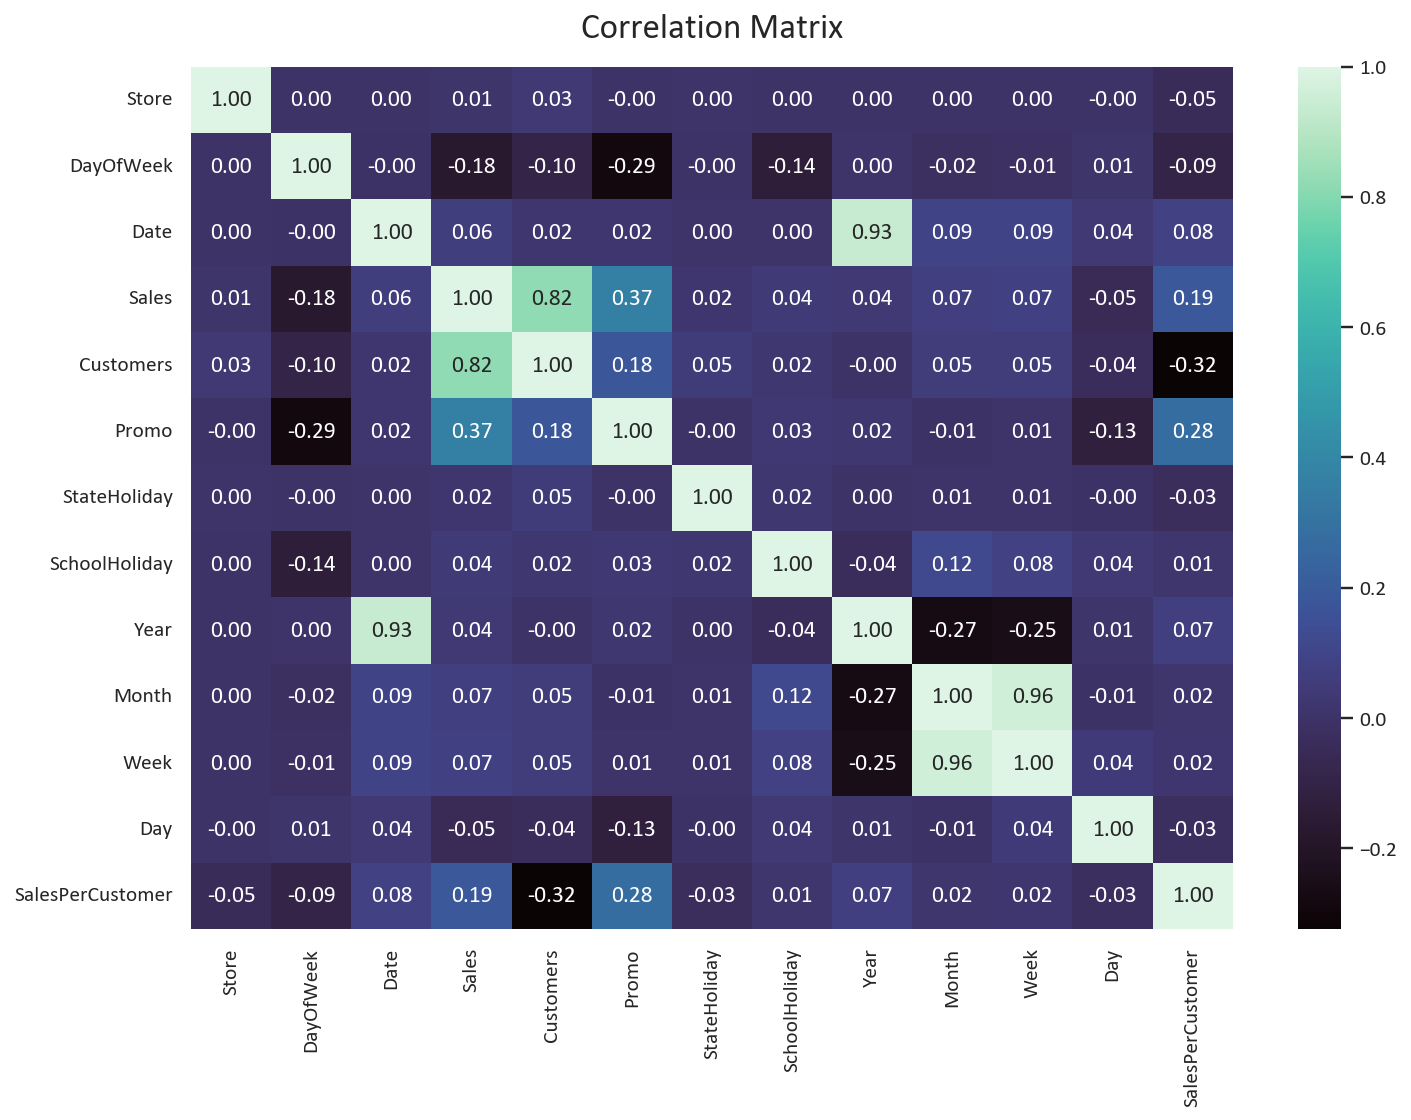

In [28]:
# Visualize the correlation matrix of the data
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, cmap='mako', fmt='.2f')
plt.title('Correlation Matrix')

Looking at the correlation matrix, we can see that the year column doesn't have much correlation with the other columns. This is because the data is only for 2013, 2014, and 2015 so the year column is not very useful. As there isn't enough years for there to be a clear trend, we can drop this column.

As for the month and week columns, we can that the later months and weeks have higher sales and customers. This could be because of the sales and promotions that happen in the later months of the year. We can keep these columns as they may be useful for our model.

As for the day column, it has a negative correlation with the sales and customers columns. This means that the later days of the month have lower sales and customers. This could be because of the fact that the beginning of the month is when many people get their salaries, so they have more money to spend. We can keep this column as it may be useful for our model.

The DayOfWeek column has a negative correlation with the sales and customers columns. This means that the later days of the week have lower sales and customers. This is strange, as we would expect the weekends to have higher sales and customers. One explanation for this is that some stores are closed on Sundays, we can explore this further.

These columns have slight correlations but could serve as useful features for our model.

In [29]:
# Drop the Year column
train.drop('Year', axis=1, inplace=True)

In [30]:
# How many days of the week are the stores open?
train['DayOfWeek'].value_counts()

DayOfWeek
6    144052
2    143956
3    141922
5    138633
1    137557
4    134627
7      3593
Name: count, dtype: int64

In [31]:
# Which stores are open on Sundays?
train[train['DayOfWeek'] == 7]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877],
      dtype=int64)

In [32]:
# What percentage of the stores are open on Sundays?
len(train[train['DayOfWeek'] == 7]['Store'].unique()) / len(train['Store'].unique()) * 100

2.9596412556053813

As we suspected, only 2.95% of the stores are open on Sundays. This explains the negative correlation between the DayOfWeek column and the sales and customers columns.

This can introduce bias to our model, so we can drop the DayOfWeek column.

In [33]:
# Drop the DayOfWeek column
train.drop('DayOfWeek', axis=1, inplace=True)

Next, let's explore the store data.

In [34]:
# Check the head of the data
store.head()

Store StoreType  ... Promo2SinceYear    PromoInterval
0      1         c  ...             NaN              NaN
1      2         a  ...          2010.0  Jan,Apr,Jul,Oct
2      3         a  ...          2011.0  Jan,Apr,Jul,Oct
3      4         c  ...             NaN              NaN
4      5         a  ...             NaN              NaN

[5 rows x 10 columns]

In [35]:
# Inspect the store data
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


These are the descriptions of the columns:
* Store: a unique ID for each store

* StoreType: differentiates between 4 different store types: a, b, c, d

* Assortment: describes an assortment level: a = basic, b = extra, c = extended

* CompetitionDistance: distance in meters to the nearest competitor store

* CompetitionOpenSince(Month/Year): gives the approximate year and month of the time the nearest competitor was opened

* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating

* Promo2Since(Year/Week): describes the year and calendar week when the store started participating in Promo2

* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [36]:
# Check for missing values in the data
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We can see that there are some missing values in the dataset, let's explore this further.

In [37]:
# Check the missing values in the CompetitionDistance column
store[store['CompetitionDistance'].isnull()]

Store StoreType  ... Promo2SinceYear    PromoInterval
290    291         d  ...             NaN              NaN
621    622         a  ...             NaN              NaN
878    879         d  ...          2013.0  Feb,May,Aug,Nov

[3 rows x 10 columns]

In [38]:
# Fill the missing values with the mean since the data is continuous
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [39]:
# Check the missing values in the CompetitionOpenSinceMonth column
store[store['CompetitionOpenSinceMonth'].isnull()]

Store StoreType  ... Promo2SinceYear     PromoInterval
11       12         a  ...          2010.0   Jan,Apr,Jul,Oct
12       13         d  ...          2009.0   Feb,May,Aug,Nov
15       16         a  ...             NaN               NaN
18       19         a  ...          2011.0  Mar,Jun,Sept,Dec
21       22         a  ...          2012.0   Jan,Apr,Jul,Oct
...     ...       ...  ...             ...               ...
1095   1096         a  ...          2014.0  Mar,Jun,Sept,Dec
1099   1100         a  ...          2011.0   Jan,Apr,Jul,Oct
1112   1113         a  ...             NaN               NaN
1113   1114         a  ...             NaN               NaN
1114   1115         d  ...          2012.0  Mar,Jun,Sept,Dec

[354 rows x 10 columns]

We can see that the information in CompetitionOpenSinceYear and CompetitionOpenSinceMonth columns is simply missing, as the competition distance is present. We can simply fill these values with 0 as the information is not available.

In [40]:
# Fill the missing values with 0
store['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store['CompetitionOpenSinceYear'].fillna(0, inplace=True)

In [41]:
# Check the missing values in the Promo2SinceWeek column
promo_missing = store[store['Promo2SinceWeek'].isnull()]

The Promo2SinceWeek, Promo2SinceYear, and PromoInterval columns seem to be missing values because the stores are not participating in Promo2. Let's make sure this is true.

In [42]:
# Are there any stores that have Promo2 as 1 but the Promo2SinceWeek is null?
promo_missing[promo_missing['Promo2'] == 1].shape

(0, 10)

As we assumed, the missing values in the Promo2SinceWeek, Promo2SinceYear, and PromoInterval columns are because the stores are not participating in Promo2. We can simply fill these values with 0 as the information is not available.

In [43]:
# Fill the remaining missing values with 0
store.fillna(0, inplace=True)

In [44]:
# Make sure there are no missing values in the data
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [45]:
# Merge the train and store data on the Store column
df = pd.merge(train, store, on='Store')

In [46]:
# Inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844340 entries, 0 to 844339
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844340 non-null  int64         
 1   Date                       844340 non-null  datetime64[ns]
 2   Sales                      844340 non-null  int64         
 3   Customers                  844340 non-null  int64         
 4   Promo                      844340 non-null  int64         
 5   StateHoliday               844340 non-null  int64         
 6   SchoolHoliday              844340 non-null  int64         
 7   Month                      844340 non-null  int32         
 8   Week                       844340 non-null  int64         
 9   Day                        844340 non-null  int32         
 10  SalesPerCustomer           844340 non-null  float64       
 11  StoreType                  844340 non-null  object  

As our objective is sales forecasting, we should set the date column as the index.

We should also sort the index from the earliest date to the latest date. This will make it easier to plot the data.

In [47]:
# Set the Date column as the index
df.set_index('Date', inplace=True)
# Sort the index in ascending order
df.sort_index(inplace=True)

In [48]:
# Replace the StoreTypes and Assortments with numbers
df['StoreType'] = df['StoreType'].replace(['a', 'b', 'c', 'd'], [1, 2, 3, 4])
df['Assortment'] = df['Assortment'].replace(['a', 'b', 'c'], [1, 2, 3])

In [49]:
# Make a new column for the number of months that the competition has been open
df['CompetitionOpenMonths'] = 12 * (df.index.year - df['CompetitionOpenSinceYear']) + (df['Month'] - df['CompetitionOpenSinceMonth'])

In [50]:
# Inspect the data
df.head()

Store  Sales  ...  PromoInterval  CompetitionOpenMonths
Date                      ...                                      
2013-01-01    423   9643  ...              0                  -16.0
2013-01-01    676   3821  ...              0                   52.0
2013-01-01    948   4491  ...              0                24157.0
2013-01-01    262  17267  ...              0                   -4.0
2013-01-01   1097   5961  ...              0                  130.0

[5 rows x 20 columns]

We can see there are stores that have CompetitionOpenSinceYear and CompetitionOpenSinceMonth values of 0, which cause the CompetitionOpenMonths to have huge values.

This means that the information is not available, so we have to deal with these values.

In [51]:
# How many rows have 0 values in the CompetitionOpenSinceMonth and
# CompetitionOpenSinceYear columns?
df[df['CompetitionOpenSinceMonth'] == 0].shape, df[df['CompetitionOpenSinceYear'] == 0].shape

((268602, 20), (268602, 20))

In [52]:
# Are these the same rows?
(df[df['CompetitionOpenSinceMonth'] == 0].index == df[df['CompetitionOpenSinceYear'] == 0].index).all()

True

Yup, They are the same rows.

There are 268,602 zero values in the CompetitionOpenSinceYear column, which is a huge portion of the data. We can't simply drop these values, as we will lose a lot of data.

We also can't fill these values with the mean or median, as this will introduce bias to our model.

What we can do is for these rows, we set the CompetitionOpenMonths values as 0 as this information is not available.

In [53]:
# For these rows, set the CompetitionOpenMonths values to 0
df.loc[df['CompetitionOpenSinceMonth'] == 0, 'CompetitionOpenMonths'] = 0

In [54]:
# Make sure the values are now consistent
df['CompetitionOpenMonths'].value_counts()

CompetitionOpenMonths
0.0       273185
7.0         5369
4.0         5361
6.0         5321
10.0        5255
           ...  
632.0         23
1373.0        23
1360.0        23
619.0         23
202.0         23
Name: count, Length: 367, dtype: int64

We can see that there are some huge values left in the CompetitionOpenMonths column, let's explore this further.

In [55]:
# Inspect the huge values in the CompetitionOpenMonths column
df[df['CompetitionOpenMonths'] > 1200]

Store  Sales  ...    PromoInterval  CompetitionOpenMonths
Date                      ...                                        
2013-01-02    815   9852  ...  Jan,Apr,Jul,Oct                 1356.0
2013-01-03    815   8059  ...  Jan,Apr,Jul,Oct                 1356.0
2013-01-04    815   8210  ...  Jan,Apr,Jul,Oct                 1356.0
2013-01-05    815   7843  ...  Jan,Apr,Jul,Oct                 1356.0
2013-01-07    815  12868  ...  Jan,Apr,Jul,Oct                 1356.0
...           ...    ...  ...              ...                    ...
2015-07-27    815   8201  ...  Jan,Apr,Jul,Oct                 1386.0
2015-07-28    815   7908  ...  Jan,Apr,Jul,Oct                 1386.0
2015-07-29    815   6604  ...  Jan,Apr,Jul,Oct                 1386.0
2015-07-30    815   7983  ...  Jan,Apr,Jul,Oct                 1386.0
2015-07-31    815   8186  ...  Jan,Apr,Jul,Oct                 1386.0

[622 rows x 20 columns]

In [56]:
# How many stores have competition open since 1900?
df[df['CompetitionOpenSinceYear'] == 1900]['Store'].unique()

array([815], dtype=int64)

Only 1 store has a CompetitionOpenSinceYear value of 1900, which is a huge outlier. As this is the only store, we can simply set this value to 0.

In [57]:
# Set the CompetitionOpenMonths values to 0 for this store
df.loc[df['Store'] == 815, 'CompetitionOpenMonths'] = 0

In [58]:
# Make sure the values are now consistent again
df['CompetitionOpenMonths'].value_counts()

CompetitionOpenMonths
0.0      273807
7.0        5369
4.0        5361
6.0        5321
10.0       5255
          ...  
628.0        24
643.0        23
202.0        23
619.0        23
632.0        23
Name: count, Length: 342, dtype: int64

In [59]:
# Explore the large values in the CompetitionOpenMonths column again
df[df['CompetitionOpenMonths'] > 300]

Store  Sales  ...     PromoInterval  CompetitionOpenMonths
Date                      ...                                         
2013-01-02    146   6273  ...   Jan,Apr,Jul,Oct                  615.0
2013-01-03    146   6003  ...   Jan,Apr,Jul,Oct                  615.0
2013-01-04    146   7089  ...   Jan,Apr,Jul,Oct                  615.0
2013-01-05    146   5538  ...   Jan,Apr,Jul,Oct                  615.0
2013-01-07    146  10104  ...   Jan,Apr,Jul,Oct                  615.0
...           ...    ...  ...               ...                    ...
2015-07-30    329   7316  ...  Mar,Jun,Sept,Dec                  301.0
2015-07-30    146   8798  ...   Jan,Apr,Jul,Oct                  645.0
2015-07-31   1039   9479  ...  Mar,Jun,Sept,Dec                  301.0
2015-07-31    329   9168  ...  Mar,Jun,Sept,Dec                  301.0
2015-07-31    146  10130  ...   Jan,Apr,Jul,Oct                  645.0

[833 rows x 20 columns]

These values actually look reasonable, so we can keep them.

In [60]:
# Inspect the data
df.head()

Store  Sales  ...  PromoInterval  CompetitionOpenMonths
Date                      ...                                      
2013-01-01    423   9643  ...              0                  -16.0
2013-01-01    676   3821  ...              0                   52.0
2013-01-01    948   4491  ...              0                    0.0
2013-01-01    262  17267  ...              0                   -4.0
2013-01-01   1097   5961  ...              0                  130.0

[5 rows x 20 columns]

In [61]:
# Drop the PromoInterval column as it is not needed
df.drop('PromoInterval', axis=1, inplace=True)

Let's look at the correlation matrix again to determine the useful features for our model.

Text(0.5, 1.0, 'Correlation Matrix')

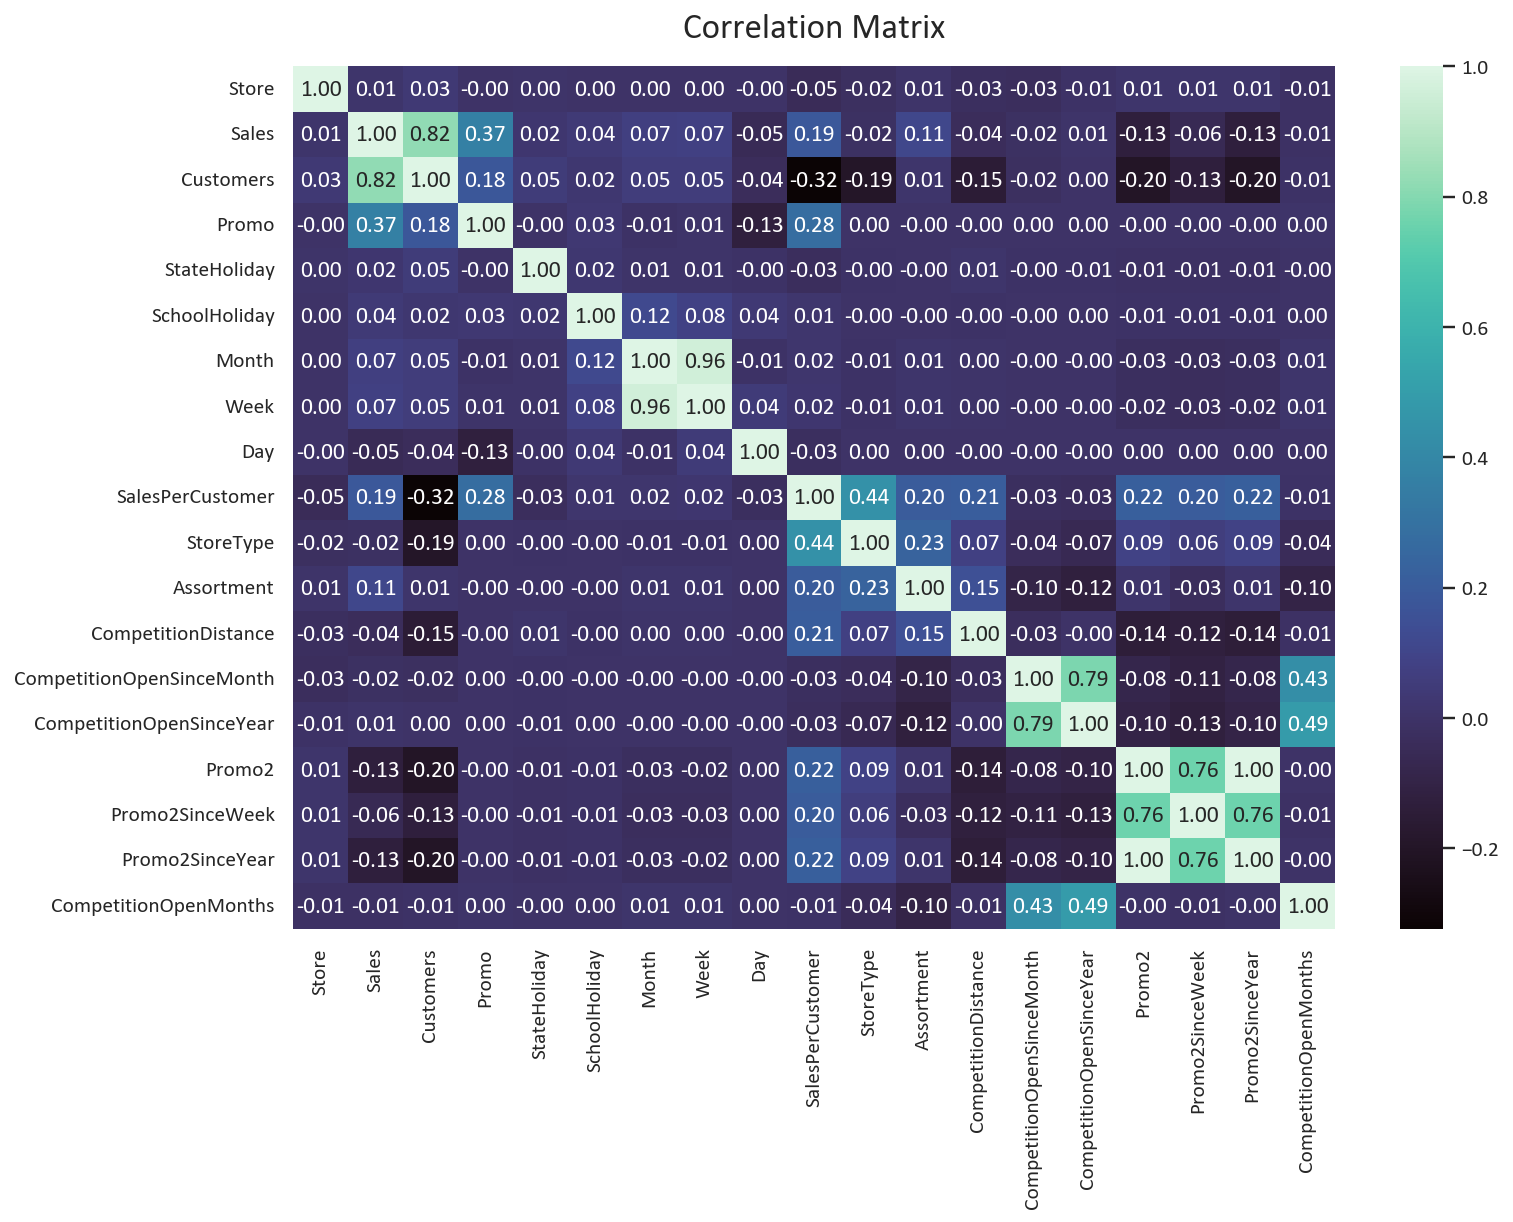

In [62]:
# Plot the coorelation matrix of the data
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='mako', fmt='.2f')
plt.title('Correlation Matrix')

The competition distance has a negative correlation with the sales and customers columns. This means that the closer the competition is, the higher the sales and customers. 

This is strange, as we would expect the opposite. One explanation for this is that the stores are located in cities, where there is a lot of people and a lot of competition. We should explore this further.

We also notice that the CompetitionOpenMonths, CompetitionOpenSinceYear, and CompetitionOpenSinceMonth columns have no significant correlation with the sales and customers columns. This means that the time the competition opened has no significant effect on the sales and customers. We can drop these columns.

The same applies to the Promo2SinceWeek and Promo2SinceYear columns, we can drop them.

In [63]:
# Drop the CompetitionOpenSinceMonth, CompetitionOpenSinceYear, and CompetitionOpenMonths columns
df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'CompetitionOpenMonths'], axis=1, inplace=True)

In [64]:
# Drop the Promo2SinceWeek and Promo2SinceYear columns
df.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace=True) 

In [65]:
# Inspect the CompetitionDistance column
df['CompetitionDistance'].describe(), df['CompetitionDistance'].value_counts()

(count    844340.000000
 mean       5458.008153
 std        7799.451383
 min          20.000000
 25%         710.000000
 50%        2330.000000
 75%        6880.000000
 max       75860.000000
 Name: CompetitionDistance, dtype: float64,
 CompetitionDistance
 250.0      9210
 50.0       6249
 350.0      6239
 1200.0     6069
 190.0      6066
            ... 
 2340.0      619
 10170.0     618
 9670.0      611
 17930.0     606
 1370.0      605
 Name: count, Length: 655, dtype: int64)

After exploring the data, a possible explanation for the negative correlation between the competition distance and the sales and customers columns is that the farther the competition is, the more likely the store is located in a rural area.

This means that there are less people and less competition, which leads to lower sales and customers.

We should keep the competition distance column as it may be useful for our model.

Text(0.5, 1.0, 'Correlation Matrix')

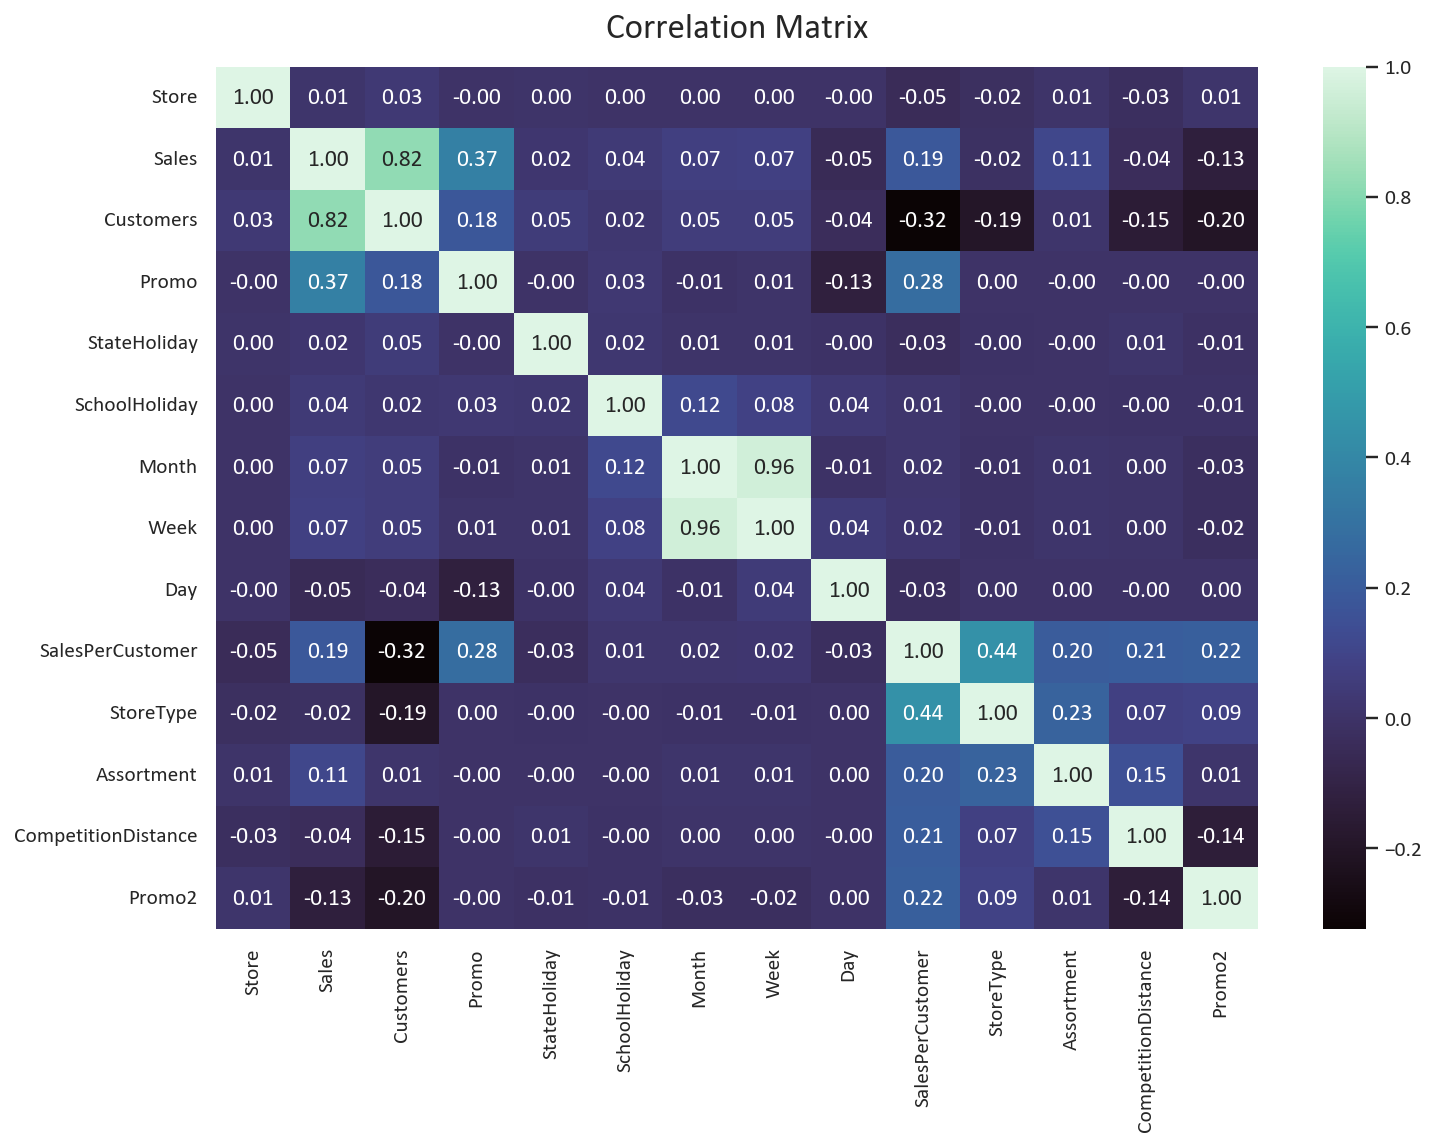

In [66]:
# Plot the coorelation matrix of the data again
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='mako', fmt='.2f')
plt.title('Correlation Matrix')

These features look reasonable, let's move on to the next step.

## 3. Data Analysis and Data Visualization

In [67]:
# Check the skewness of the Sales, Customers, and SalesPerCustomer columns
print('Skewness of Sales: ', df['Sales'].skew())
print('Skewness of Customers: ', df['Customers'].skew())
print('Skewness of SalesPerCustomer: ', df['SalesPerCustomer'].skew())
# Check the kurtosis of the Sales, Customers, and SalesPerCustomer columns
print('Kurtosis of Sales: ', df['Sales'].kurt())
print('Kurtosis of Customers: ', df['Customers'].kurt())
print('Kurtosis of SalesPerCustomer: ', df['SalesPerCustomer'].kurt())


Skewness of Sales:  1.594891526556365
Skewness of Customers:  2.789027509620191
Skewness of SalesPerCustomer:  0.592159884112242
Kurtosis of Sales:  4.853951932461696
Kurtosis of Customers:  13.317902861755178
Kurtosis of SalesPerCustomer:  2.7593910840541587


Based on the Skewness of the data, we can see that the sales and customers data are skewed to the right, while the sales per customer data is closer to the normal distribution.

As for Kurtosis, we can see that the customers data has the highest Kurtosis, which means that it has the most outliers. The sales data is next, while the sales per customer data has the lowest Kurtosis. 

This means that the sales per customer data is the closest to the normal distribution.

In [68]:
# Define a function that plots the KDE plot of the Sales, Customers, and SalesPerCustomer columns
# based on the Column
def plot_kde(df, col):
    plt.figure(figsize=(12, 16))
    plt.subplot(3, 1, 1)
    sns.kdeplot(data=df, x='Sales', hue = col, fill=True, palette='Set2')
    plt.title('Sales')
    plt.subplot(3, 1, 2)
    sns.kdeplot(data=df, x='Customers', hue = col, fill=True, palette='Set2')
    plt.title('Customers')
    plt.subplot(3, 1, 3)
    sns.kdeplot(data=df, x='SalesPerCustomer', hue = col, fill=True, palette='Set2')
    plt.title('SalesPerCustomer')
    plt.tight_layout()

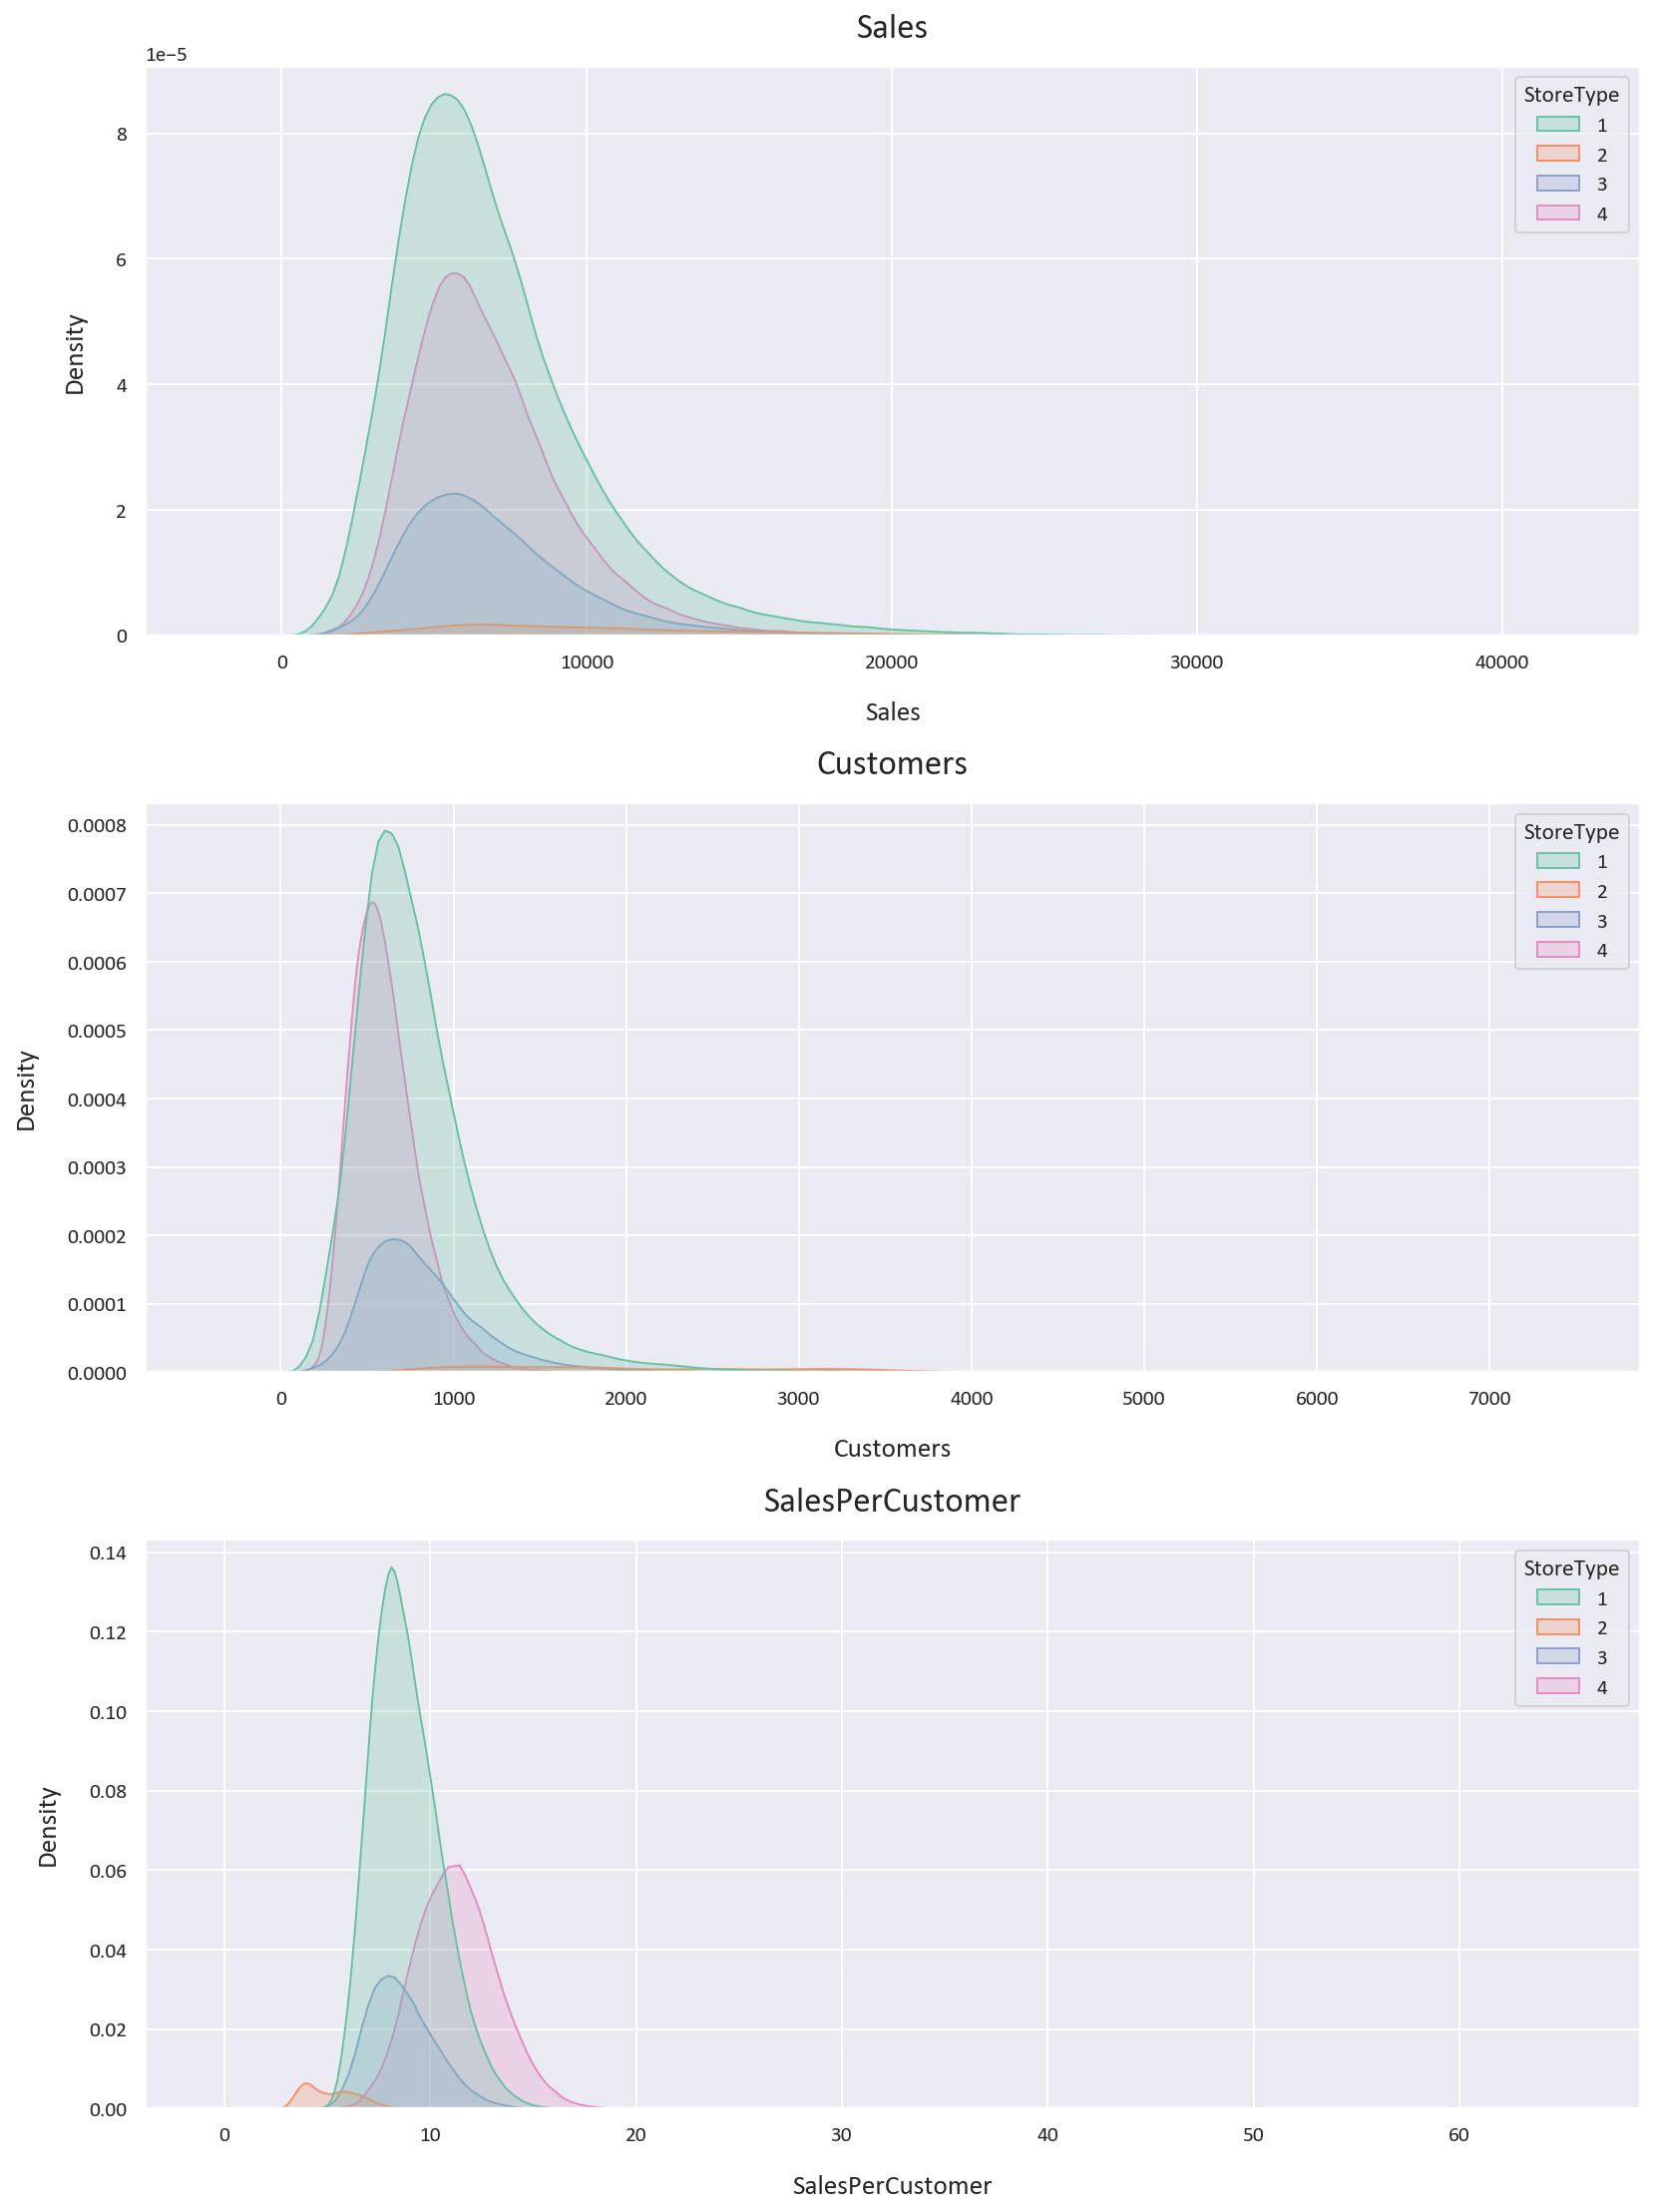

In [69]:
# Plot the KDE plots based on the StoreType
plot_kde(df, 'StoreType')

The KDE plot confirms our previous findings, with the sales and customers data being skewed to the right, while the sales per customer data is closer to the normal distribution. We also notice that the storetype 1 is the most dense of the storetypes, and that storetype 2 is the least dense of the storetypes.

How many stores are there for each storetype?

In [70]:
# How many stores are there for each StoreType?
df['StoreType'].value_counts()

StoreType
1    457043
4    258768
3    112968
2     15561
Name: count, dtype: int64

As we observed in the KDE plot, storetype 1 is the most common storetype, while storetype 2 is the least common storetype.

Let's plot a Violin Plot to get a better understanding of the data.

In [71]:
# Define a function that plots the Violinplot of the Sales, Customers, and SalesPerCustomer columns based on the Column
def plot_violinplot(df, col):
    plt.figure(figsize=(12, 16))
    plt.subplot(3, 1, 1)
    sns.violinplot(data=df, x='Sales', hue=col, palette='Set2')
    plt.title('Sales')
    plt.subplot(3, 1, 2)
    sns.violinplot(data=df, x='Customers', hue=col, palette='Set2')
    plt.title('Customers')
    plt.subplot(3, 1, 3)
    sns.violinplot(data=df, x='SalesPerCustomer', hue=col, palette='Set2')
    plt.title('SalesPerCustomer')
    plt.tight_layout()

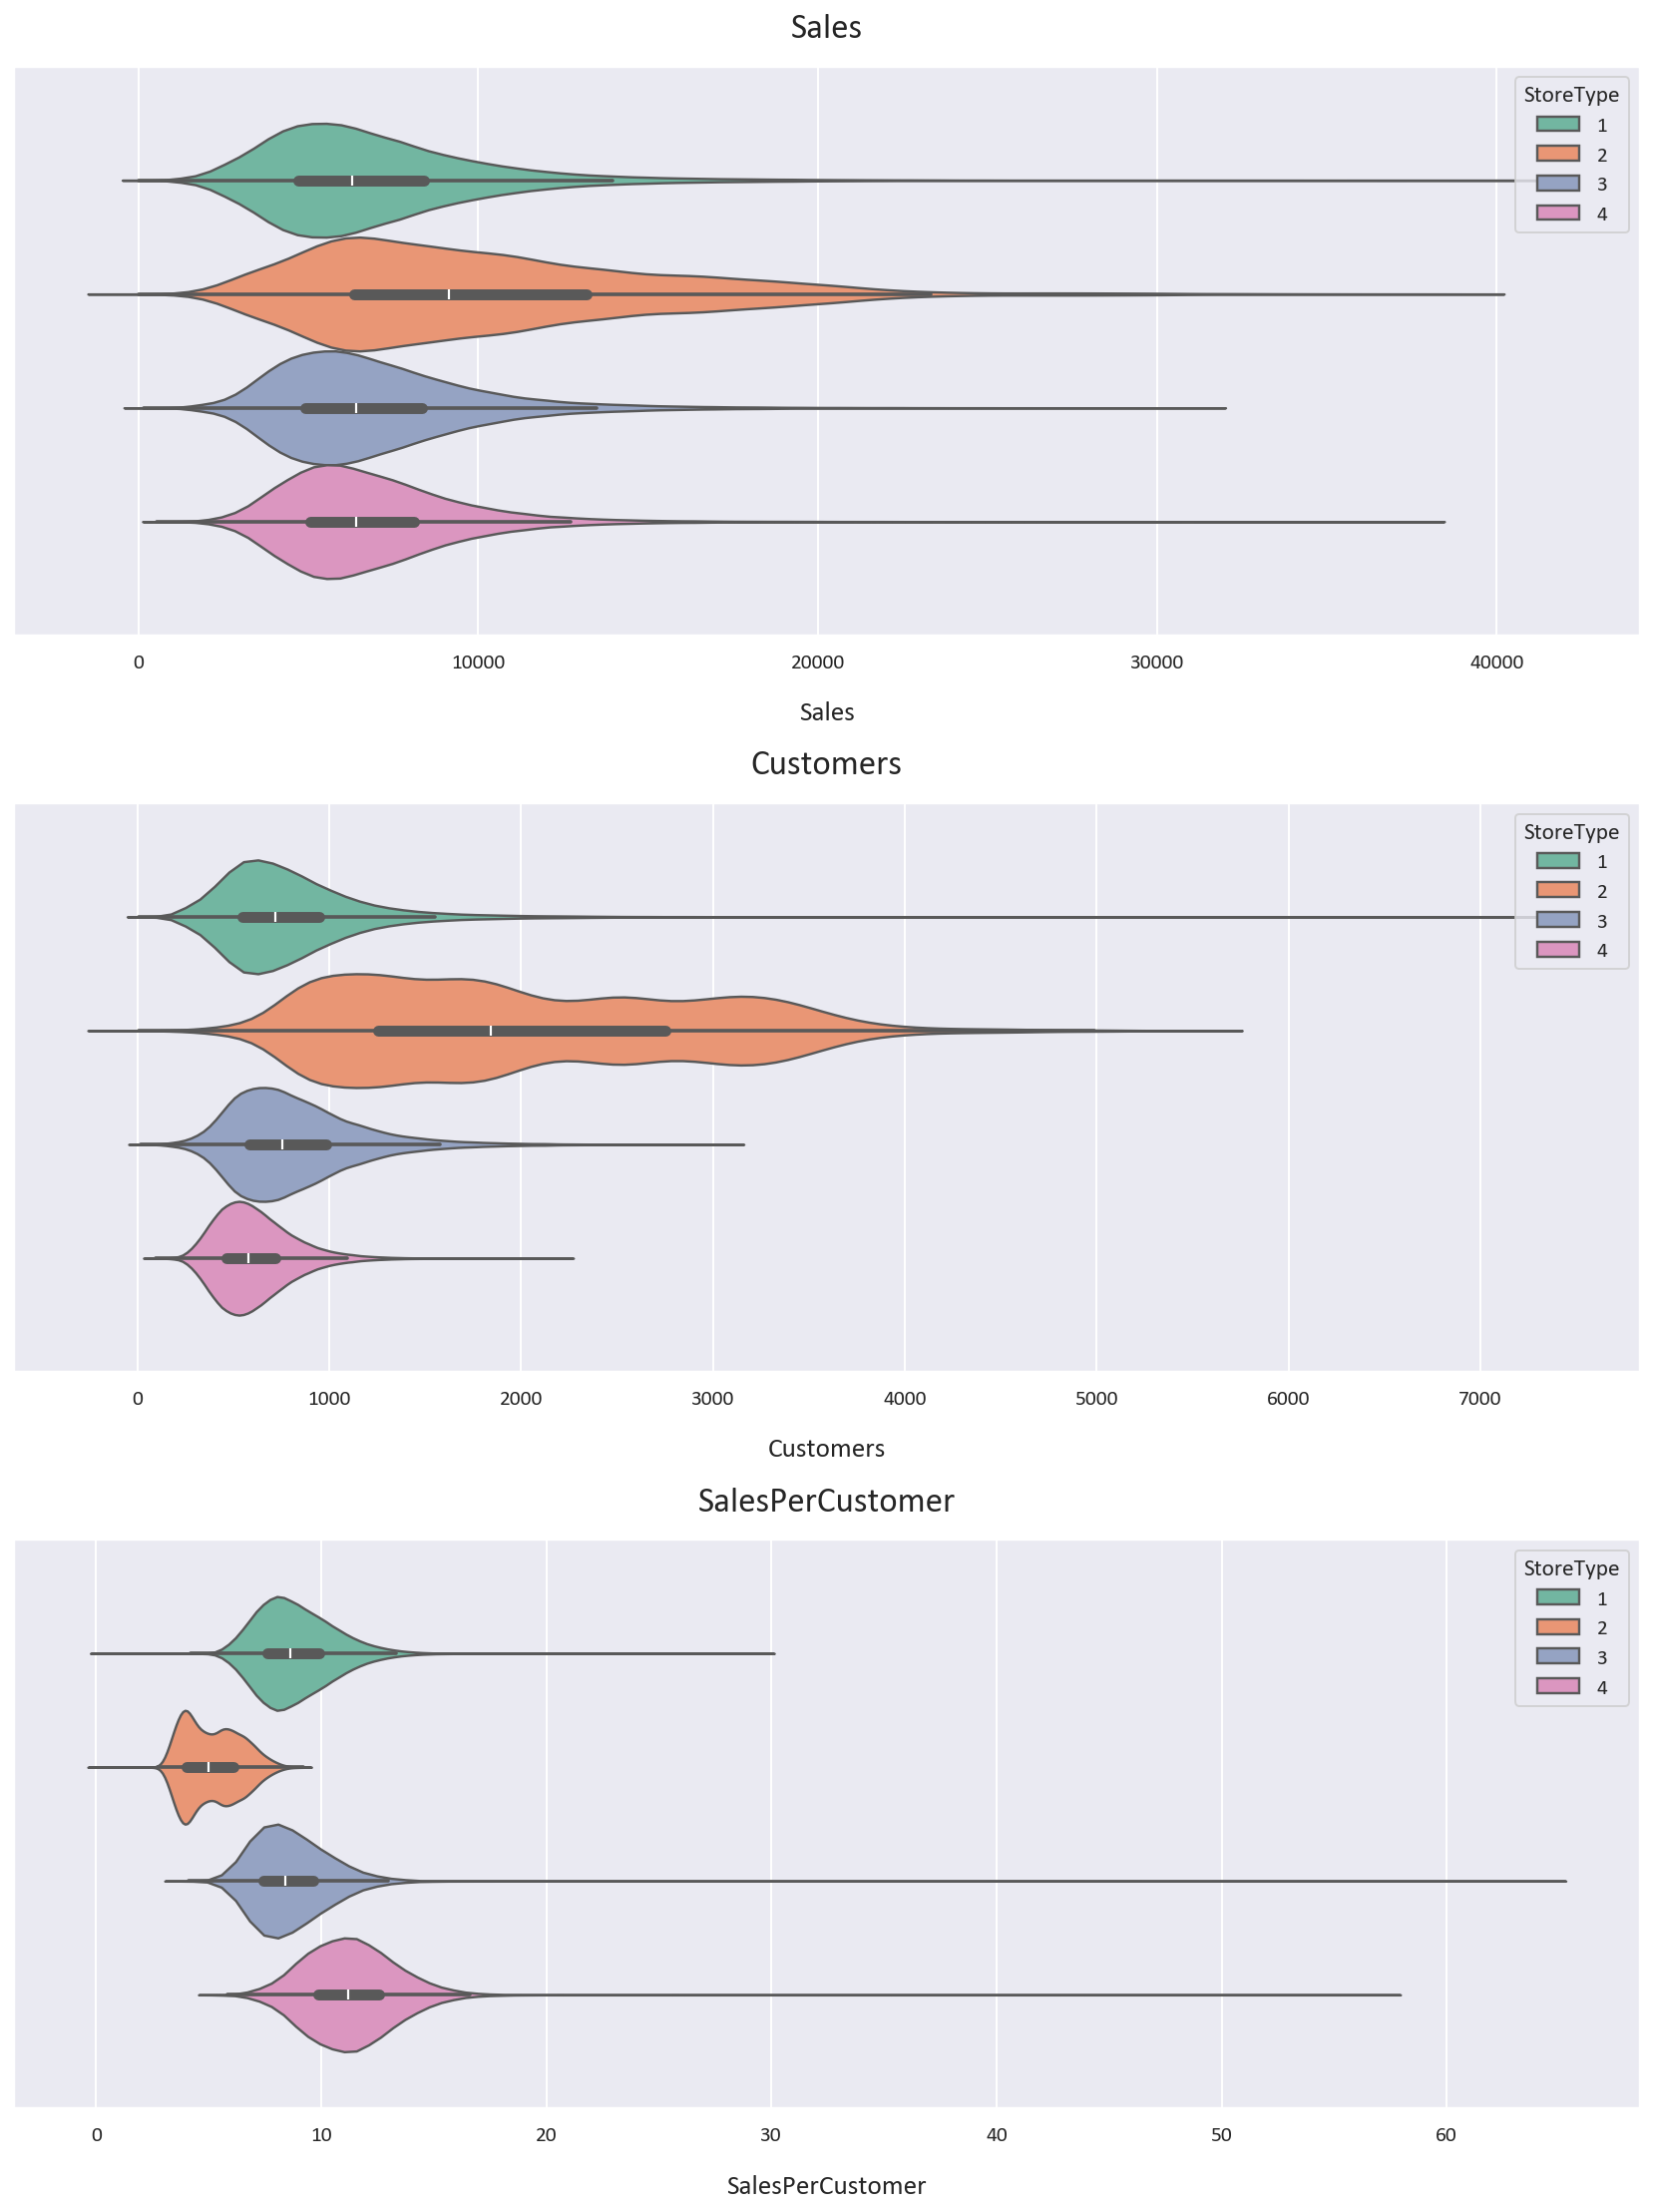

In [72]:
# Plot the Violin Plot of the Sales, Customers, and SalesPerCustomer columns
# based on the StoreType
plot_violinplot(df, 'StoreType')

In [73]:
# Inspect the statistics of each StoreType based on the Sales, Customers, and SalesPerCustomer columns
df.groupby('StoreType')[['Sales', 'Customers', 'SalesPerCustomer']].describe().T.style.format('{:.2f}')           

Based on the Violin Plot and the statistics, we notice some interesting points:
* Storetype 1 has more customers than storetype 4, but storetype 4 has more high-value customers, with the average customer paying 2.43 euros more than the average customer in storetype 1 and the median customer paying 2.56 euros more than the median customer in storetype 1.
* Storetype 2 has double the customers of the next highest storetype, but it has the least sales per customer, being almost half the sales per customer value of the next lowest value. It also has the highest average sales. Note that the data is scarce for storetype 2, so we should take this with a grain of salt.
* We also notice that storetype 2 is spread out the most, with the highest standard deviation for Sales and Customers, while storetype 4 is the least spread out, with the lowest standard deviation for Sales and Customers.


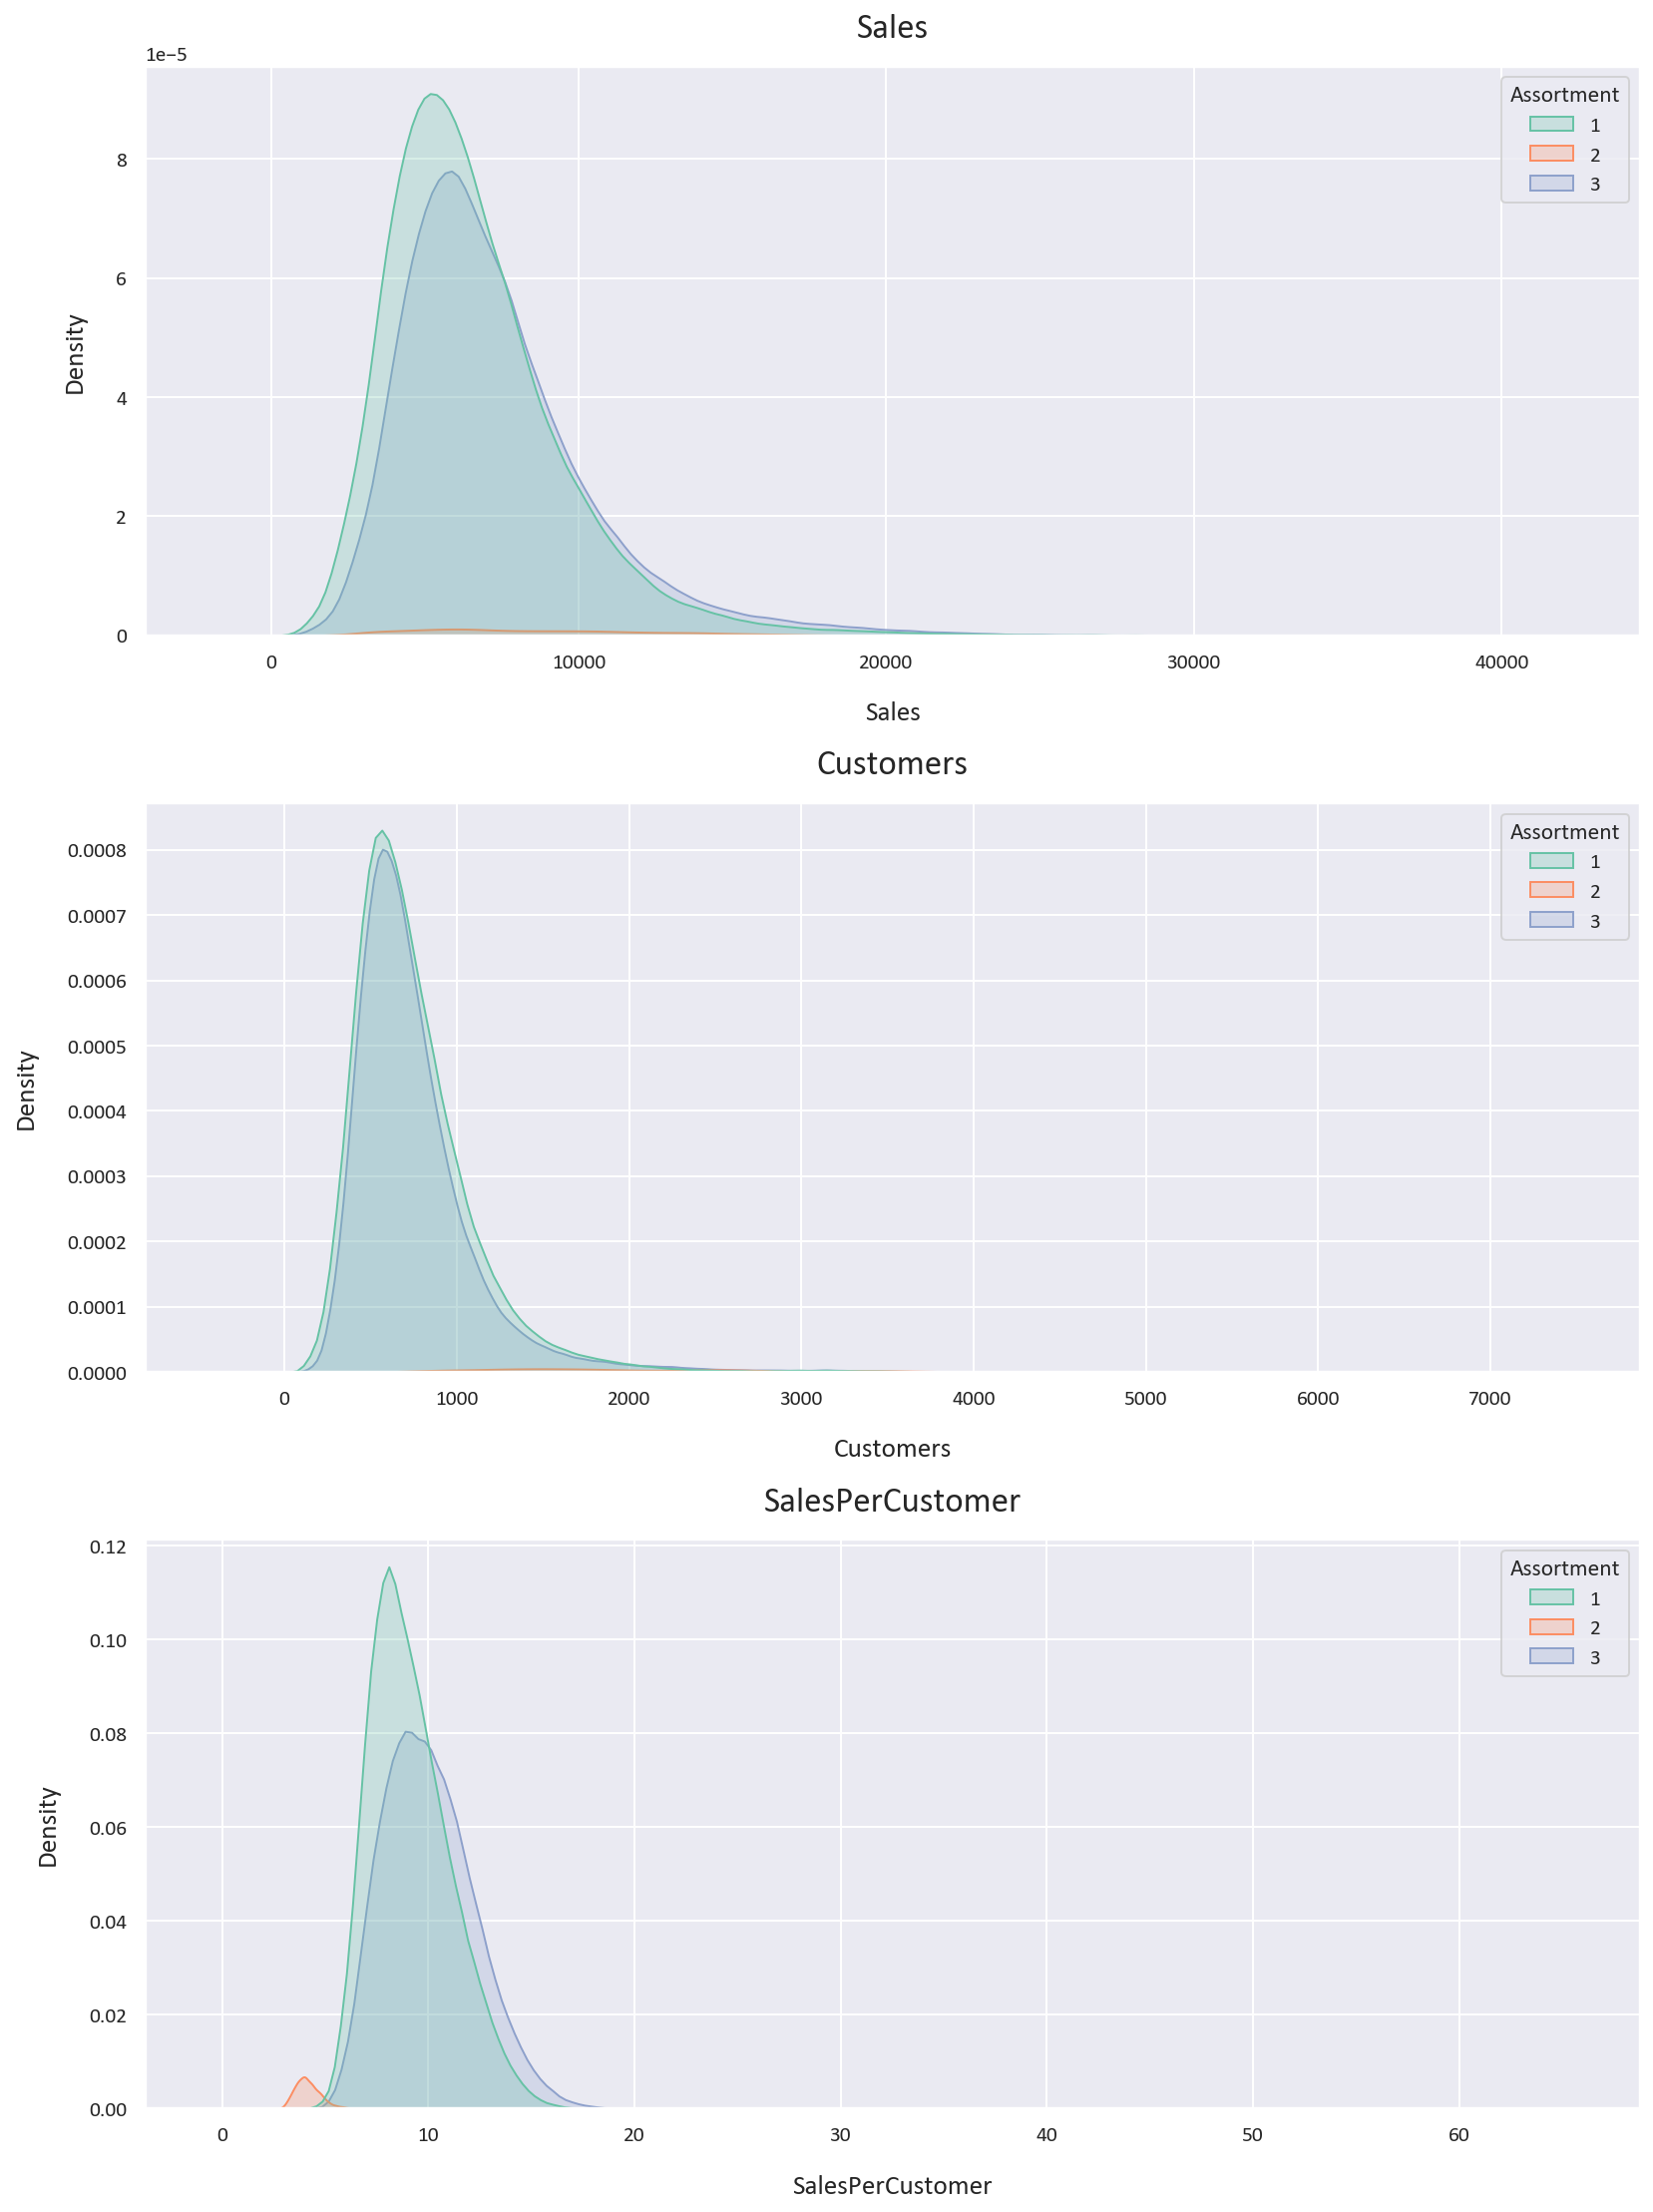

In [74]:
# Plot the KDE plot of the Sales, Customers, and SalesPerCustomer columns based on the Assortment
plot_kde(df, 'Assortment')

In [75]:
# How many stores are there for each Assortment?
df['Assortment'].value_counts()

Assortment
1    444876
3    391254
2      8210
Name: count, dtype: int64

We notice that the assortment type 2 has the least stores, while assortment type 1 has the most stores.

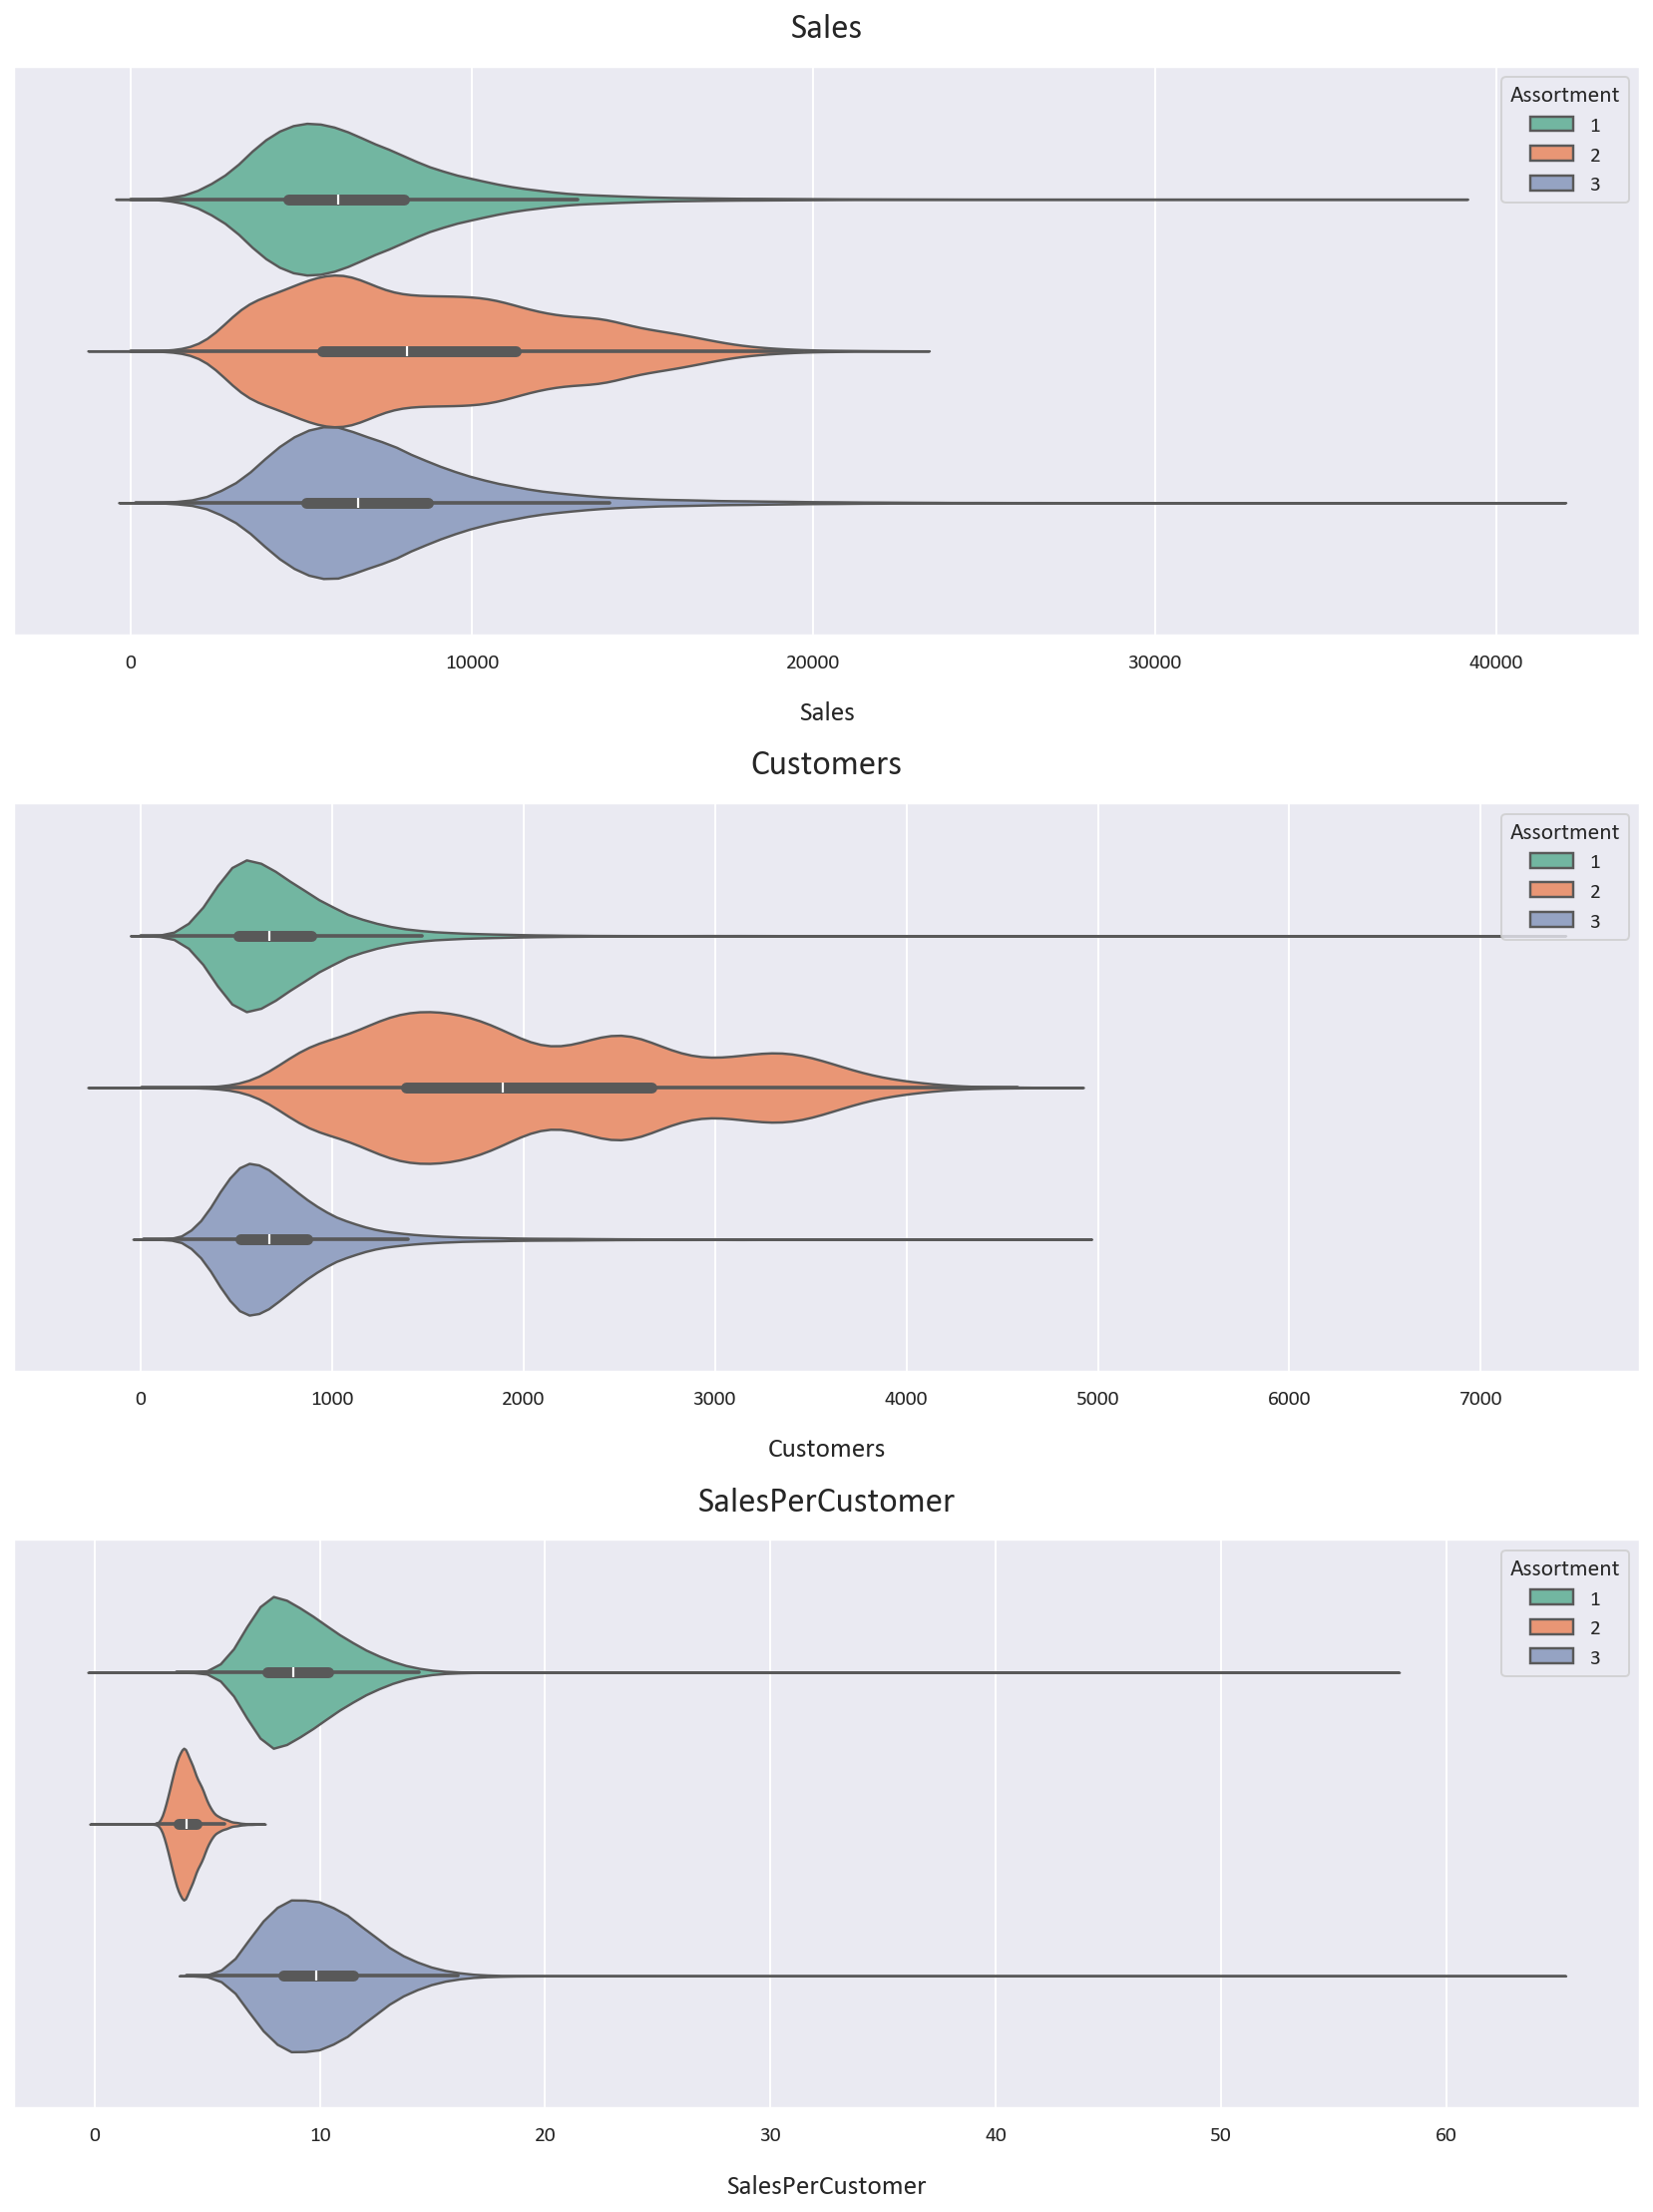

In [76]:
# Plot the Violin Plot of the Sales, Customers, and SalesPerCustomer columns
# based on the Assortment
plot_violinplot(df, 'Assortment')

In [77]:
# Inspect the statistics of each Assortment based on the Sales, Customers, and SalesPerCustomer columns
df.groupby('Assortment')[['Sales', 'Customers', 'SalesPerCustomer']].describe().T.style.format('{:.2f}')

Here are some interesting findings:
* Assortment type 2 has the most average and median sales and customers. It also has the least average and median sales per customer, being less than half of the other 2 assortments. This means that the customers in assortment type 2 spend less money than the customers in the other 2 assortments. It also is the most spread out, with the highest standard deviation for Sales and Customers. The data is also scarce for assortment type 2, so we should take these findings with a grain of salt as well.
* Assortment type 3 has more average and median sales, customers, and sales per customer than assortment type 1. It seems that assortment type 3 is the most profitable assortment, ignoring assortment type 2 as the data is less than 1% of the total data. This could be because assortment type 3 has the most products, so it has the most variety for the customers to choose from.

Let's now look at how the month, promo, and promo2 features affect the sales, customers, and sales per customer for each storetype and assortment type.

<Figure size 2240x1400 with 0 Axes>

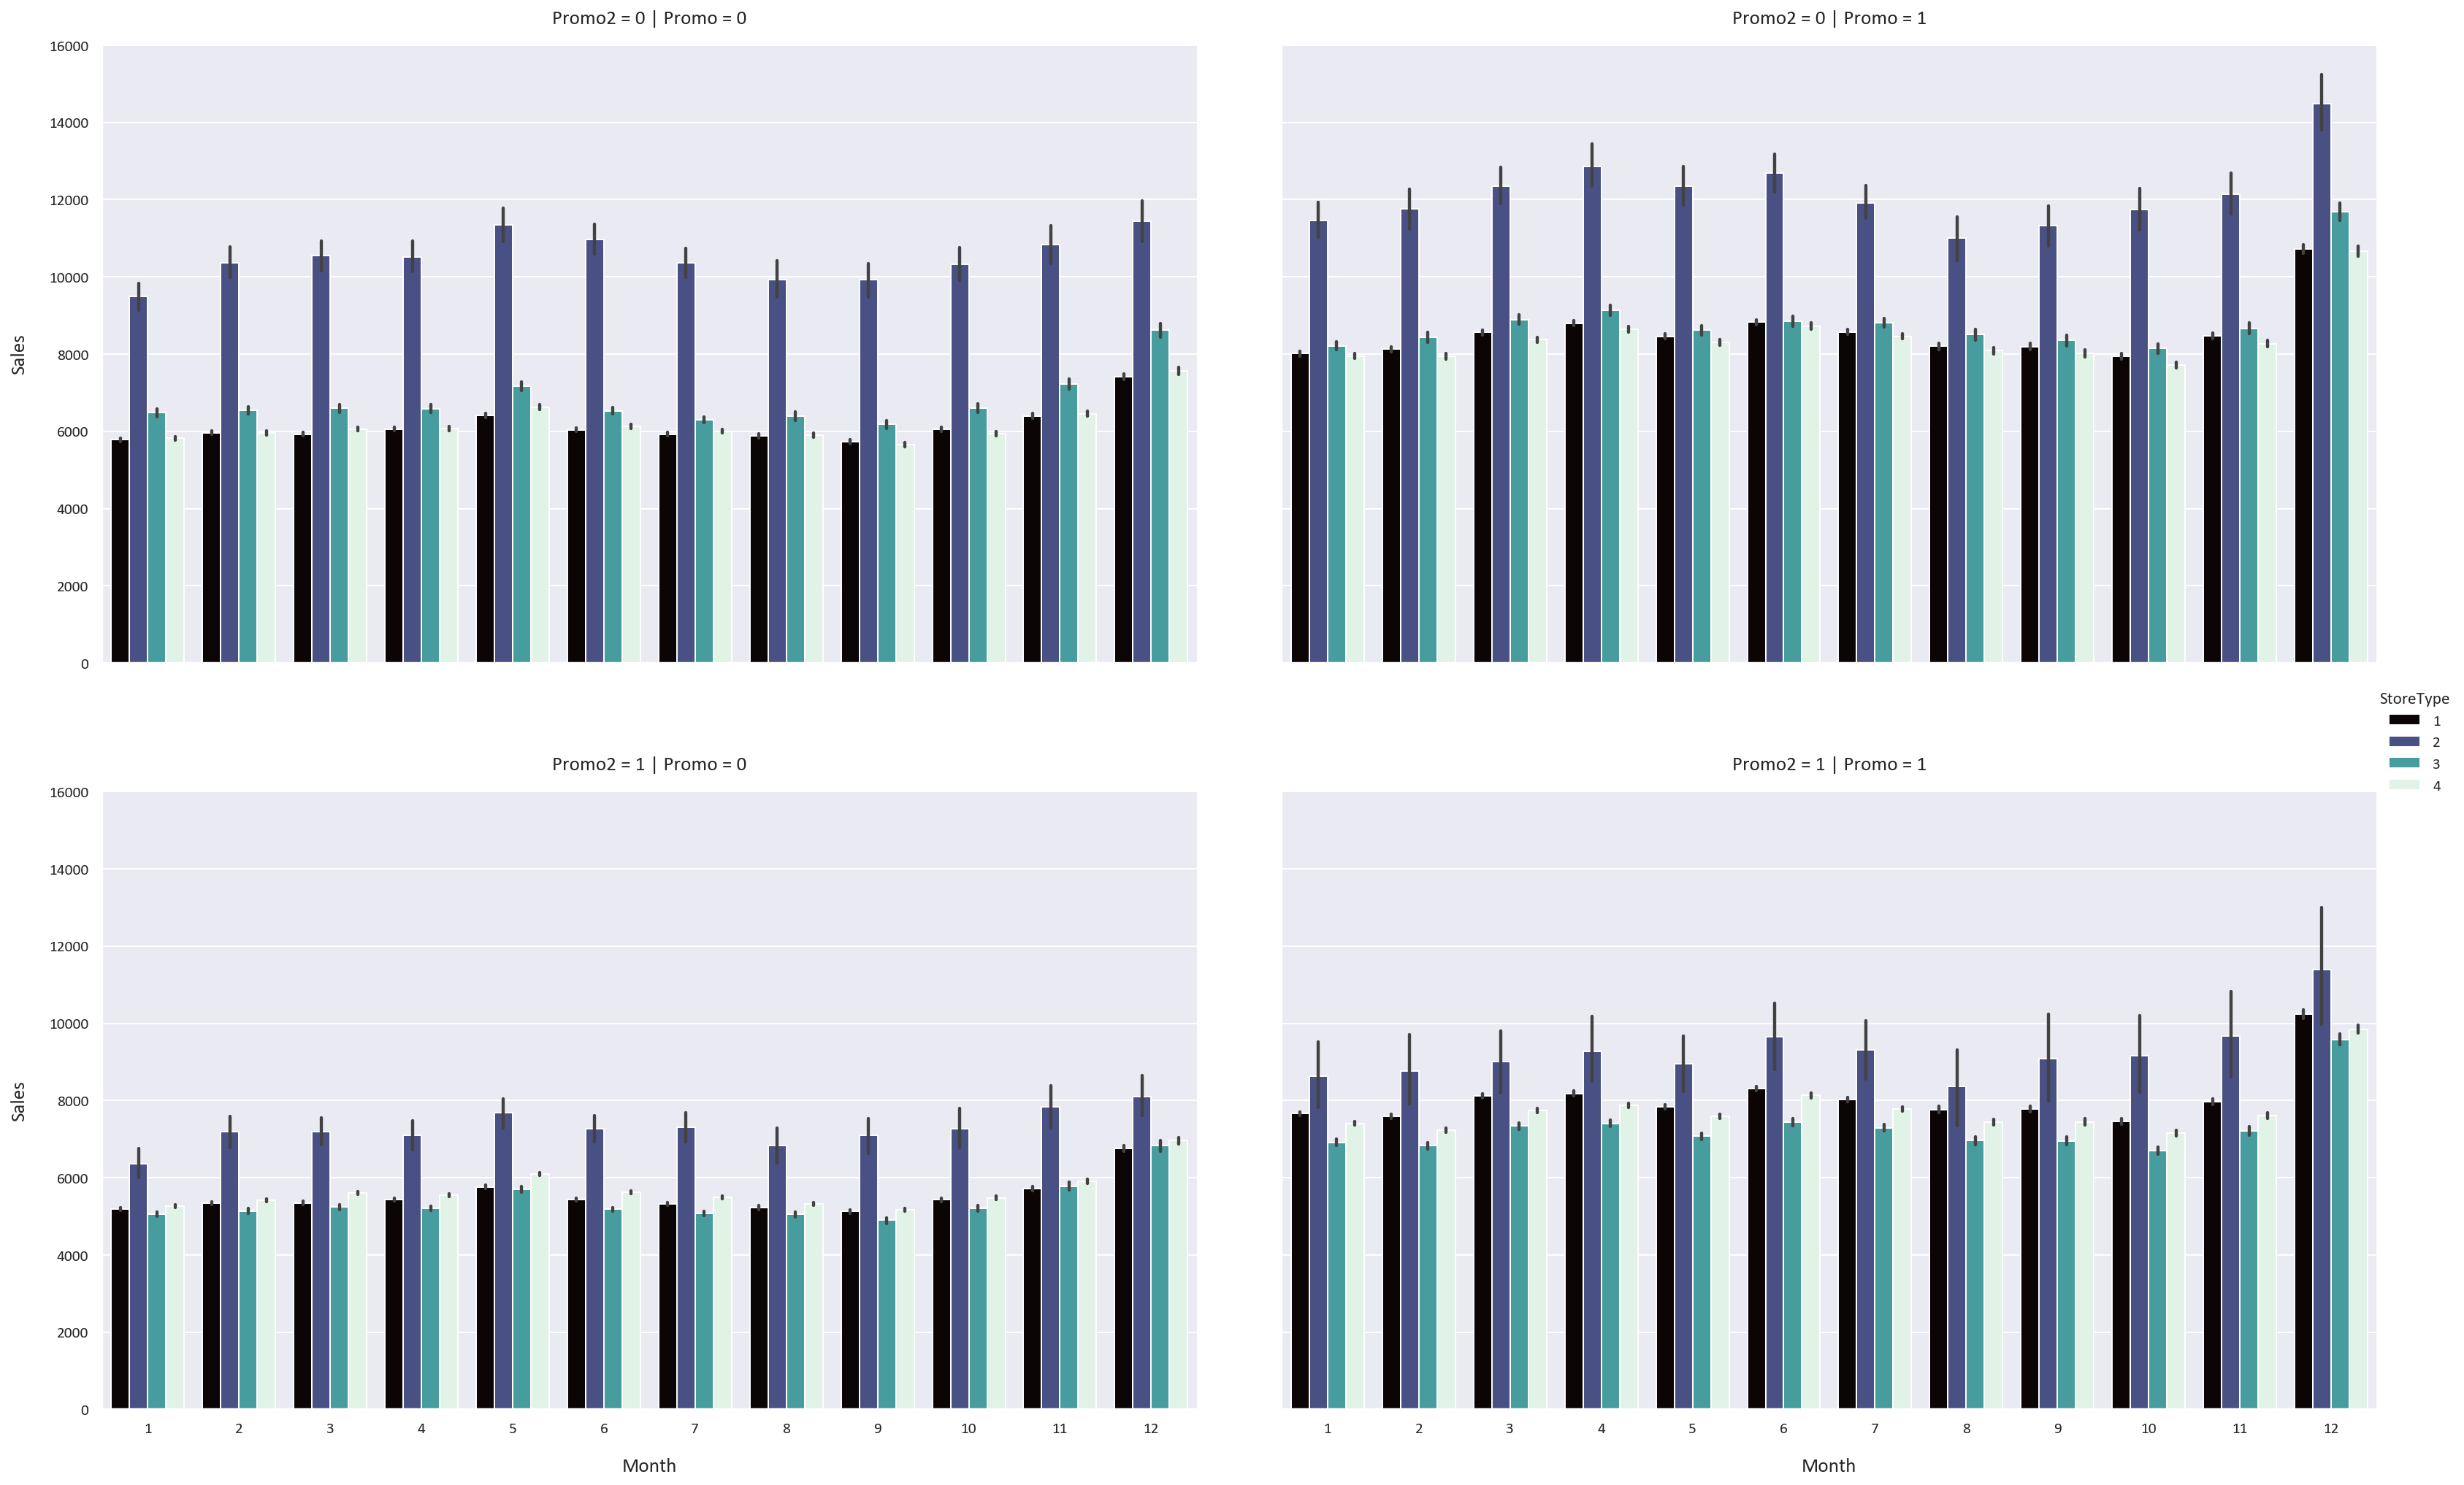

In [78]:
# Plot a Catplot of the Monthly Sales based on the StoreType, Promo, and Promo2 columns
plt.figure(figsize=(16, 10))
sns.catplot(data=df, x='Month', y='Sales', hue='StoreType', kind='bar', col='Promo', row='Promo2', height=8, aspect=1.5, palette='mako')
plt.tight_layout(pad=5)

<Figure size 2240x1400 with 0 Axes>

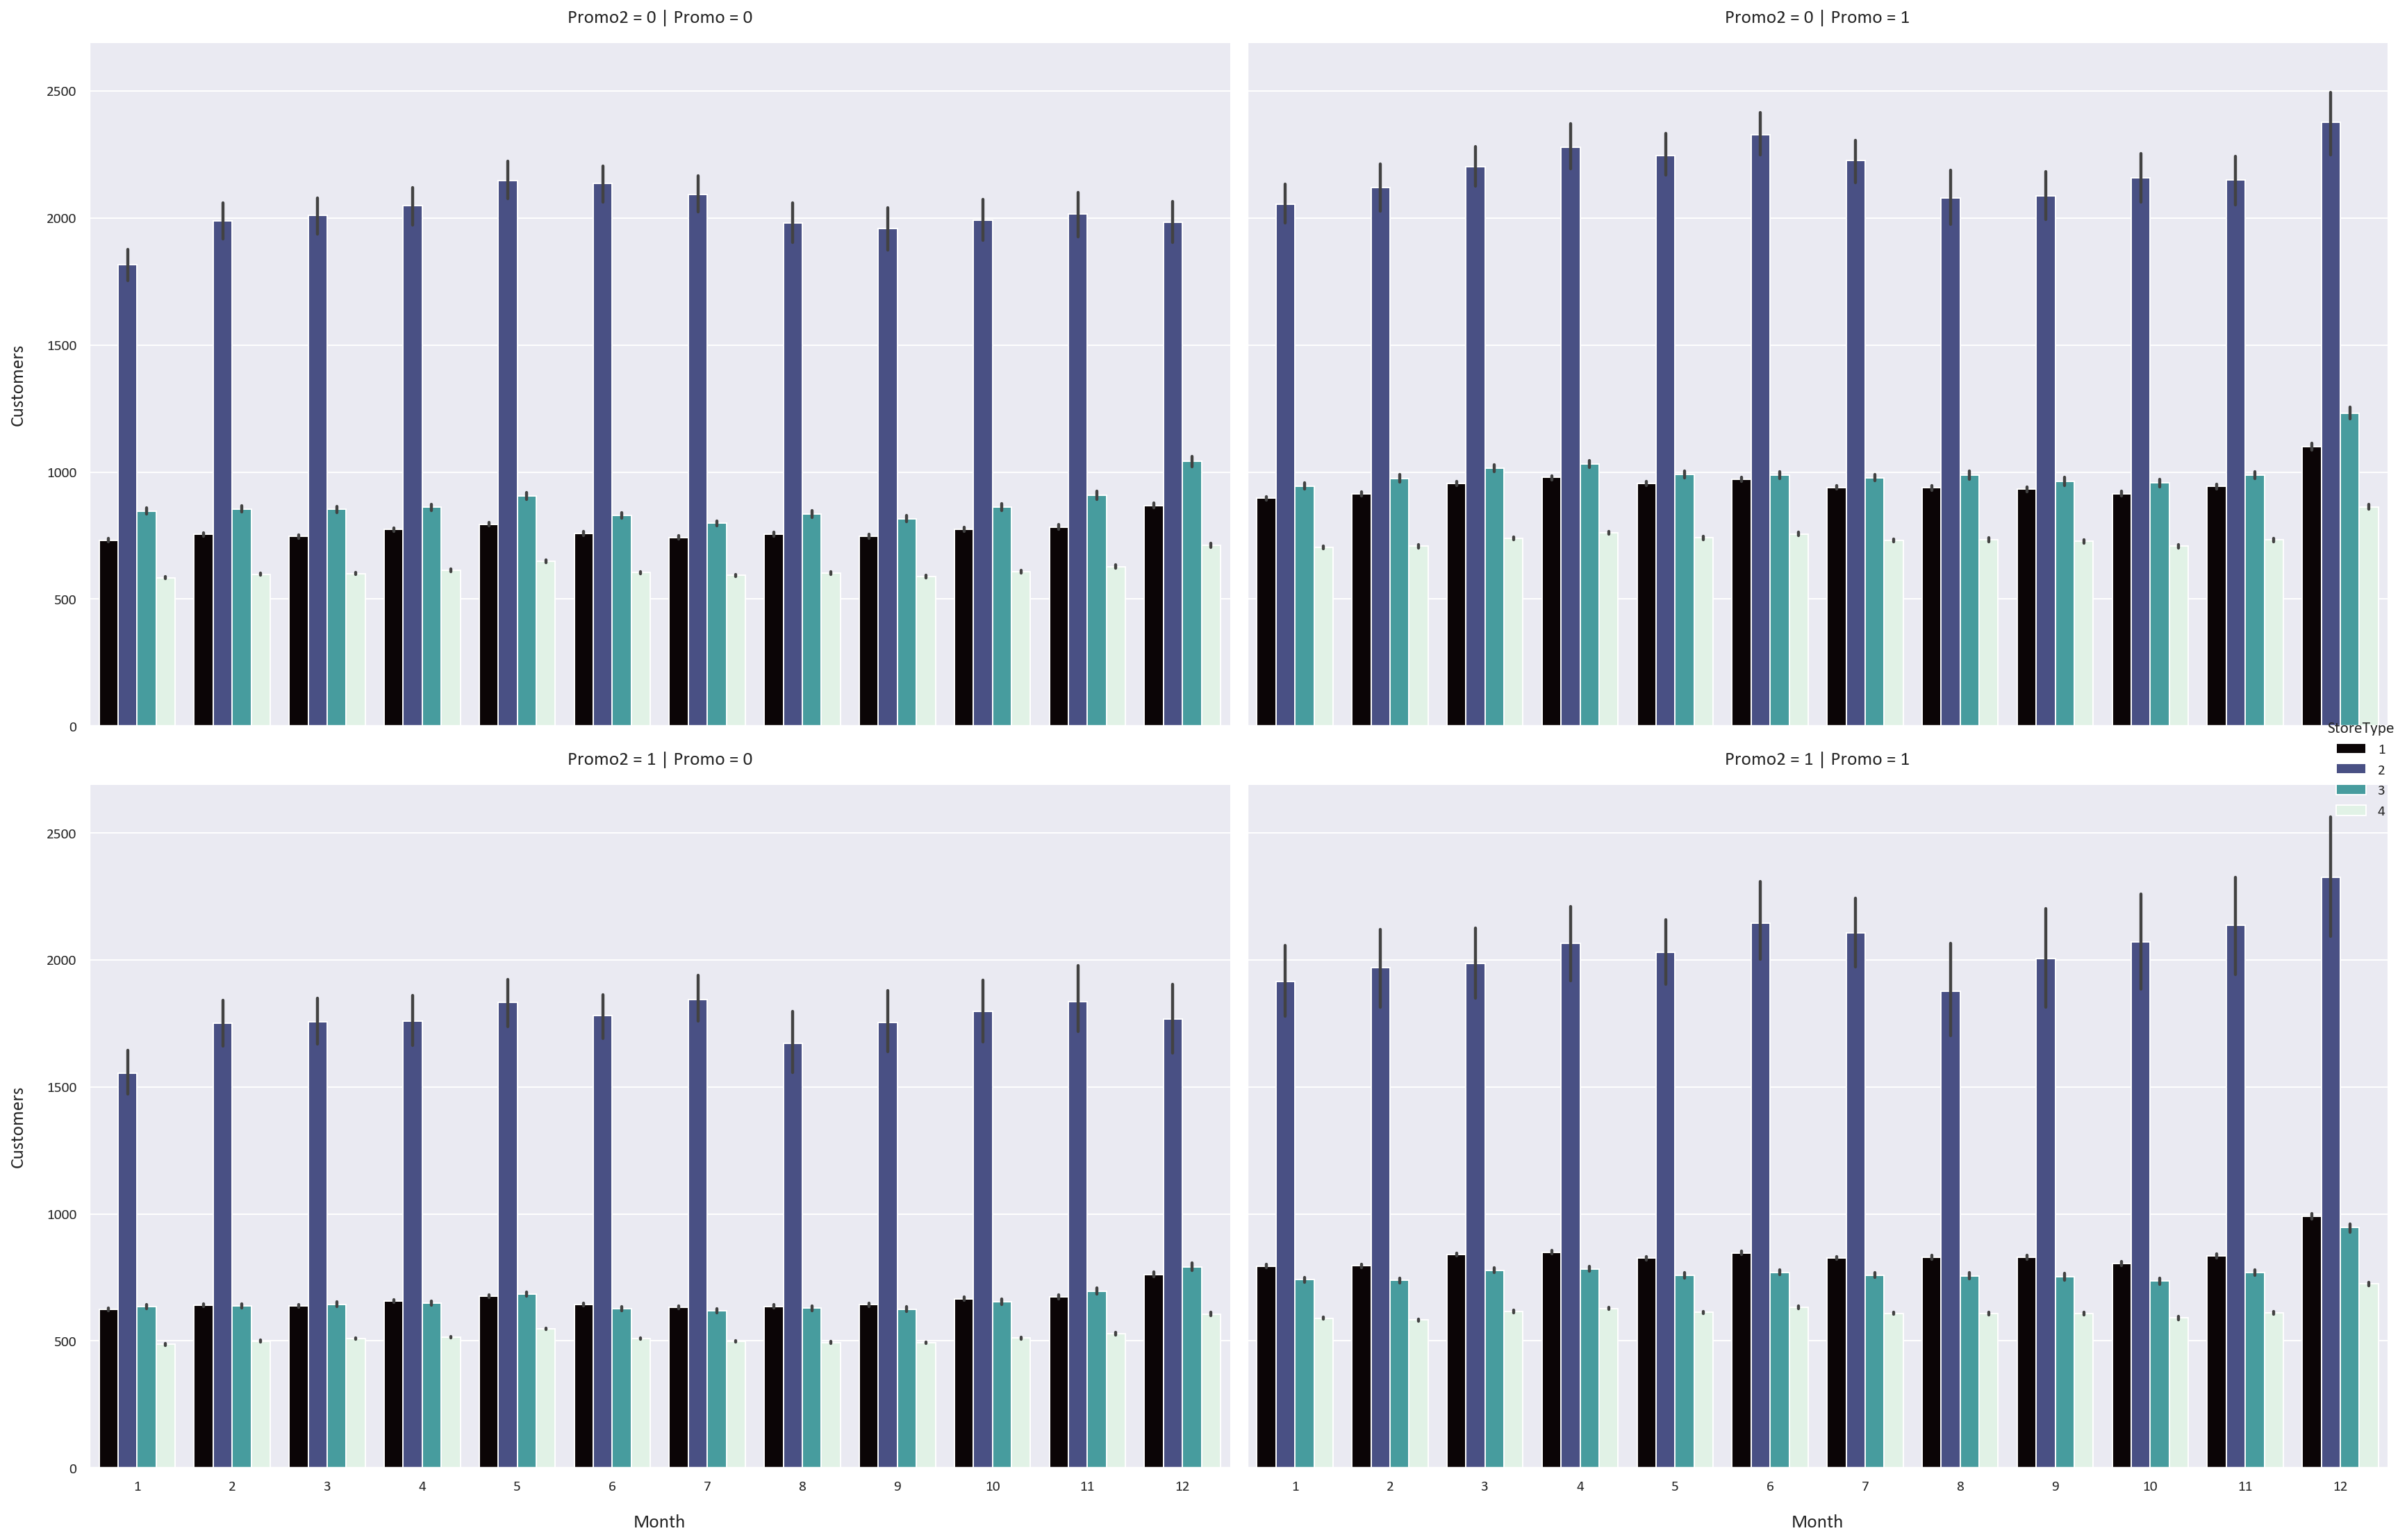

In [79]:
# Plot a Catplot of the Monthly Customers based on the StoreType, Promo, and Promo2 columns
plt.figure(figsize=(16, 10))
sns.catplot(data=df, x='Month', y='Customers', hue='StoreType', kind='bar', col='Promo', row='Promo2', height=8, aspect=1.5, palette='mako')
plt.tight_layout()

<Figure size 2240x1400 with 0 Axes>

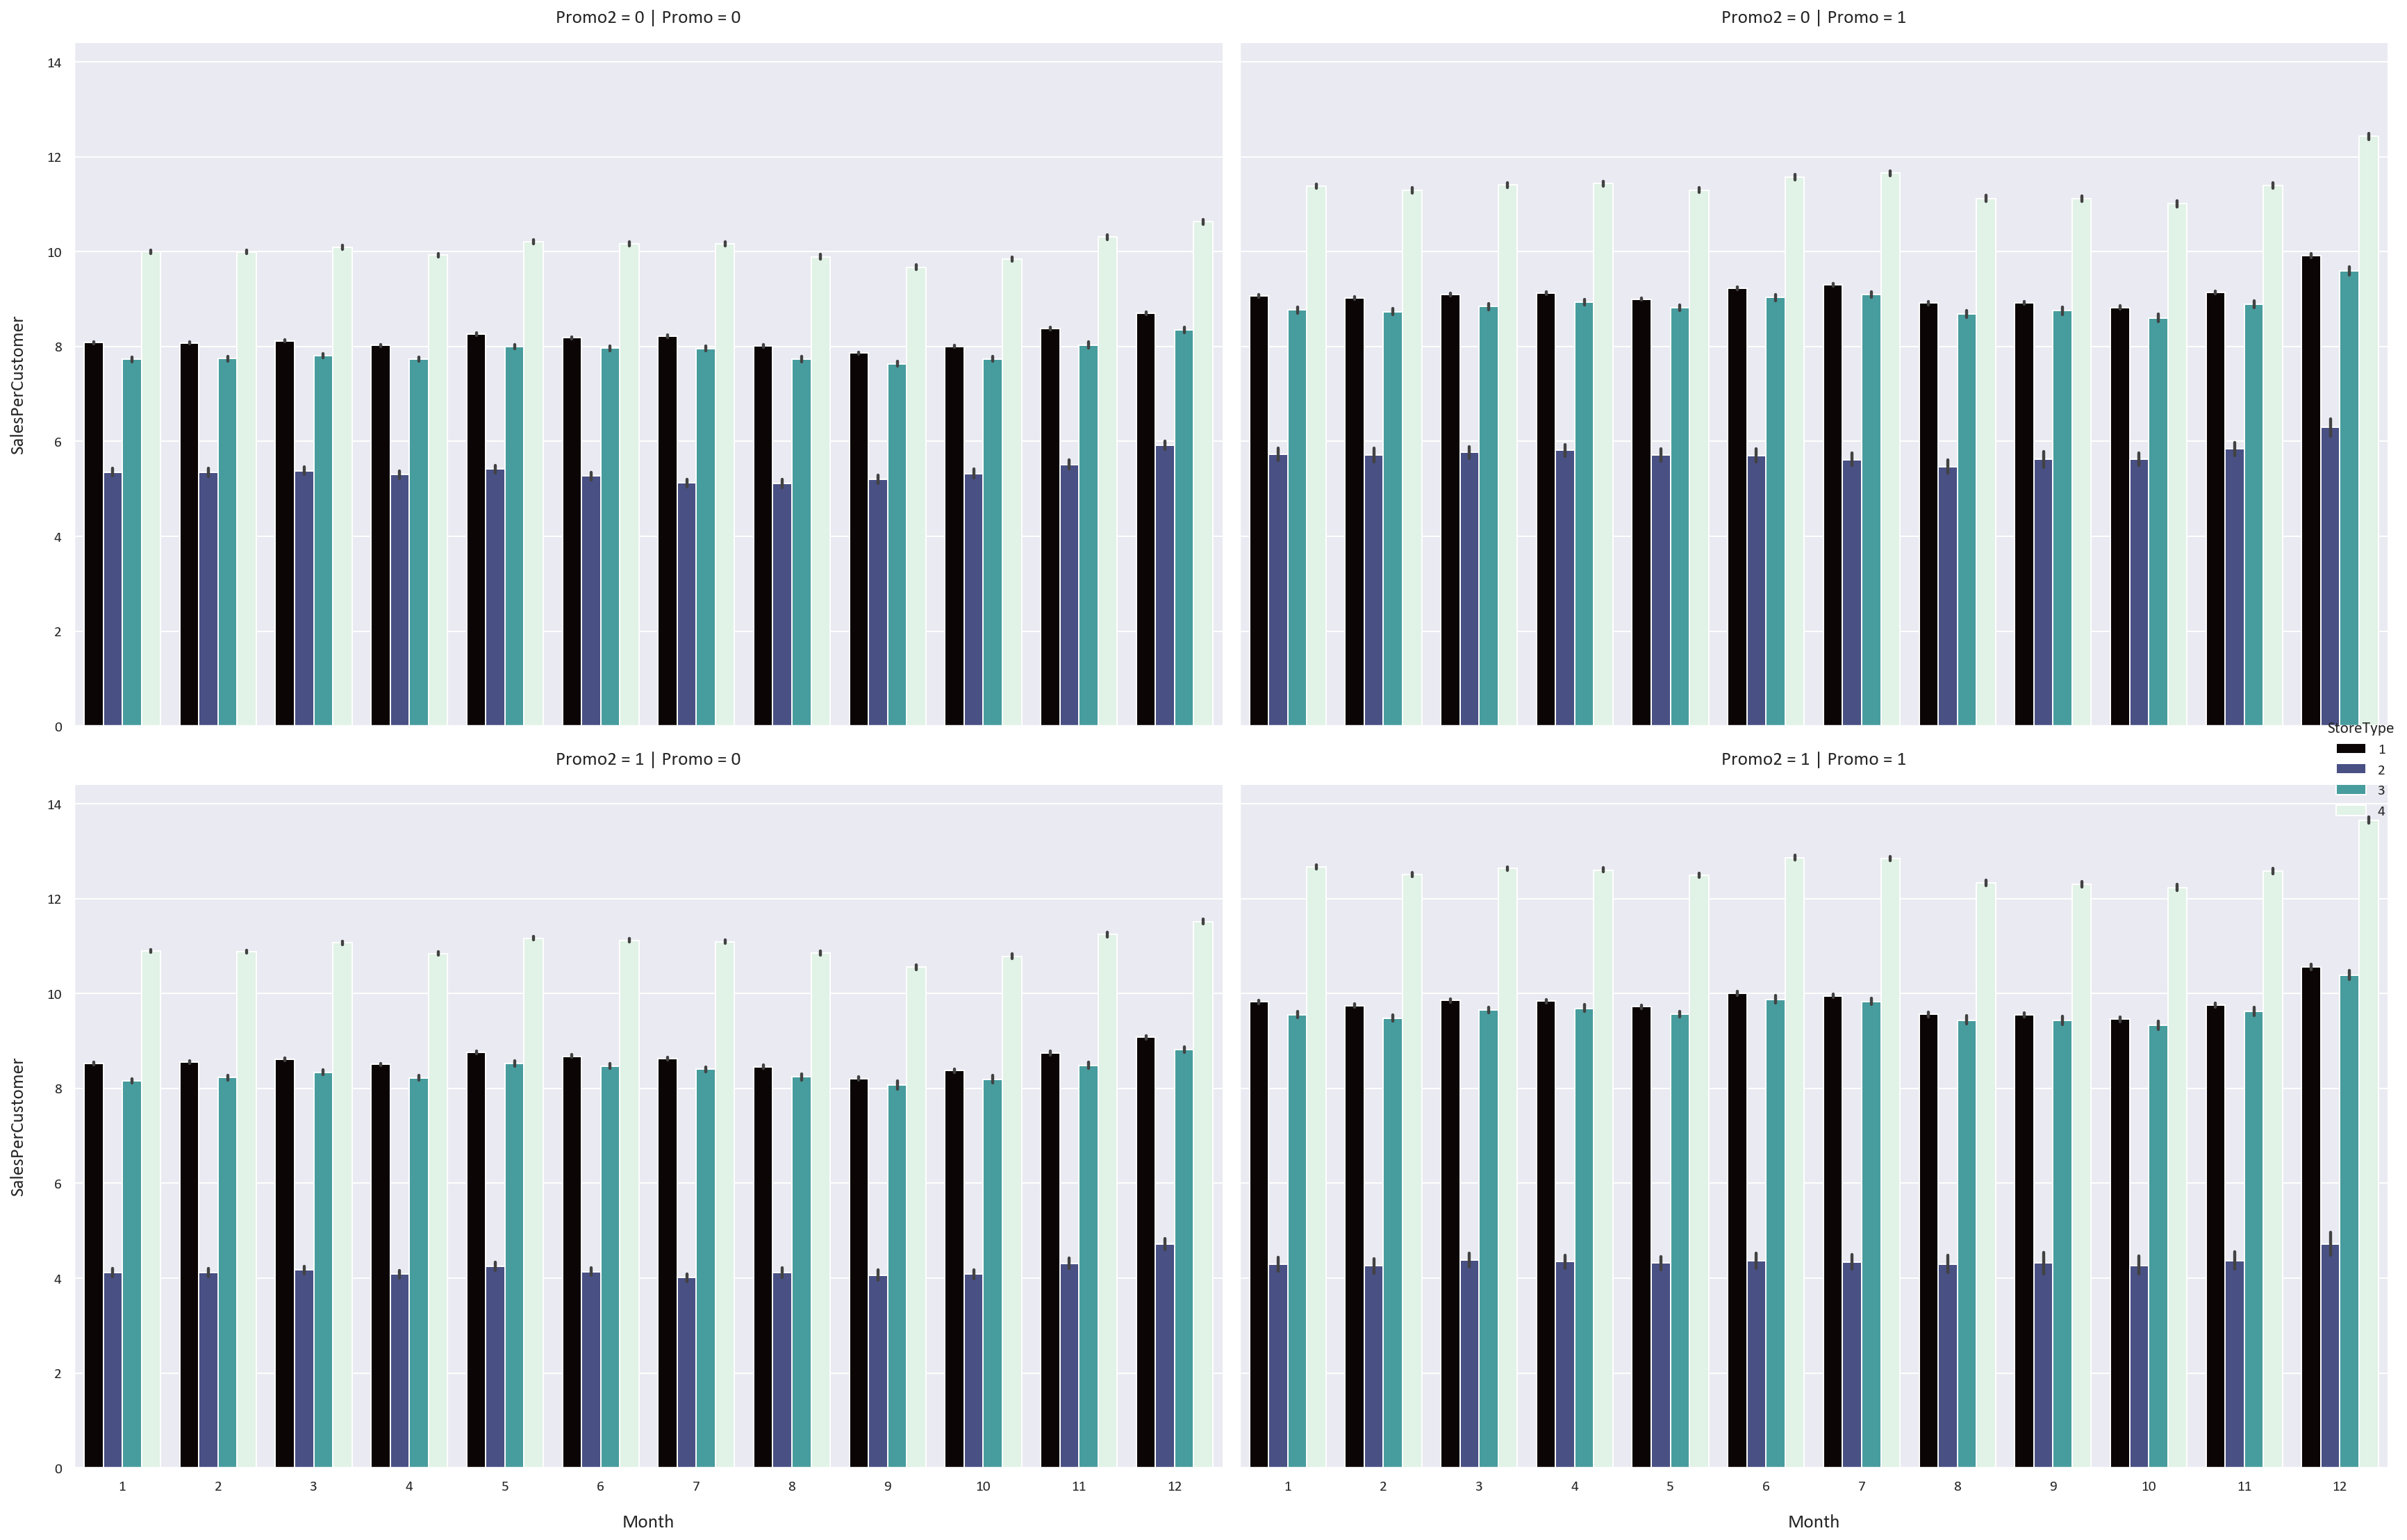

In [80]:
# Plot a Catplot of the Monthly SalesPerCustomer based on the StoreType, Promo, and Promo2 columns
plt.figure(figsize=(16, 10))
sns.catplot(data=df, x='Month', y='SalesPerCustomer', hue='StoreType', kind='bar', col='Promo', row='Promo2', height=8, aspect=1.5, palette='mako')
plt.tight_layout()

<Figure size 2240x1400 with 0 Axes>

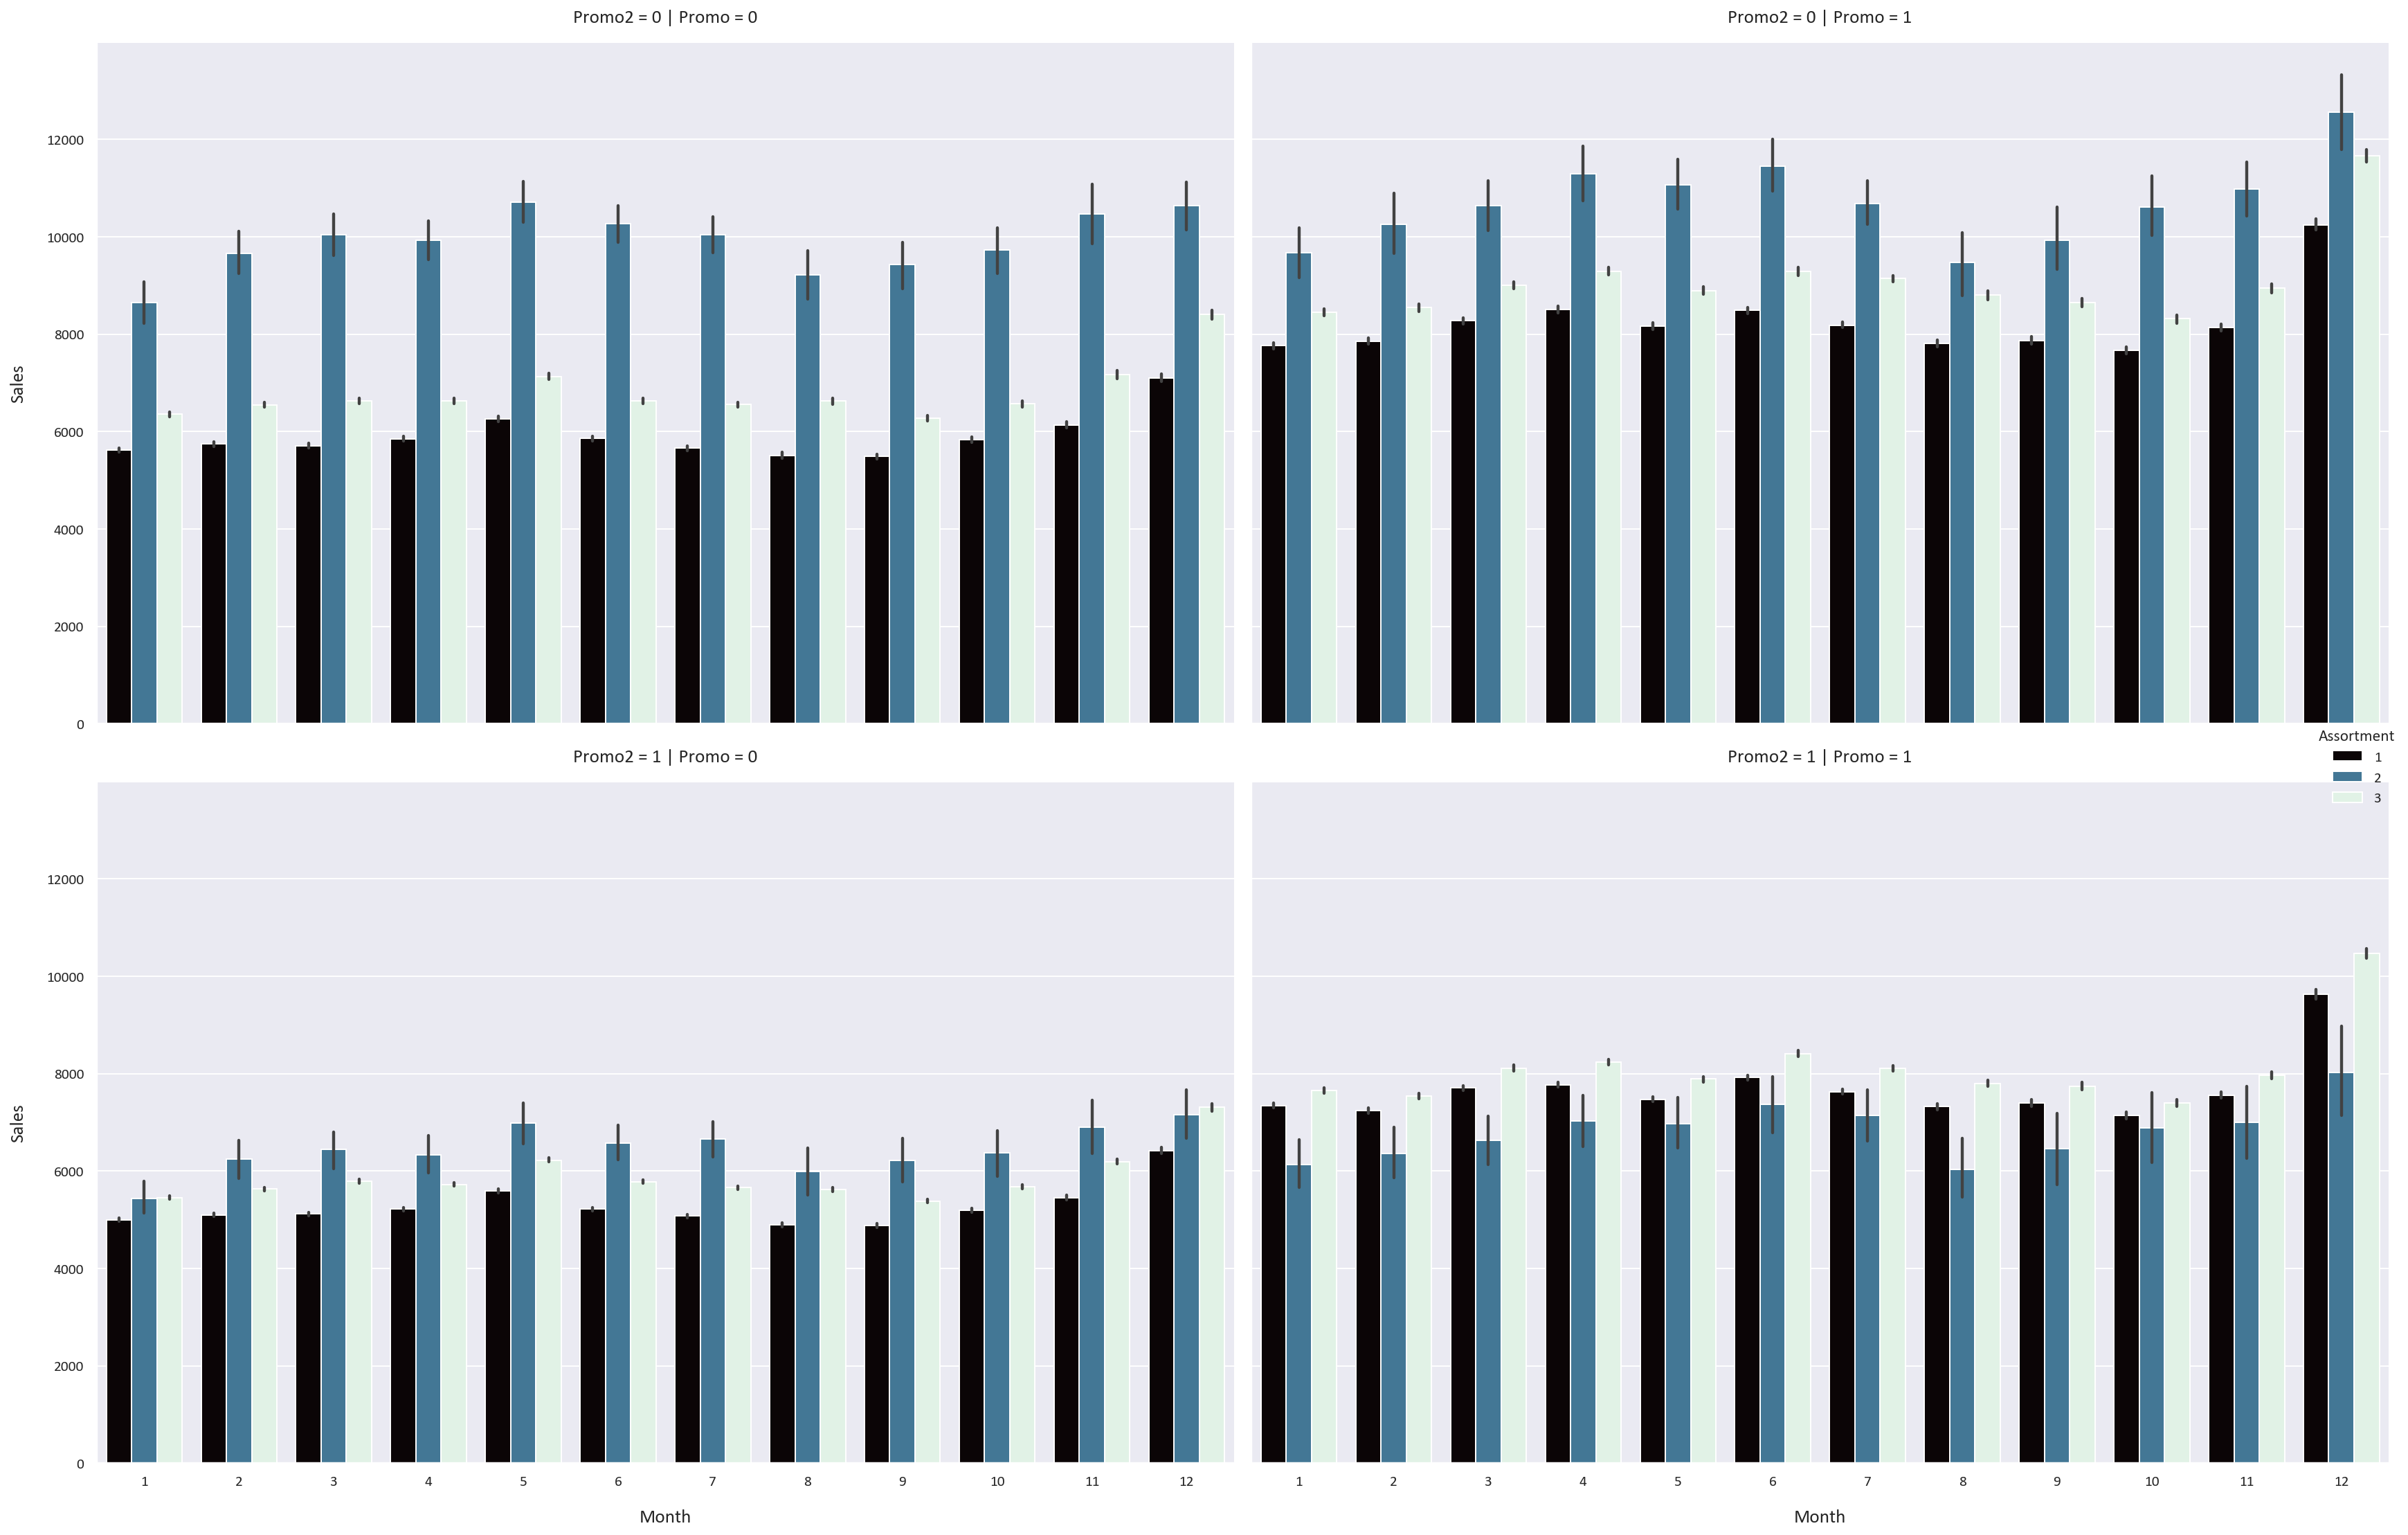

In [81]:
# Plot a Catplot of the Monthly Sales based on the Assortment, Promo, and Promo2 columns
plt.figure(figsize=(16, 10))
sns.catplot(data=df, x='Month', y='Sales', hue='Assortment', kind='bar', col='Promo', row='Promo2', height=8, aspect=1.5, palette='mako')
plt.tight_layout()

<Figure size 2240x1400 with 0 Axes>

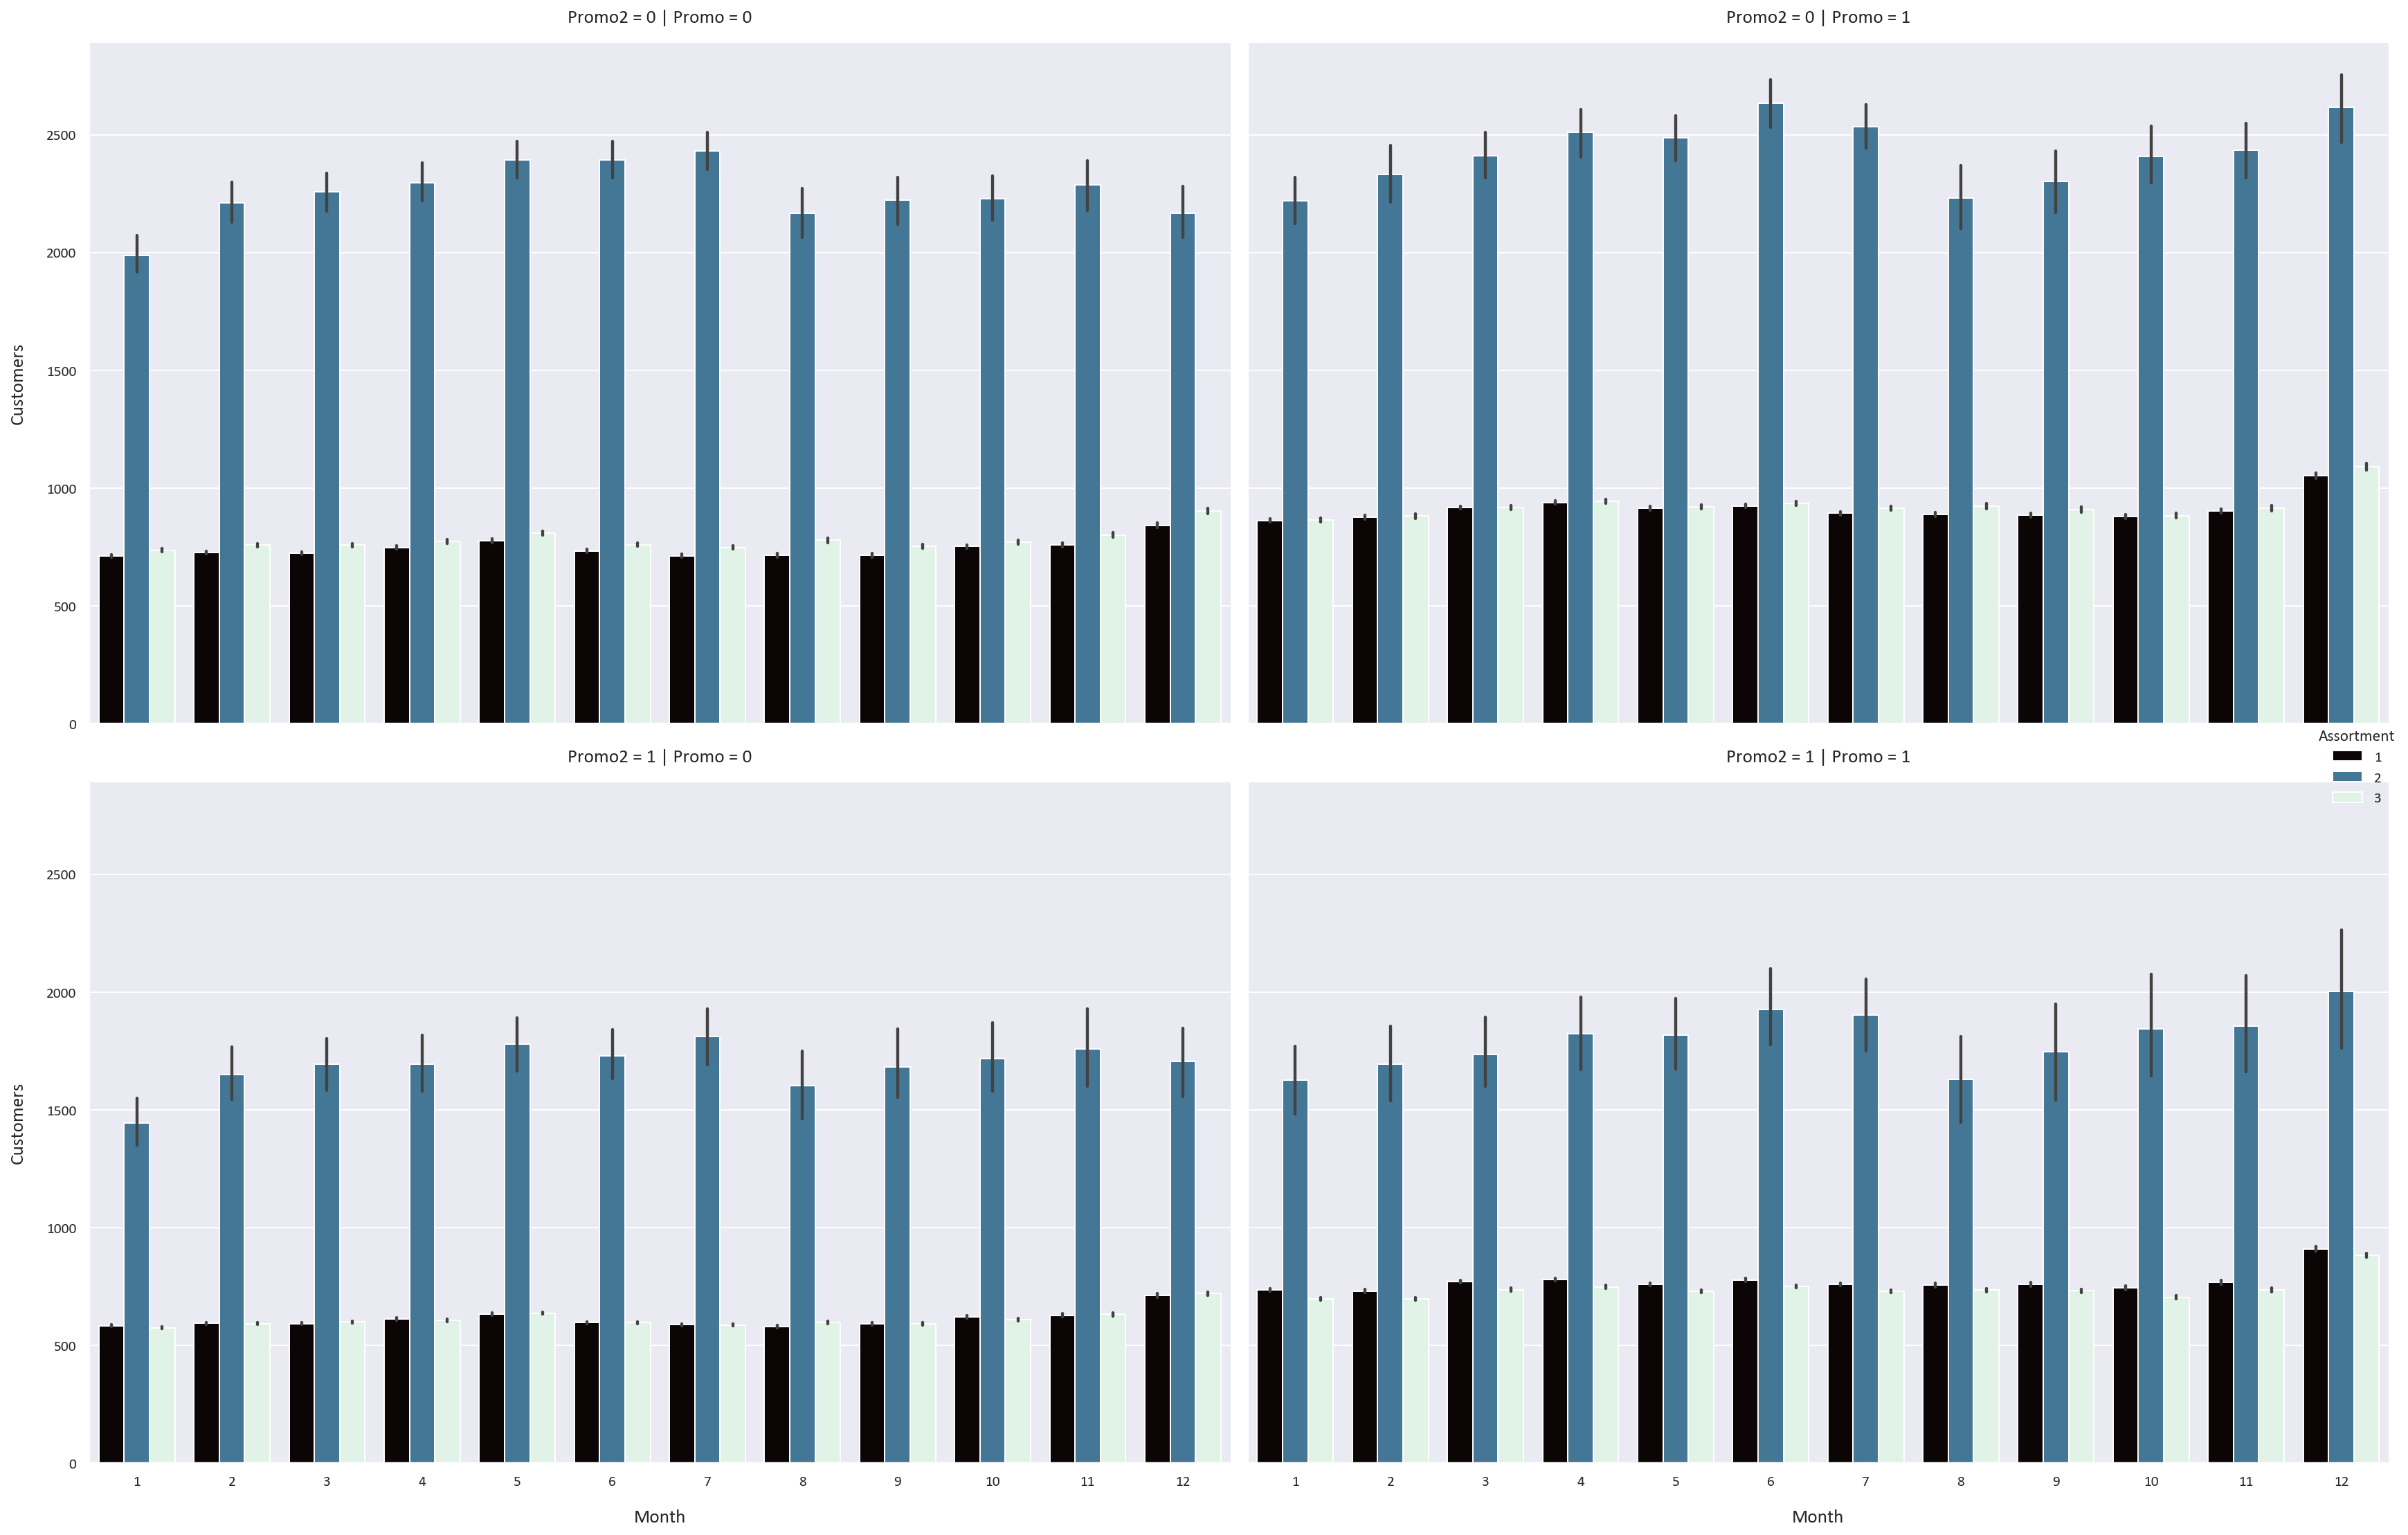

In [82]:
# Plot a Catplot of the Monthly Customers based on the Assortment, Promo, and Promo2 columns
plt.figure(figsize=(16, 10))
sns.catplot(data=df, x='Month', y='Customers', hue='Assortment', kind='bar', col='Promo', row='Promo2', height=8, aspect=1.5, palette='mako')
plt.tight_layout()

<Figure size 2240x1400 with 0 Axes>

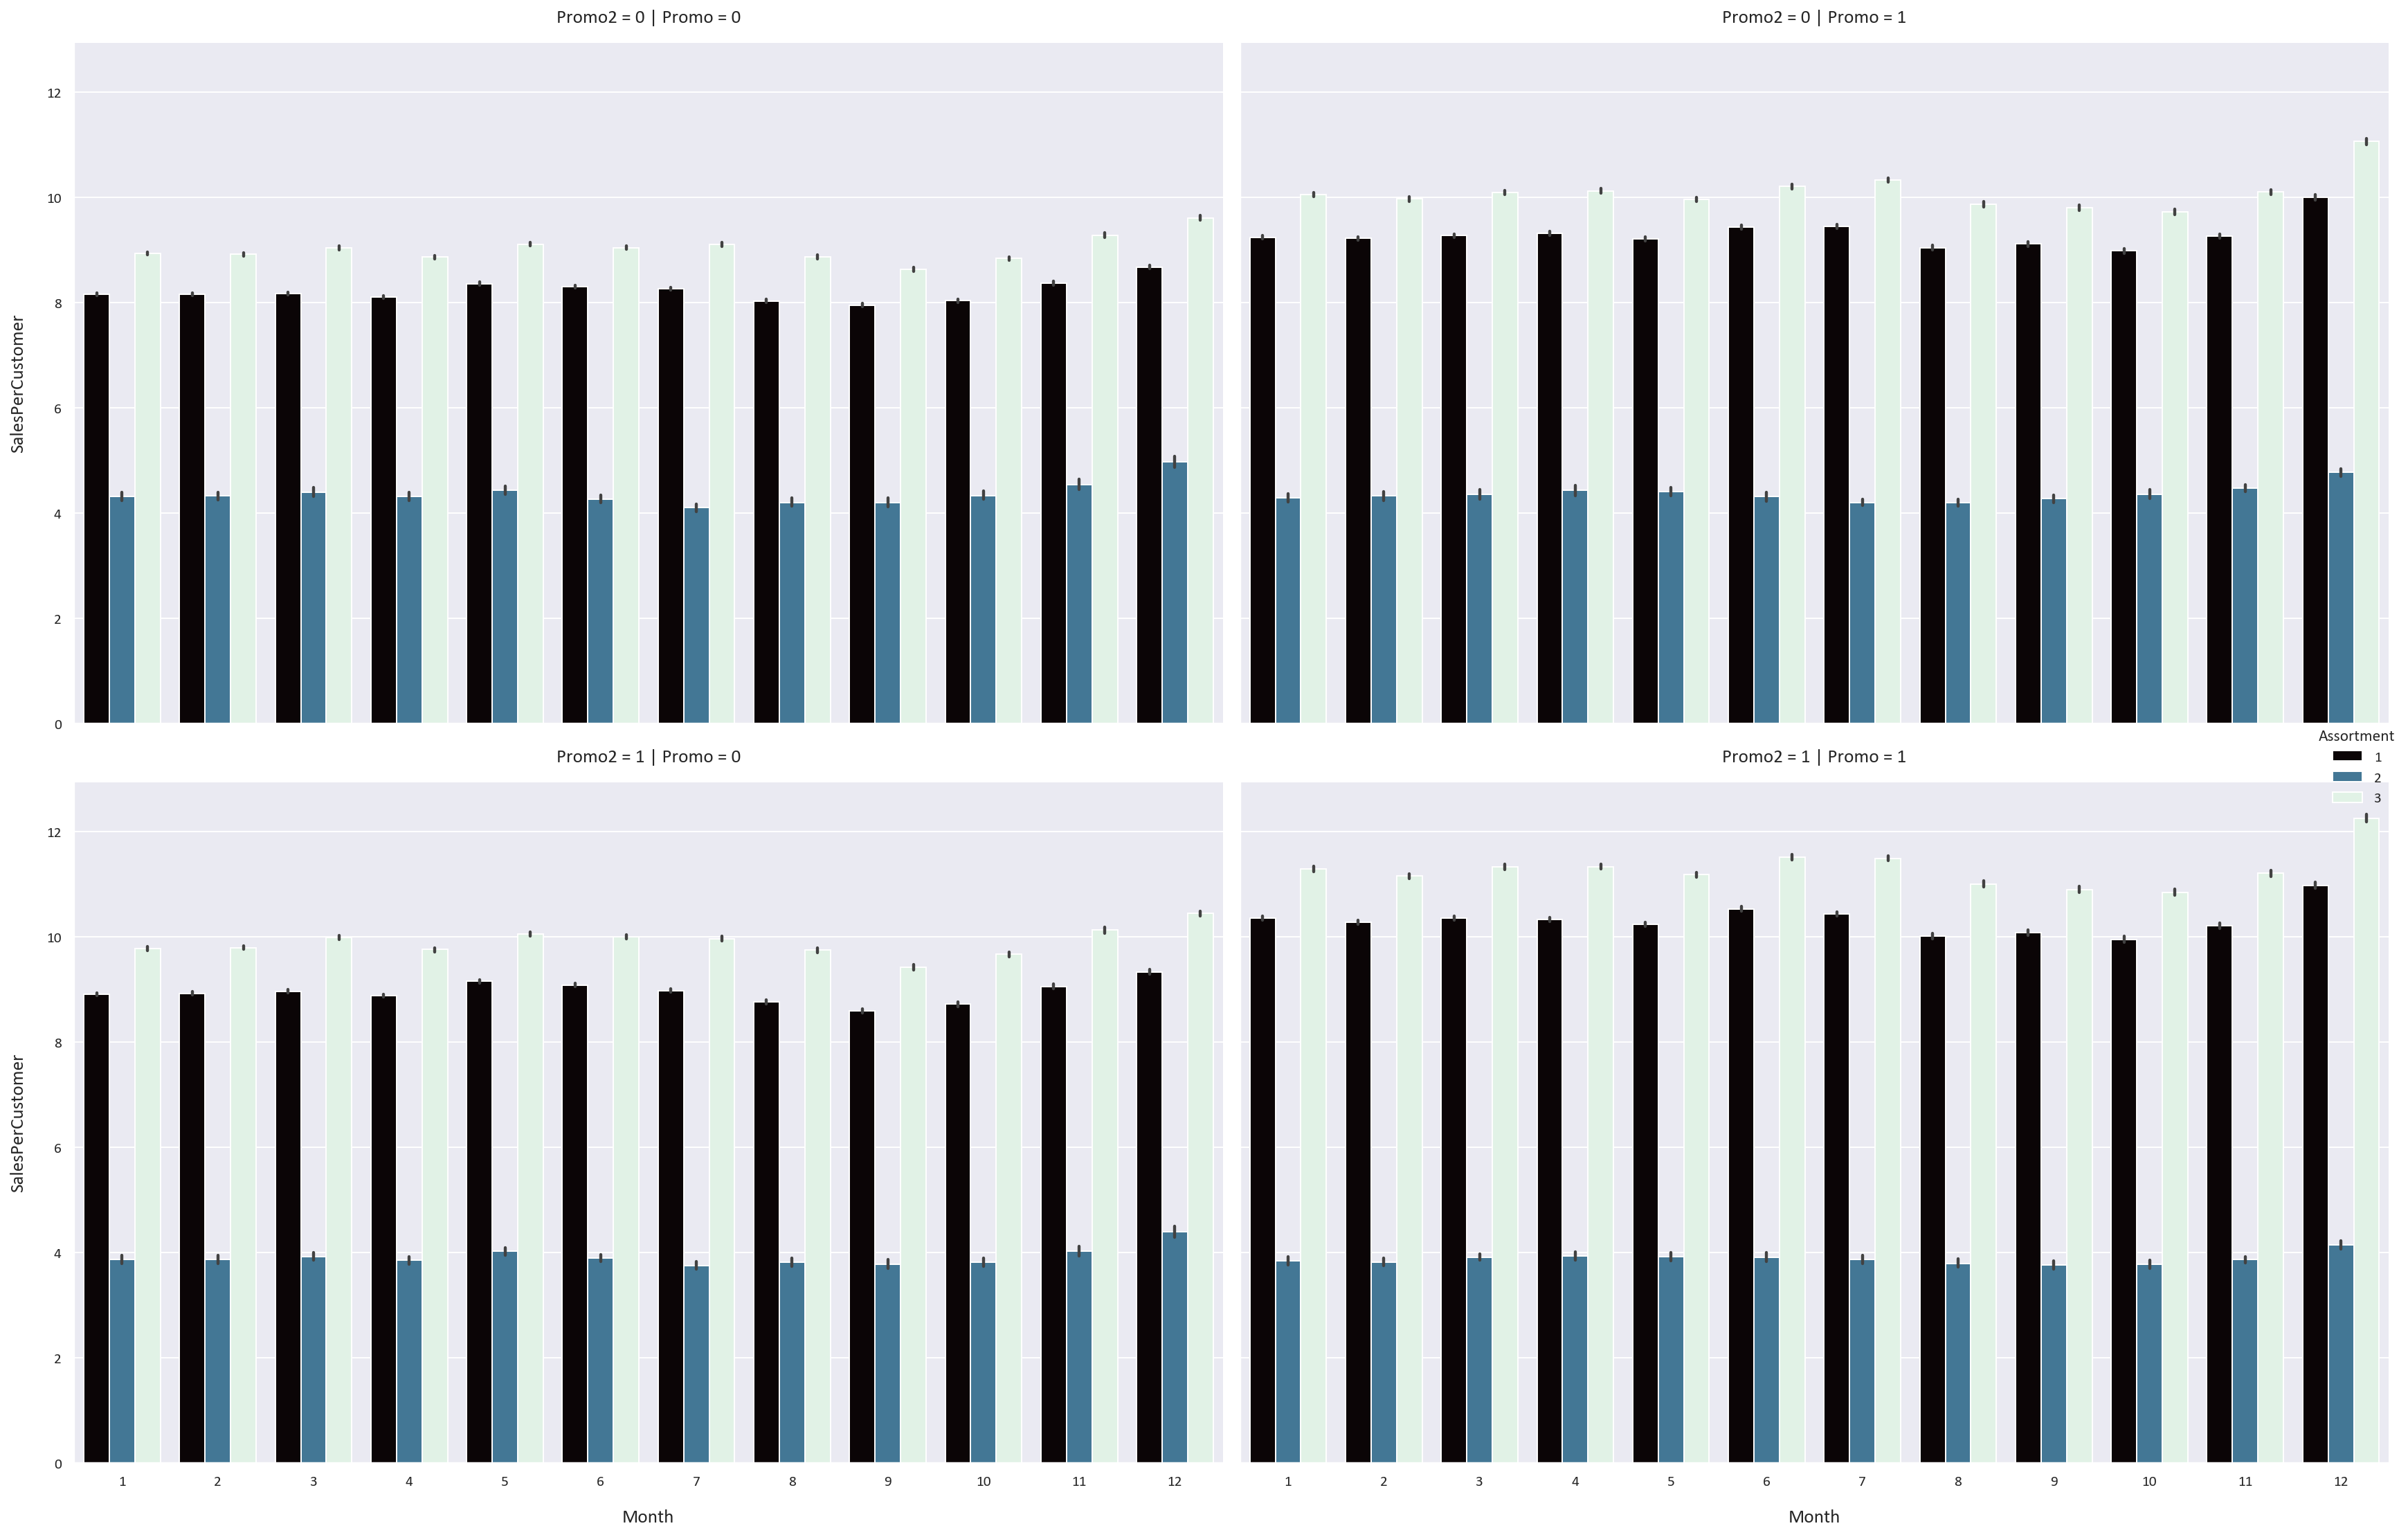

In [83]:
# Plot a Catplot of the Monthly SalesPerCustomer based on the Assortment, Promo, and Promo2 columns
plt.figure(figsize=(16, 10))
sns.catplot(data=df, x='Month', y='SalesPerCustomer', hue='Assortment', kind='bar', col='Promo', row='Promo2', height=8, aspect=1.5, palette='mako')
plt.tight_layout()

We notice some interesting patterns:
* The Promo feature increases the sales, customers, and sales per customer for all storetypes and assortment types by a significant margin. This means that the stores should have more promotions to increase their sales and customers.
* However, the Promo2 feature has an adverse effect on the sales, customers, and sales per customer for all storetypes and assortment types. We know that the Promo2 feature is a continuing and consecutive promotion, so perhaps a continuous promotion is not as effective as a one-time promotion.
* We also notice that the sales, customers, and sales per customer are highest in December and lowest in January. This could be because people buy more in December because of the sales and promotions that happen, while they buy less in January because they spent a lot of money in December.


## 4. Sales Forecasting

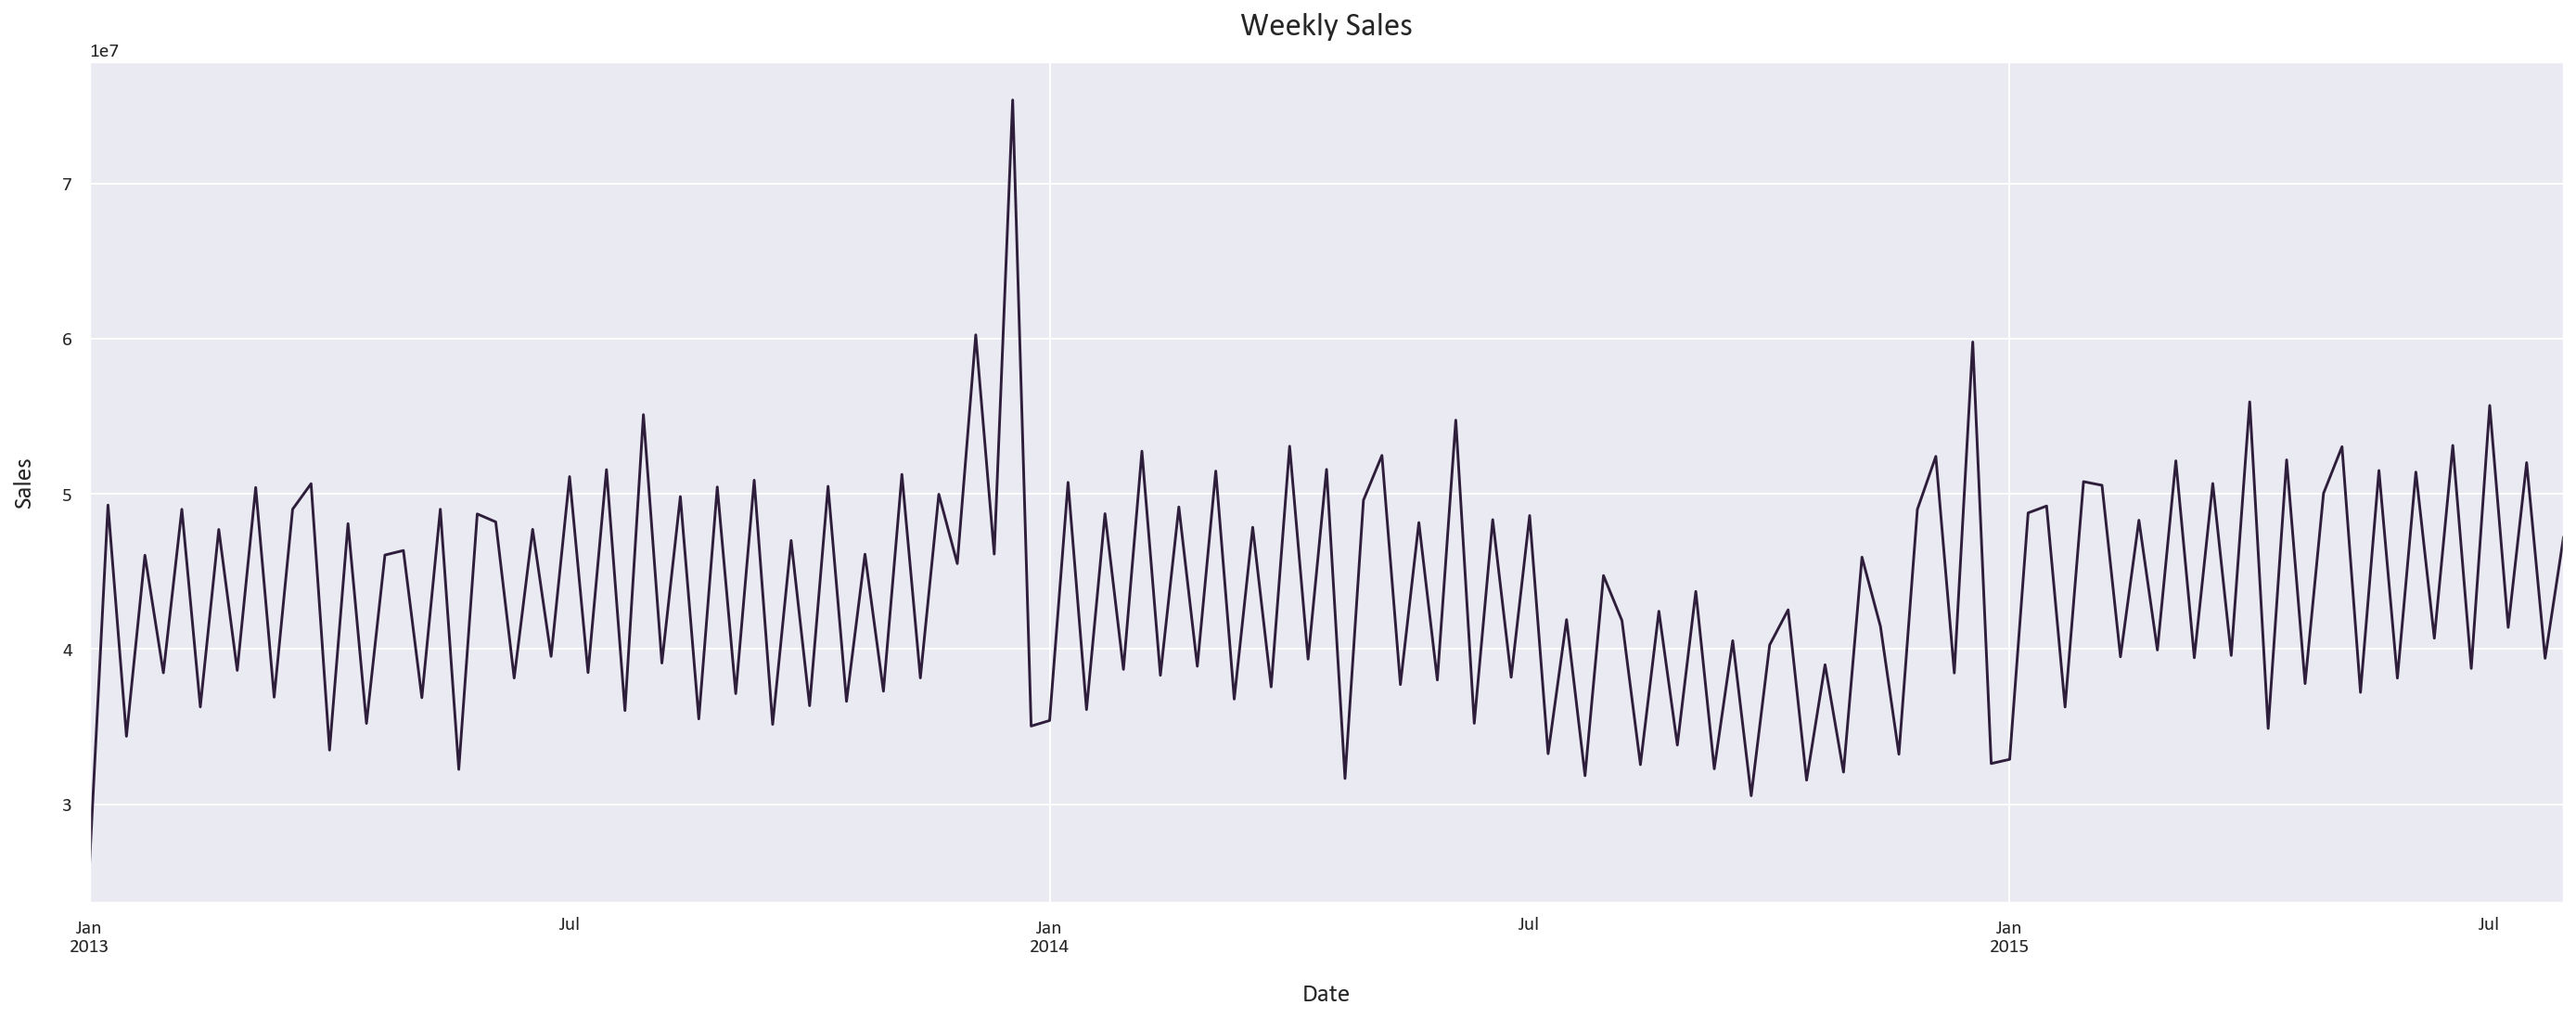

In [137]:
# Resample the data to get the weekly sales
weekly_sales = df['Sales'].resample('W').sum()
plt.figure(figsize=(20, 8))
weekly_sales.plot()
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

<Figure size 1680x1120 with 0 Axes>

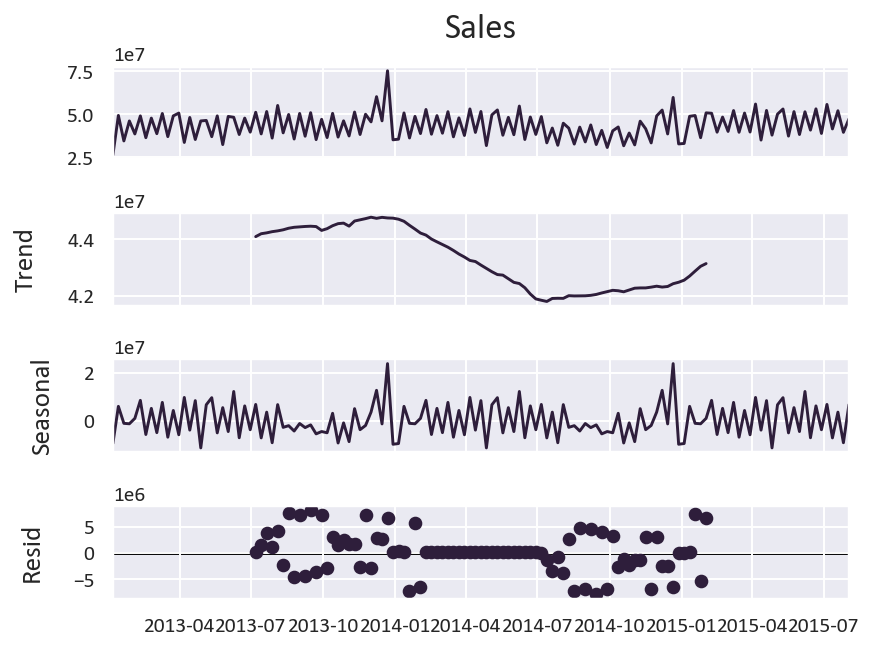

In [85]:
# Identify the trend, seasonality, and noise in the data
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the data
result = seasonal_decompose(weekly_sales, model='additive')
# Plot the trend, seasonality, and noise
plt.figure(figsize=(12, 8))
result.plot()
plt.tight_layout()

* We notice a clear seasonality pattern, with the sales increasing in December, decreasing in January, and fluctuating throughout the rest of the year.
* The trend isn't as clear, as the data is over a short period of time. 

<Figure size 1680x1120 with 0 Axes>

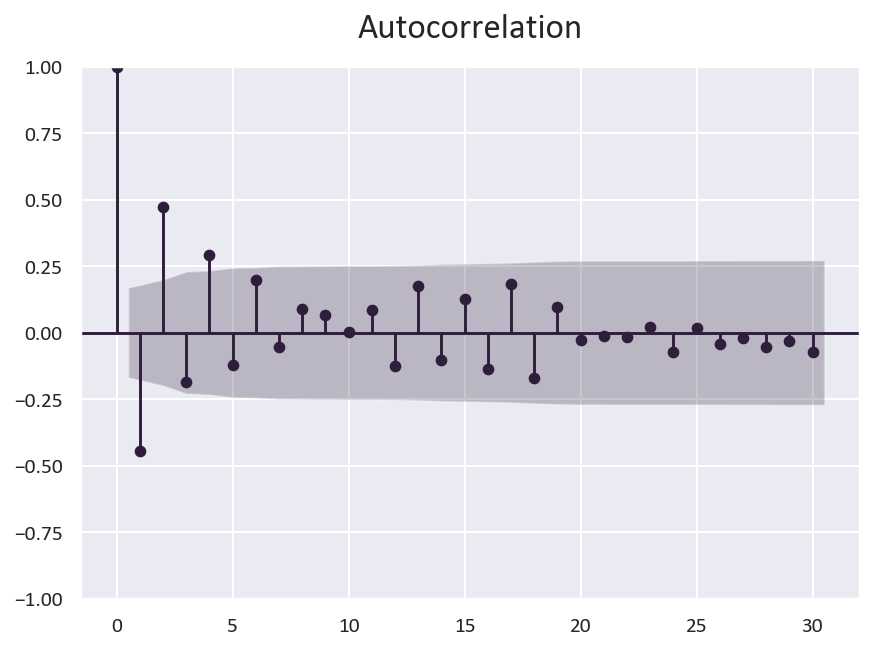

In [86]:
# Is there autocorrelation in the data?
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12, 8))
plot_acf(weekly_sales, lags=30)
plt.tight_layout()

We can conclude that there is some autocorrelation in the data, but it is not very strong.

In [87]:
# Is the data stationary?
from statsmodels.tsa.stattools import adfuller
# Perform the Dickey-Fuller test
result = adfuller(weekly_sales)
# Print the p-value
print('p-value: ', result[1])

p-value:  0.0020208588880313446


Yes, the data is stationary, meaning that the mean and variance are constant over time. 

Based on the trend, seasonality, noise, and autocorrelation, I think that the best model for this data is one not based on time series, but rather a regression model. 

This is because there are many features that can be used to predict the sales, such as the storetype, assortment type, promo, promo2, and competition distance. If we use a time series model, we will not be able to use these features and would be relying only on the trend, seasonality, noise, and autocorrelation. As these properties are not very strong, the model will not be accurate.

We will be using a Random Forest Regressor, as it is a powerful ensemble model that can handle complex relationships between variables. It works by creating many decision trees and combining their predictions to create a more accurate prediction while reducing overfitting.

We will also try a XGBoost Regressor, which works similarly to the Random Forest Regressor, but it iteratively constructs decision trees, where each new tree is built to reduce the errors of the previous tree. This model is very powerful and can achieve state-of-the-art results on a variety of difficult machine learning tasks.

As for the evaluation methods we will use four metrics:
* Mean Absolute Error (MAE): the mean of the absolute value of the errors. This is the easiest metric to understand, as it is simply the average error.
* Mean Absolute Percentage Error (MAPE): the mean of the absolute value of the percentage errors, or the absolute percentage difference between the actual and predicted values. This is a good metric to use when we want to minimize the effect of outliers. However, it is not very useful when the actual values are close to zero, as the percentage error will be very high. It can be from 0% to infinity, with 0% being a perfect prediction.

This is its formula:
MAPE = (1/n) * ∑(|Predicted - Actual| / |Actual|) * 100%

* Symmetric Mean Absolute Percentage Error (SMAPE): SMAPE is calculated as the mean of the absolute value of the percentage errors, but the absolute difference is divided by the sum of the mean of the absolute values of the actual and predicted values. This is a better metric to use for outlier-heavy data as it is symmetric, meaning that it doesn't matter if the actual value is larger or the predicted value is larger. It can be from 0% to 200%, with 0% being a perfect prediction and 200% being the worst prediction possible.

This is its formula:
SMAPE = (1/n) * ∑(|Predicted - Actual| / (|Actual| + |Predicted|)/2) * 100%

* R2 Score: the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It is useful for determining how well the model explains the variance in the data. It can be from 0 to 1, with 1 meaning the model explains all the variance in the data and 0 meaning the model explains none of the variance in the data. Of course, having an R2 score close to 1 is not always a good thing, as it could mean that the model is overfitting.
For human behavior related studies, the R2 score is usually less than 0.5, as human behavior is harder to predict than physical behavior. [Reference](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4128165)

In [88]:
# Define the features and target while dropping the features not present in the test data
X = df.drop(['Sales', 'Store', 'Customers', 'SalesPerCustomer'], axis=1)
y = df['Sales']

In [89]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [122]:
# Instantiate the random forest regressor
rf = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1, verbose=1, max_depth=30)

# Fit the model to the training data
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   49.5s finished


RandomForestRegressor(max_depth=30, n_estimators=300, n_jobs=-1, random_state=0,
                      verbose=1)

In [123]:
# Make predictions on the testing data
y_pred = rf.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    1.8s finished


In [124]:
# Evaluate the model using MAE, MAPE, SMAPE, and R2 score
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))) * 100
r2 = r2_score(y_test, y_pred)
# Print the metrics
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Symmetric Mean Absolute Percentage Error: ', smape)
print('R2 Score: ', r2)

Mean Absolute Error:  1115.2309882185264
Mean Absolute Percentage Error:  17.401195204365806
Symmetric Mean Absolute Percentage Error:  16.12417120245528
R2 Score:  0.704369772527475


In [119]:
# Use XGBoost to make predictions
import xgboost as xgb
# Instantiate the XGBRegressor
xgb_reg = xgb.XGBRegressor(n_estimators=300, random_state=0, objective='reg:absoluteerror', max_depth=10)
# Fit the model to the training data
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

In [120]:
# Make predictions on the testing data
y_pred_xgb = xgb_reg.predict(X_test)

In [121]:
# Evaluate the model using MAE, MAPE, SMAPE, and R2 score
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
smape_xgb = np.mean(2 * np.abs(y_pred_xgb - y_test) / (np.abs(y_test) + np.abs(y_pred_xgb))) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)
# Print the metrics
print('Mean Absolute Error: ', mae_xgb)
print('Mean Absolute Percentage Error: ', mape_xgb)
print('Symmetric Mean Absolute Percentage Error: ', smape_xgb)
print('R2 Score: ', r2_xgb)

Mean Absolute Error:  1031.599894705175
Mean Absolute Percentage Error:  16.021434332031838
Symmetric Mean Absolute Percentage Error:  15.124611440443609
R2 Score:  0.7304052654222772


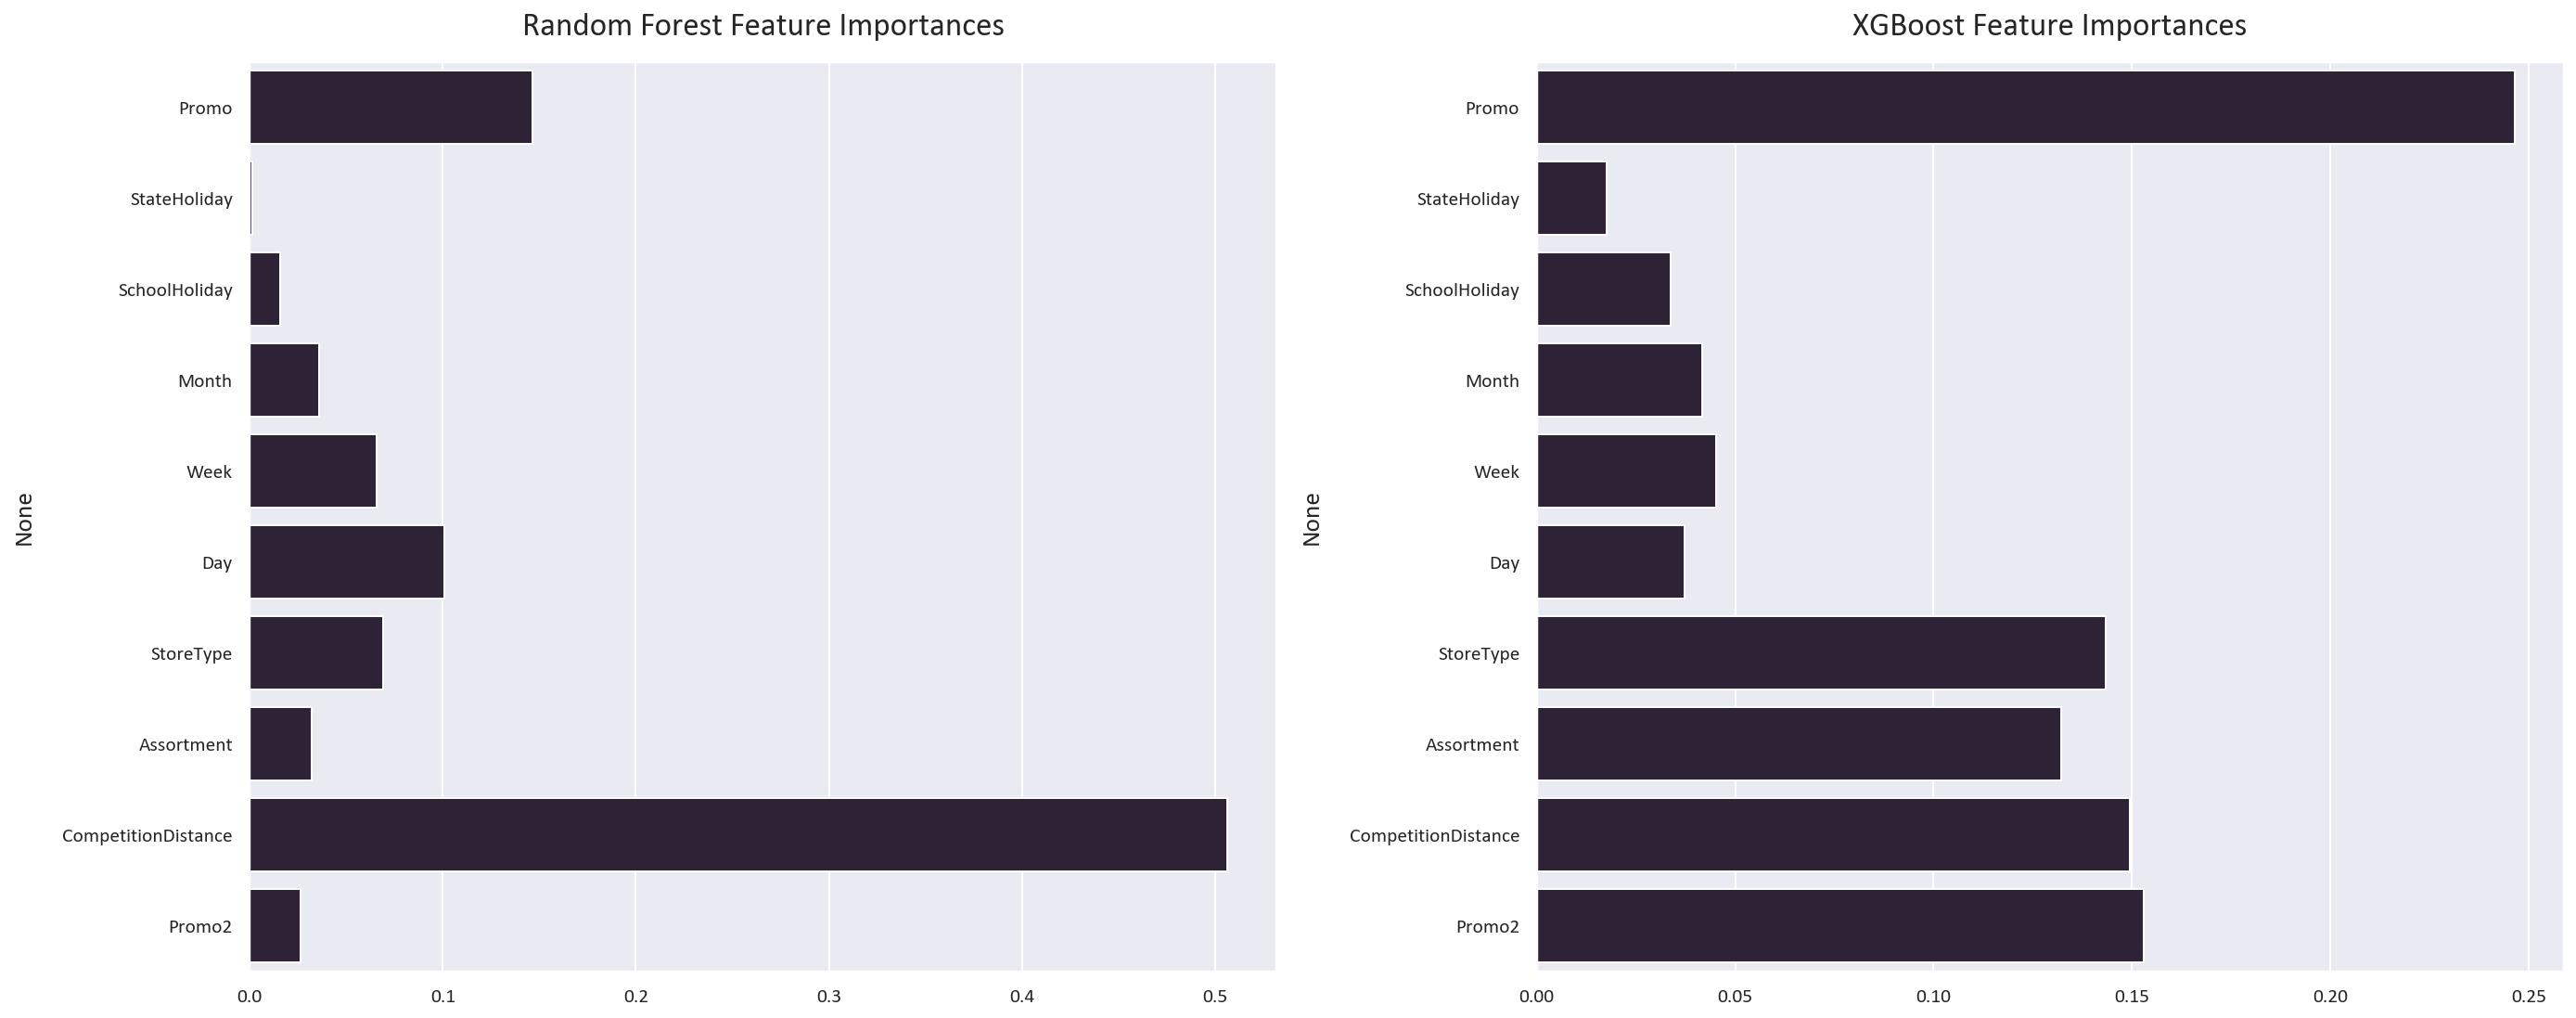

In [136]:
# Plot the feature importances for both models
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.title('Random Forest Feature Importances')
plt.subplot(1, 2, 2)
sns.barplot(x=xgb_reg.feature_importances_, y=X.columns)
plt.title('XGBoost Feature Importances')
plt.tight_layout()

As we can see, the random forest regressor focused more on CompetionDistance, while the XGBoost regressor focused more on Promo and Promo2. 

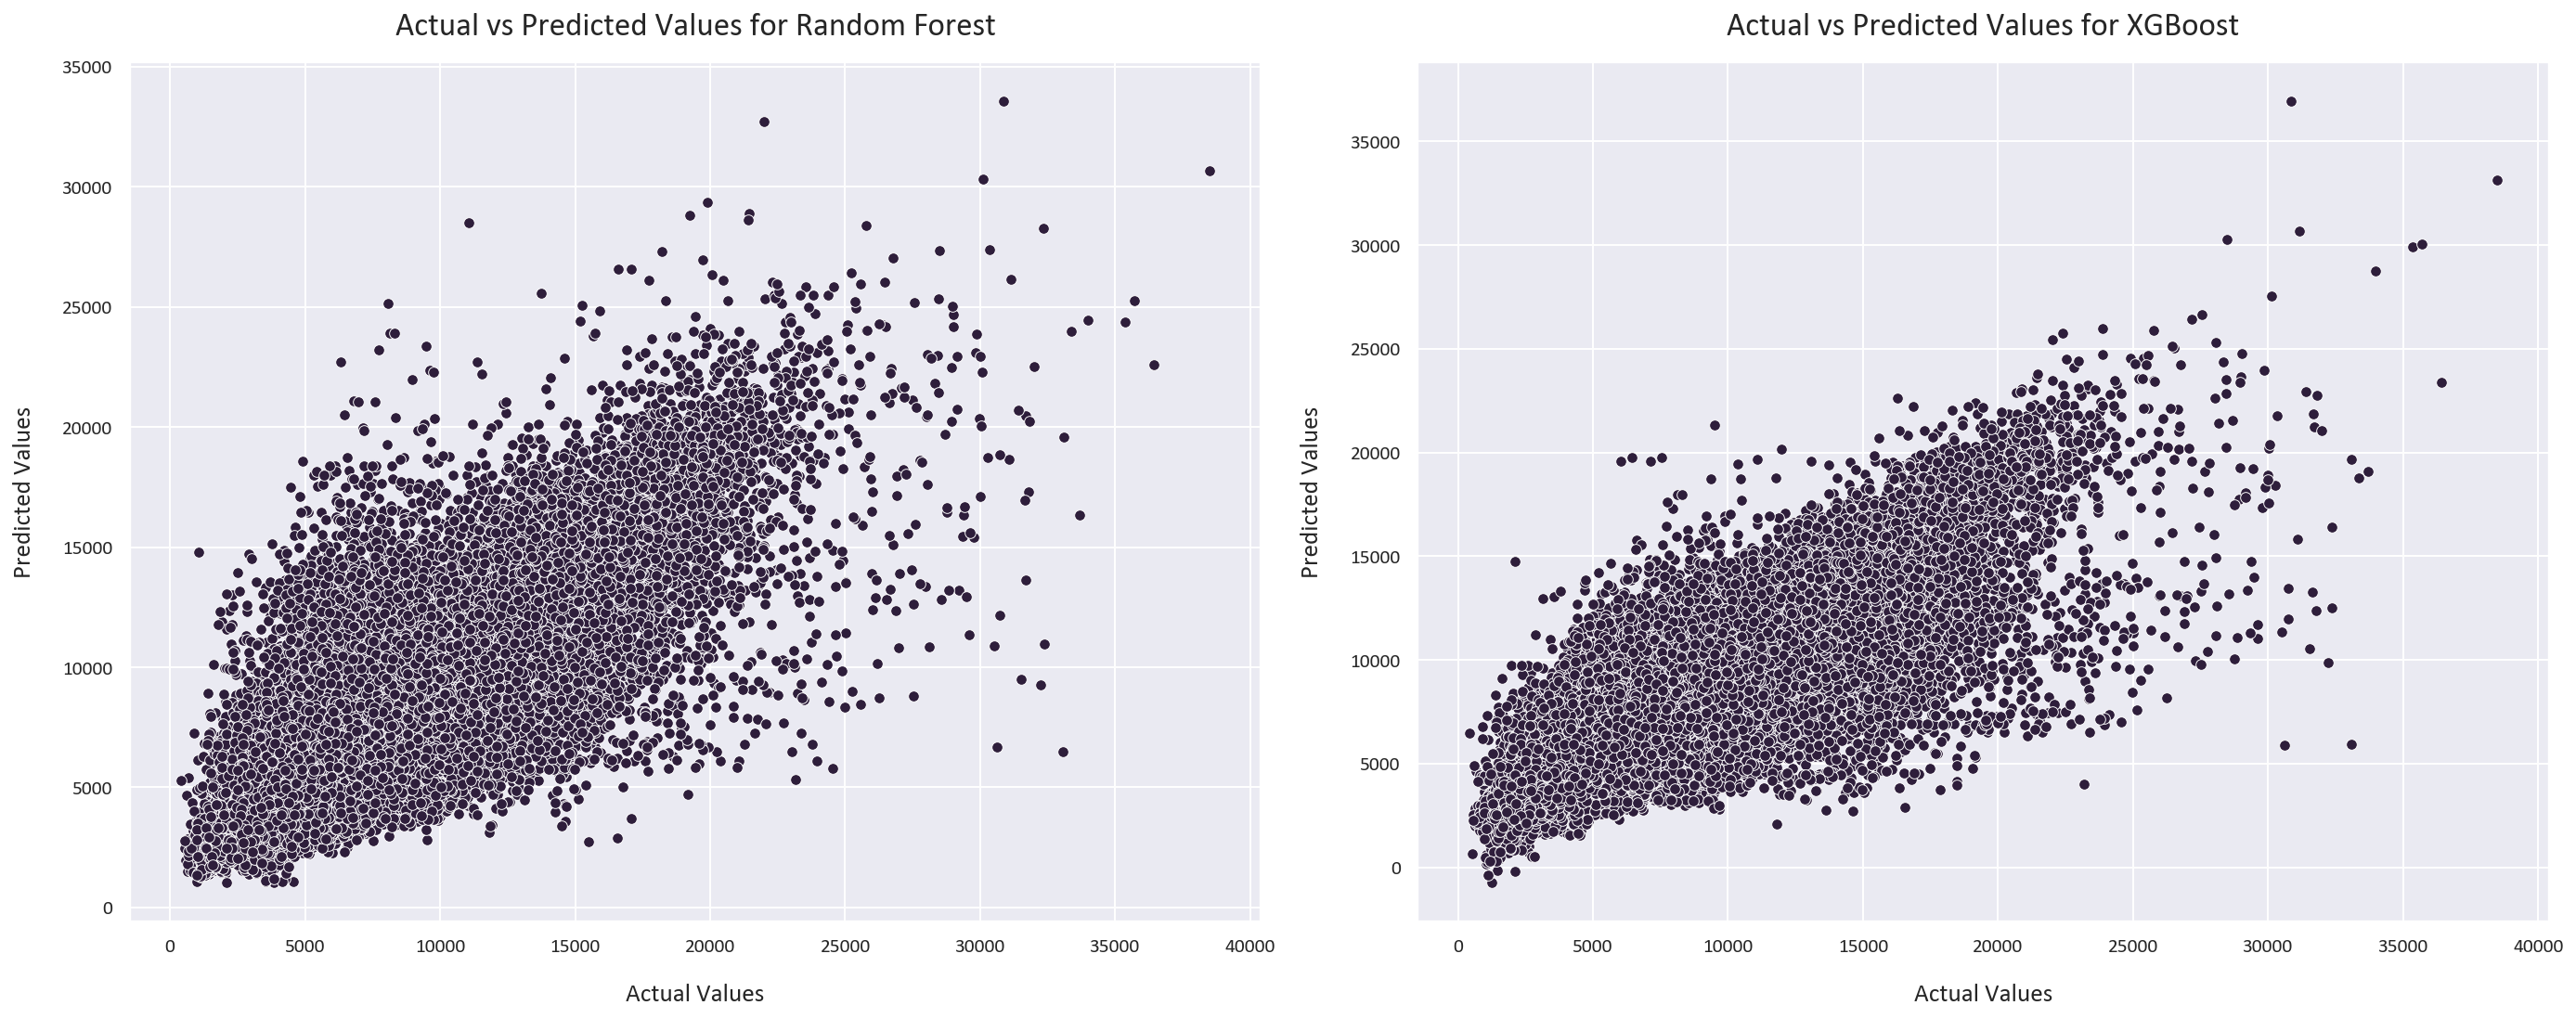

In [135]:
# Plot the actual vs predicted values for the two models
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Random Forest')
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for XGBoost')
plt.tight_layout()

The random forest regressor's predictions are more spread out, while the XGBoost regressor's predictions are more concentrated around the line of best fit.

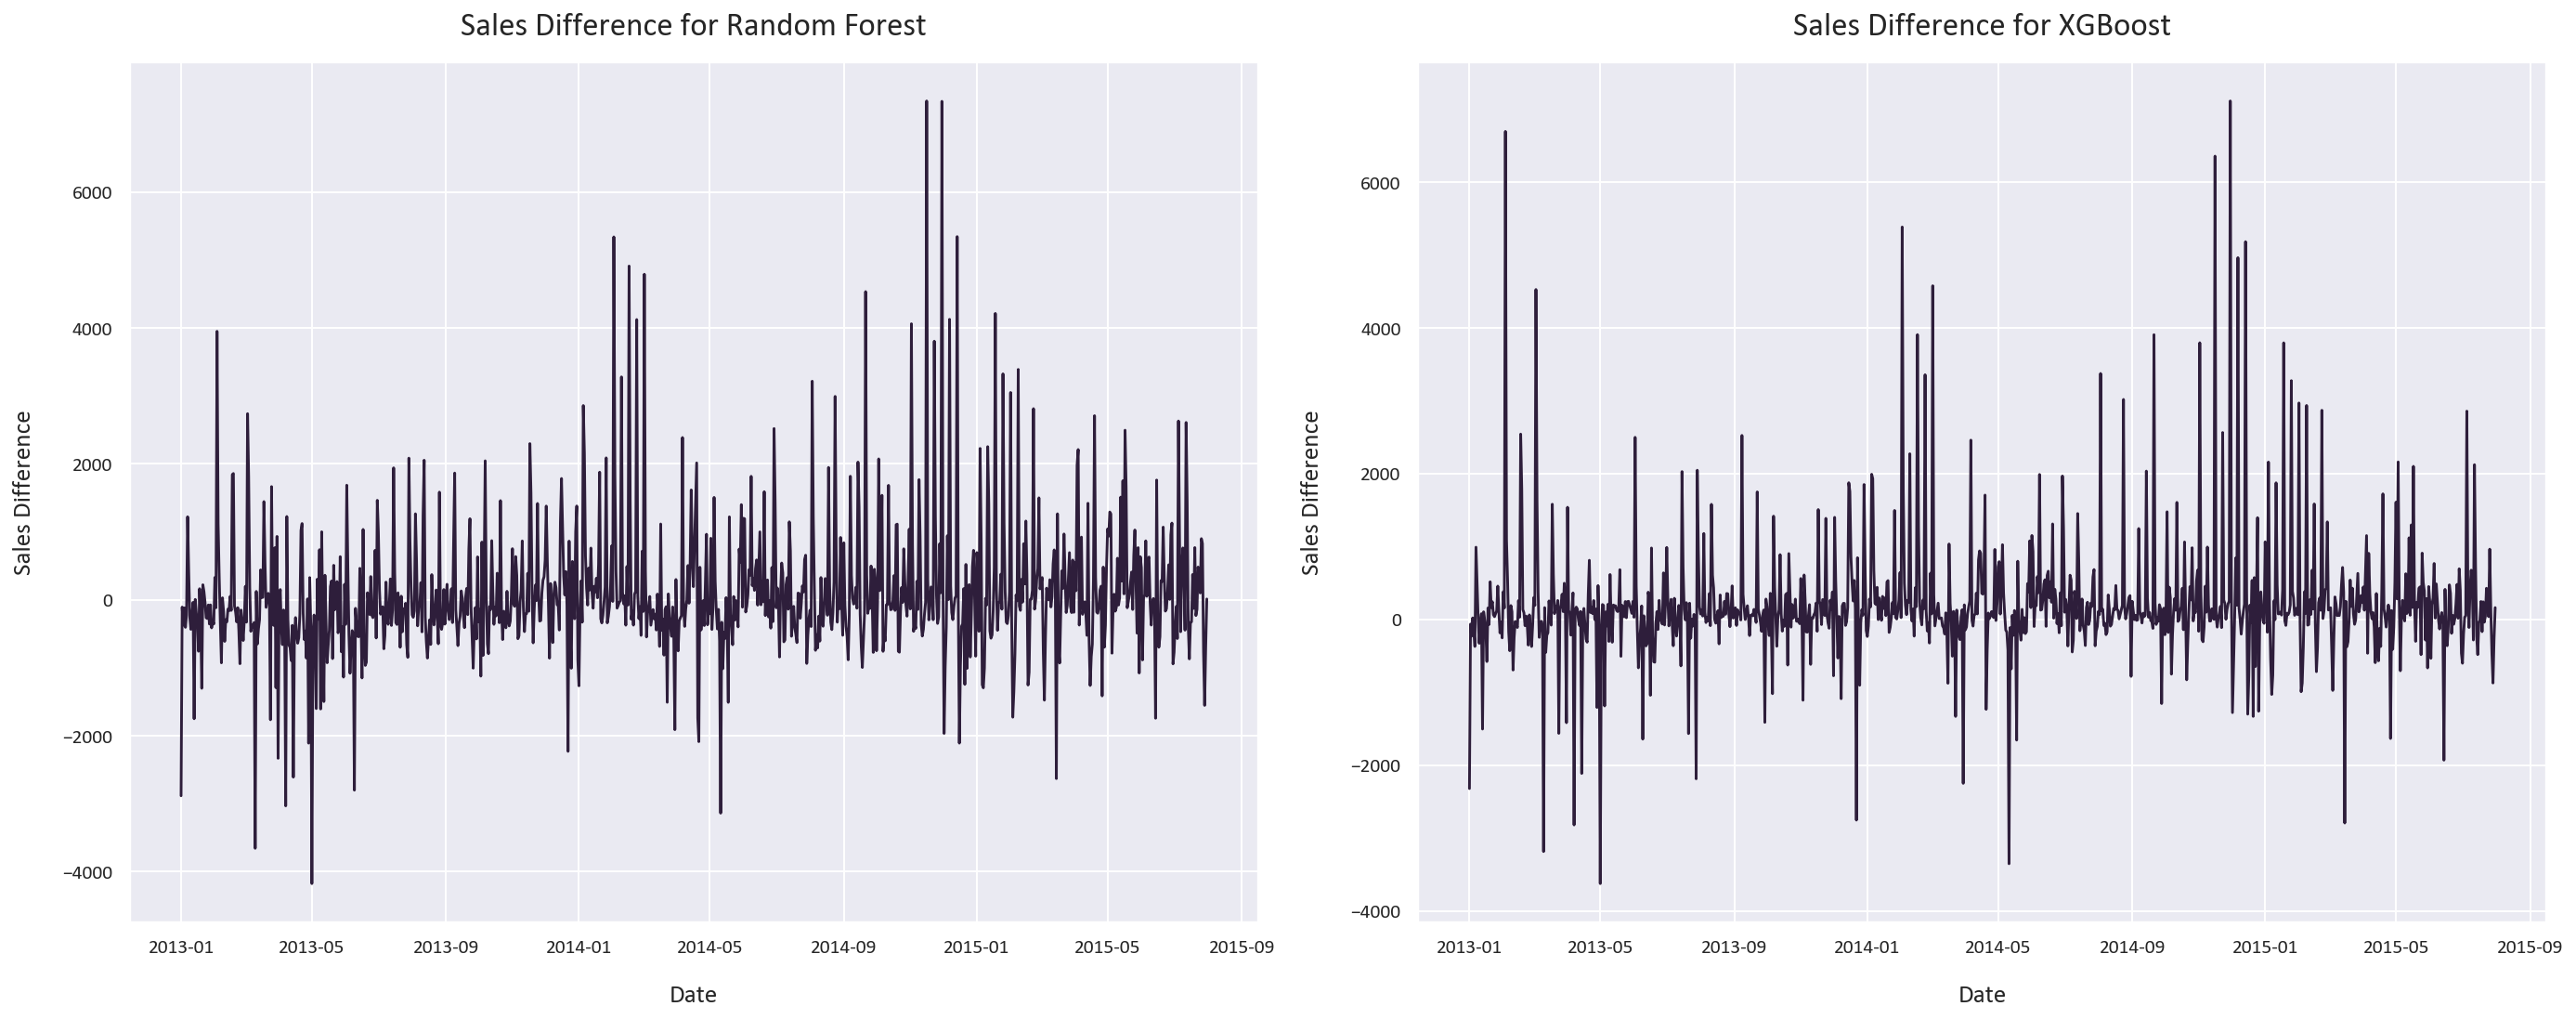

In [134]:
# Plot the difference between the actual and predicted values for the two models
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.lineplot(x=y_test.index, y=y_test - y_pred, ci=None)
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.title('Sales Difference for Random Forest')
plt.subplot(1, 2, 2)
sns.lineplot(x=y_test.index, y=y_test - y_pred_xgb, ci=None)
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.title('Sales Difference for XGBoost')
plt.tight_layout()

In [138]:
# Print the metrics for both models
print('Random Forest Metrics')
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Symmetric Mean Absolute Percentage Error: ', smape)
print('R2 Score: ', r2)
print('\n')
print('XGBoost Metrics')
print('Mean Absolute Error: ', mae_xgb)
print('Mean Absolute Percentage Error: ', mape_xgb)
print('Symmetric Mean Absolute Percentage Error: ', smape_xgb)
print('R2 Score: ', r2_xgb)

Random Forest Metrics
Mean Absolute Error:  1115.2309882185264
Mean Absolute Percentage Error:  17.401195204365806
Symmetric Mean Absolute Percentage Error:  16.12417120245528
R2 Score:  0.704369772527475


XGBoost Metrics
Mean Absolute Error:  1031.599894705175
Mean Absolute Percentage Error:  16.021434332031838
Symmetric Mean Absolute Percentage Error:  15.124611440443609
R2 Score:  0.7304052654222772


Both models perform extremely well, with the XGBoost regressor performing slightly better. This is because the XGBoost regressor is an iterative model, so it can learn from its mistakes and improve its predictions. It learnt that the Promo and Promo2 features are very important, while the random forest regressor didn't learn this. 

The MAE of the random forest regressor is 1115, with a SMAPE of 16.12% and an R2 score of 0.70. The MAE of the XGBoost regressor is 1031, with a SMAPE of 15.12% and an R2 score of 0.73.

Let's test these models on the test data.

In [147]:
# Inspect the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [148]:
# Convert the Date column to datetime
test['Date'] = pd.to_datetime(test['Date'])
# Extract the month, week, and day from the date column
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].apply(lambda x: x.isocalendar()[1])
test['Day'] = test['Date'].dt.day

In [149]:
# Merge the test and store data on the Store column
test = pd.merge(test, store, on='Store')

In [150]:
# Set the Date column as the index and sort it
test.set_index('Date', inplace=True)
test.sort_index(inplace=True)

In [151]:
# Inspect the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-08-01 to 2015-09-17
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Open                       41077 non-null  float64
 4   Promo                      41088 non-null  int64  
 5   StateHoliday               41088 non-null  object 
 6   SchoolHoliday              41088 non-null  int64  
 7   Month                      41088 non-null  int32  
 8   Week                       41088 non-null  int64  
 9   Day                        41088 non-null  int32  
 10  StoreType                  41088 non-null  object 
 11  Assortment                 41088 non-null  object 
 12  CompetitionDistance        40992 non-null  float64
 13  CompetitionOpenSinceMonth  25

In [152]:
# Look at the missing values in the CompetitionDistance column
test[test['CompetitionDistance'].isnull()]

Id  Store  ...  Promo2SinceYear    PromoInterval
Date                      ...                                  
2015-08-01  40909    879  ...           2013.0  Feb,May,Aug,Nov
2015-08-01  40712    622  ...              NaN              NaN
2015-08-02  40053    879  ...           2013.0  Feb,May,Aug,Nov
2015-08-02  39856    622  ...              NaN              NaN
2015-08-03  39000    622  ...              NaN              NaN
...           ...    ...  ...              ...              ...
2015-09-15   2389    879  ...           2013.0  Feb,May,Aug,Nov
2015-09-16   1336    622  ...              NaN              NaN
2015-09-16   1533    879  ...           2013.0  Feb,May,Aug,Nov
2015-09-17    677    879  ...           2013.0  Feb,May,Aug,Nov
2015-09-17    480    622  ...              NaN              NaN

[96 rows x 19 columns]

In [153]:
# Which stores are these?
test[test['CompetitionDistance'].isnull()]['Store'].unique()

array([879, 622], dtype=int64)

The data for these stores seems to be missing, so we will simply fill the missing values with 0.

In [154]:
# Fill the missing values with 0
test['CompetitionDistance'].fillna(0, inplace=True)

In [155]:
# Drop the Id, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, CompetitionOpenMonths, Promo2SinceWeek, Promo2SinceYear, and PromoInterval columns
test.drop(['Id', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'DayOfWeek', 'Open',
           'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1, inplace=True)

In [156]:
# Drop the Store column
test = test.drop('Store', axis=1)

In [157]:
# Replace the StoreTypes, Assortments, and StateHolidays with numbers
test['StoreType'] = test['StoreType'].replace(['a', 'b', 'c', 'd'], [1, 2, 3, 4]) 
test['Assortment'] = test['Assortment'].replace(['a', 'b', 'c'], [1, 2, 3])
test['StateHoliday'] = test['StateHoliday'].replace(['a', 'b', 'c'], [1, 2, 3]).astype('int64')

In [158]:
# Last minute check for missing values
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41088 entries, 2015-08-01 to 2015-09-17
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Promo                41088 non-null  int64  
 1   StateHoliday         41088 non-null  int64  
 2   SchoolHoliday        41088 non-null  int64  
 3   Month                41088 non-null  int32  
 4   Week                 41088 non-null  int64  
 5   Day                  41088 non-null  int32  
 6   StoreType            41088 non-null  int64  
 7   Assortment           41088 non-null  int64  
 8   CompetitionDistance  41088 non-null  float64
 9   Promo2               41088 non-null  int64  
dtypes: float64(1), int32(2), int64(7)
memory usage: 3.1 MB


In [159]:
# Make predictions on the test data
test_pred = rf.predict(test)
test_pred_xgb = xgb_reg.predict(test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.2s finished


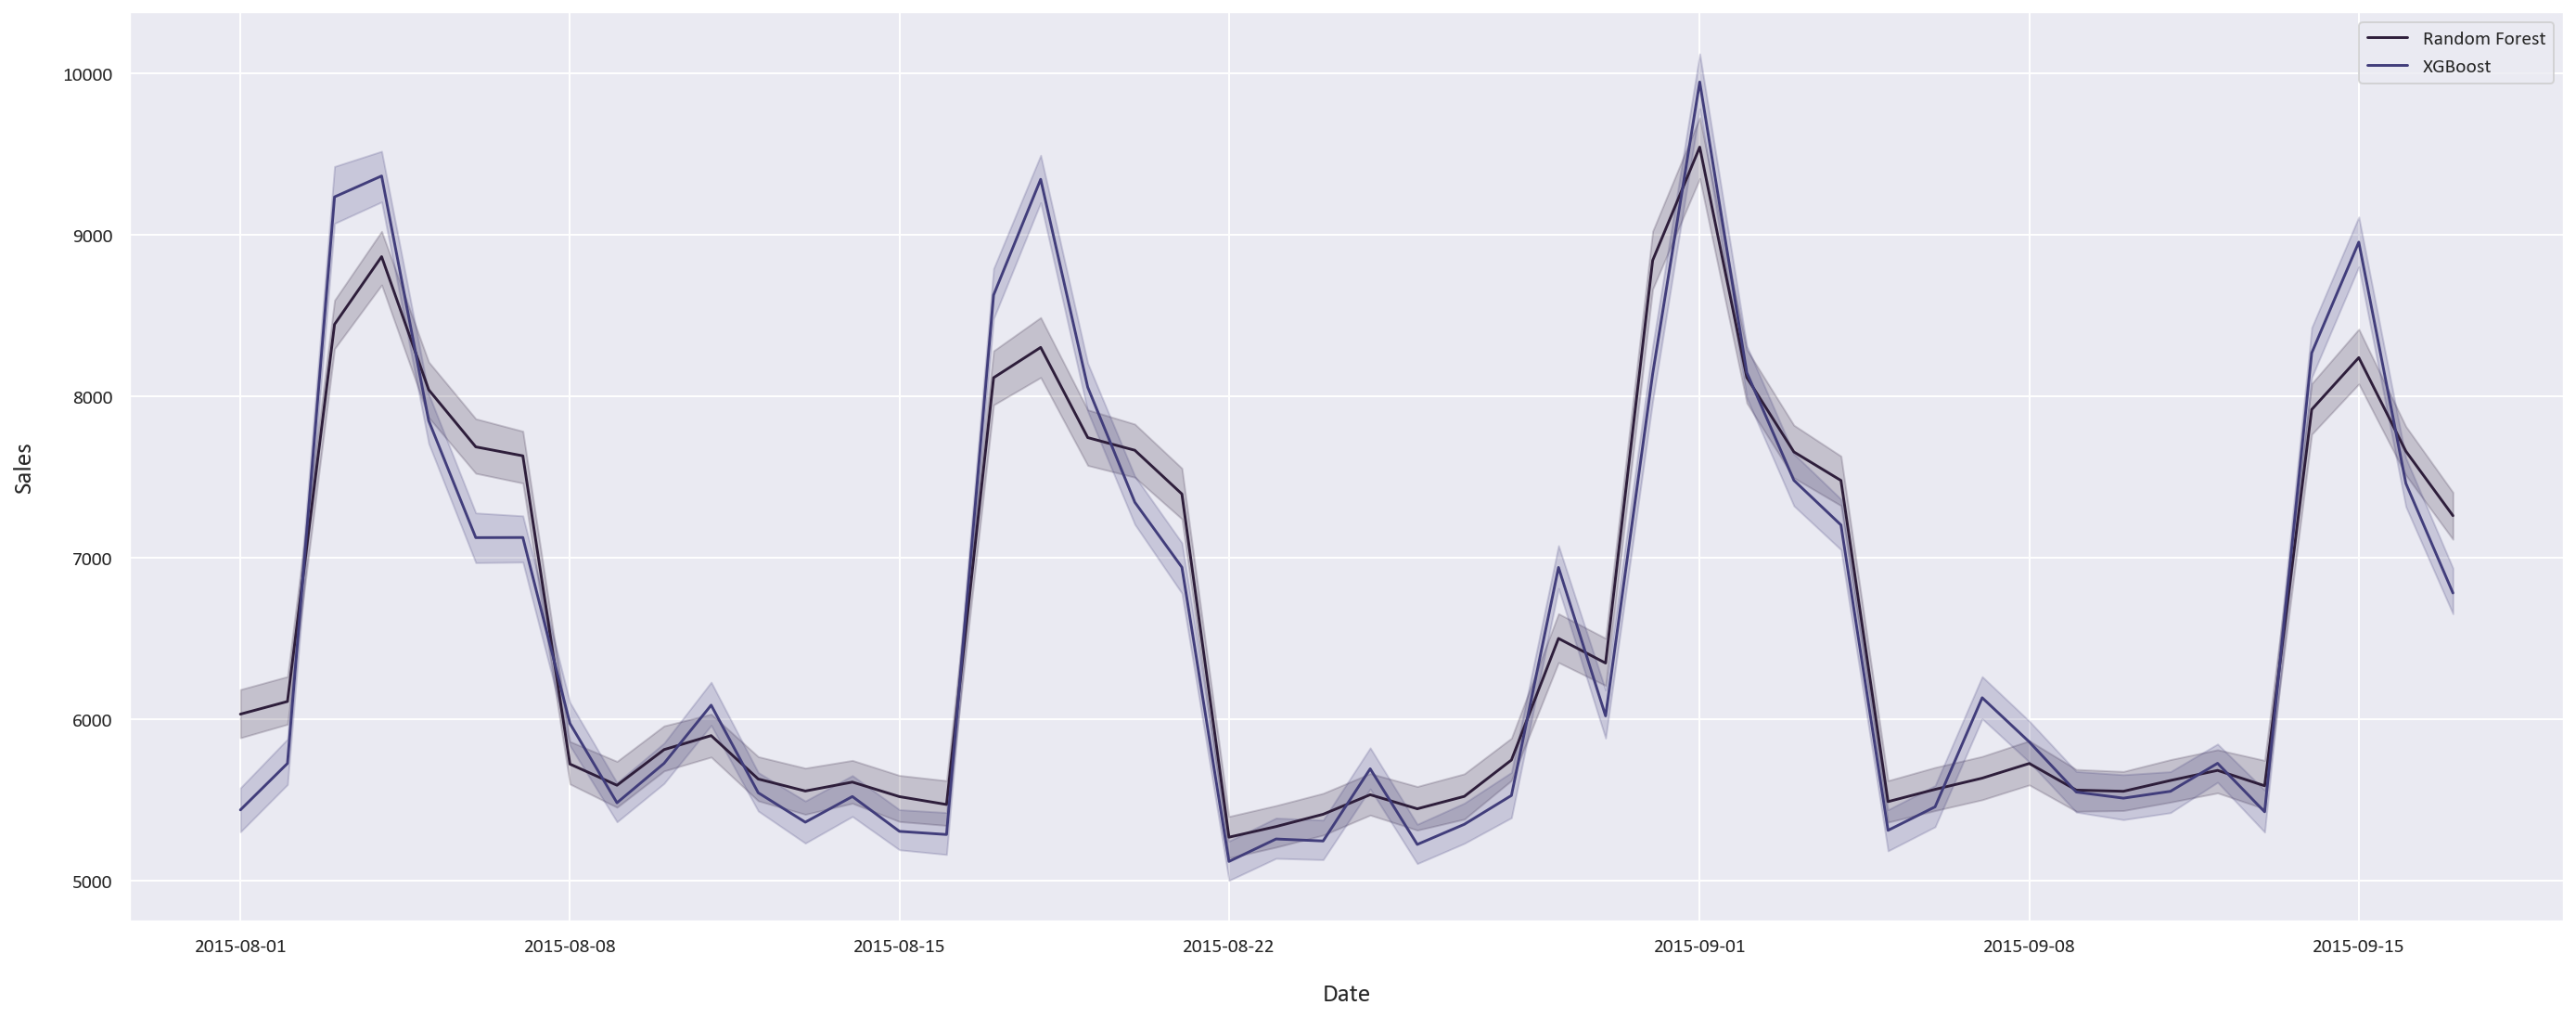

In [160]:
# Plot both predictions with 95% confidence intervals
plt.figure(figsize=(20, 8))
sns.lineplot(x=test.index, y=test_pred, label='Random Forest', ci=95)
sns.lineplot(x=test.index, y=test_pred_xgb, label='XGBoost', ci=95)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()

The two models' predictions are fairly close, this was expected as they performed similarly on the training data. The results are very promising, and I am satisfied with the performance of the models.